<a href="https://colab.research.google.com/github/paucimi/ProyectoMachineLearning/blob/main/PracticaML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Proyecto de Predicción del Precio de Airbnb**
###Objetivo del Proyecto
El objetivo principal de éste proyecto fue desarrollar un modelo de regresión capaz de predecir el precio de alojamientos de Airbnb utilizando datos extraídos mediante técnicas de scraping.
Para lograrlo, se implementó un flujo de trabajo que incluyó análisis exploratorio, preprocesamiento de datos, modelado con múltiples algoritmos y evaluación.

In [104]:
# Importar librerías necesarias
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Descripción del Dataset
#####Fuente: Archivo airbnb-listings-extract.csv.
Características:
######Variables numéricas (e.g., Availability, Minimum Nights, Bedrooms).
######Variables categóricas (e.g., Room Type, Neighbourhood Group).
######Variable objetivo: Price.

In [3]:
#División train/test
full_airbnb = pd.read_csv('/content/drive/MyDrive/airbnb-listings-extract.csv',
                          sep=';', encoding='utf-8')
train, test = train_test_split(full_airbnb, test_size=0.2, shuffle=True,
                               random_state=0)
print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

Dimensiones del dataset de training: (11824, 89)
Dimensiones del dataset de test: (2956, 89)


In [4]:
# Guardar datasets
train.to_csv('/content/drive/MyDrive/airbnb-listings_train.csv', sep=';',
             decimal='.', index=False)
test.to_csv('/content/drive/MyDrive/airbnb-listings_test.csv', sep=';',
            decimal='.', index=False)

In [5]:
# Trabajar únicamente con el dataset de training
airbnb_data = pd.read_csv('/content/drive/MyDrive/airbnb-listings_train.csv', sep=';', decimal='.')
print(airbnb_data.head(5).T)

                                                                                0  \
ID                                                                        5994463   
Listing Url                                  https://www.airbnb.com/rooms/5994463   
Scrape ID                                                          20170407214119   
Last Scraped                                                           2017-04-08   
Name                                             PISO ATOCHA- FLAT NEAR ATOCHA  .   
...                                                                           ...   
Cancellation Policy                                                      moderate   
Calculated host listings count                                                2.0   
Reviews per Month                                                             0.5   
Geolocation                                          40.4077318793,-3.68481869733   
Features                        Host Has Profile Pic,Is Location 

# ======= Análisis Exploratorio ========
Análisis y Limpieza de Datos
#####Valores Nulos:
#####Variables numéricas: Imputación con la mediana.
#####Variables categóricas: Imputación con la moda.
Detección y Tratamiento de Outliers:
#####Se aplicó la técnica IQR (Rango Intercuartil) y los valores extremos fueron reemplazados por la mediana.
Visualización Inicial:
#####Histogramas y boxplots para analizar distribuciones y detectar outliers.
#####Matriz de correlación para identificar variables redundantes.

In [6]:
# Descripción inicial
print(airbnb_data.describe())
print(airbnb_data.dtypes)

                 ID     Scrape ID       Host ID  Host Response Rate  \
count  1.182400e+04  1.182400e+04  1.182400e+04        10317.000000   
mean   1.025308e+07  2.017038e+13  3.588310e+07           94.803722   
std    5.566485e+06  5.505346e+08  3.411993e+07           15.247078   
min    1.986400e+04  2.016010e+13  1.745300e+04            0.000000   
25%    5.510692e+06  2.017041e+13  6.855490e+06          100.000000   
50%    1.125754e+07  2.017041e+13  2.454770e+07          100.000000   
75%    1.531982e+07  2.017041e+13  5.431096e+07          100.000000   
max    1.858361e+07  2.017062e+13  1.247534e+08          100.000000   

       Host Listings Count  Host Total Listings Count      Latitude  \
count         11821.000000               11821.000000  11824.000000   
mean             12.754420                  12.754420     40.491628   
std              34.578895                  34.578895      4.701030   
min               0.000000                   0.000000    -37.851182   
25%  

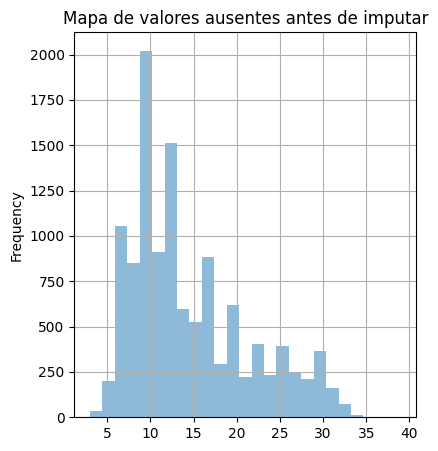

In [25]:
# Visualizar valores nulos
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
# Calcular el total de nulos
airbnb_data.isnull().sum(axis=1).plot.hist(alpha=0.5, bins=25, grid = True)
plt.title("Mapa de valores ausentes antes de imputar")
plt.show()

In [26]:
# Manejo de valores Nulos
print(airbnb_data.describe())  # Describe estadísticas básicas como media, mediana, etc.
print(airbnb_data.isna().any(), airbnb_data.isna().sum()) # Verificar valores nulos

                 ID     Scrape ID       Host ID  Host Response Rate  \
count  1.182400e+04  1.182400e+04  1.182400e+04        10317.000000   
mean   1.025308e+07  2.017038e+13  3.588310e+07           94.803722   
std    5.566485e+06  5.505346e+08  3.411993e+07           15.247078   
min    1.986400e+04  2.016010e+13  1.745300e+04            0.000000   
25%    5.510692e+06  2.017041e+13  6.855490e+06          100.000000   
50%    1.125754e+07  2.017041e+13  2.454770e+07          100.000000   
75%    1.531982e+07  2.017041e+13  5.431096e+07          100.000000   
max    1.858361e+07  2.017062e+13  1.247534e+08          100.000000   

       Host Listings Count  Host Total Listings Count      Latitude  \
count         11821.000000               11821.000000  11824.000000   
mean             12.754420                  12.754420     40.491628   
std              34.578895                  34.578895      4.701030   
min               0.000000                   0.000000    -37.851182   
25%  

In [27]:
# Imputación de valores nulos
def imputar_valores_ausentes(df):
    for column in df.columns:
        if df[column].dtype == 'float64' or df[column].dtype == 'int64':
            # Usar mediana para variables numéricas
            df[column].fillna(df[column].median(), inplace=True)

        else:# Usar moda para variables categóricas
            df[column].fillna(df[column].mode()[0], inplace=True)
    return df
airbnb_data_imputado = imputar_valores_ausentes(airbnb_data)

airbnb_data_imputado.describe()

ID     Scrape ID       Host ID  Host Response Rate  \
count  1.182400e+04  1.182400e+04  1.182400e+04        11824.000000   
mean   1.025308e+07  2.017038e+13  3.588310e+07           95.466001   
std    5.566485e+06  5.505346e+08  3.411993e+07           14.347284   
min    1.986400e+04  2.016010e+13  1.745300e+04            0.000000   
25%    5.510692e+06  2.017041e+13  6.855490e+06          100.000000   
50%    1.125754e+07  2.017041e+13  2.454770e+07          100.000000   
75%    1.531982e+07  2.017041e+13  5.431096e+07          100.000000   
max    1.858361e+07  2.017062e+13  1.247534e+08          100.000000   

       Host Listings Count  Host Total Listings Count      Latitude  \
count         11824.000000               11824.000000  11824.000000   
mean             12.751691                  12.751691     40.491628   
std              34.574932                  34.574932      4.701030   
min               0.000000                   0.000000    -37.851182   
25%               1.000000                   1.000000     40.409758   
50%               2.000000                   2.000000     40.419331   
75%               6.000000                   6.000000     40.430778   
max             519.000000                 519.000000     55.966912   

          Longitude  Accommodates     Bathrooms  ...  Number of Reviews  \
count  11824.000000  11824.000000  11824.000000  ...       11824.000000   
mean      -3.776863      3.277486      1.284168  ...          22.664834   
std       14.014695      2.093973      0.663680  ...          38.092338   
min     -123.124429      1.000000      0.000000  ...           0.000000   
25%       -3.707538      2.000000      1.000000  ...           1.000000   
50%       -3.700763      3.000000      1.000000  ...           7.000000   
75%       -3.683917      4.000000      1.000000  ...          27.000000   
max      153.371427     16.000000      8.000000  ...         356.000000   

       Review Scores Rating  Review Scores Accuracy  \
count          11824.000000            11824.000000   
mean              92.161959                9.543809   
std                8.104613                0.861033   
min               20.000000                2.000000   
25%               90.000000                9.000000   
50%               94.000000               10.000000   
75%               97.000000               10.000000   
max              100.000000               10.000000   

       Review Scores Cleanliness  Review Scores Checkin  \
count               11824.000000           11824.000000   
mean                    9.474459               9.709405   
std                     0.928114               0.724127   
min                     2.000000               2.000000   
25%                     9.000000              10.000000   
50%                    10.000000              10.000000   
75%                    10.000000              10.000000   
max                    10.000000              10.000000   

       Review Scores Communication  Review Scores Location  \
count                 11824.000000            11824.000000   
mean                      9.727588                9.640562   
std                       0.689180                0.704644   
min                       2.000000                2.000000   
25%                      10.000000                9.000000   
50%                      10.000000               10.000000   
75%                      10.000000               10.000000   
max                      10.000000               10.000000   

       Review Scores Value  Calculated host listings count  Reviews per Month  
count         11824.000000                    11824.000000       11824.000000  
mean              9.163227                        9.612737           1.730888  
std               0.851037                       23.791966           1.678590  
min               2.000000                        1.000000           0.020000  
25%               9.000000                        1.000000           0.620

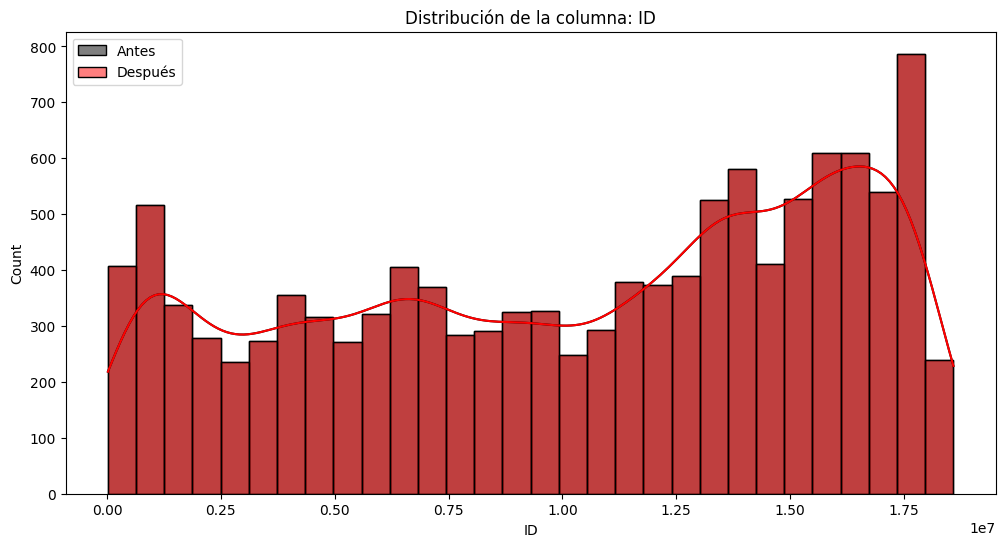

<Figure size 640x480 with 0 Axes>

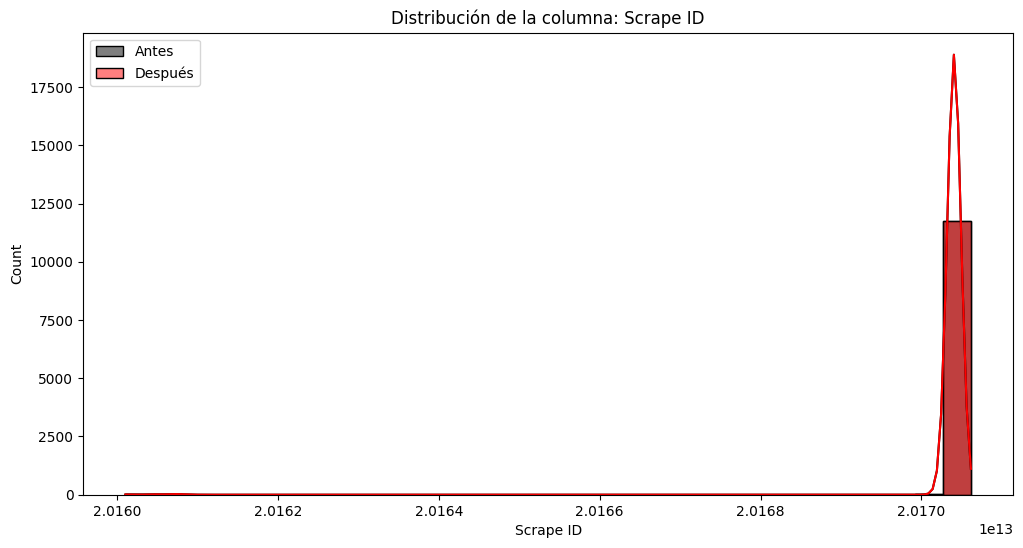

<Figure size 640x480 with 0 Axes>

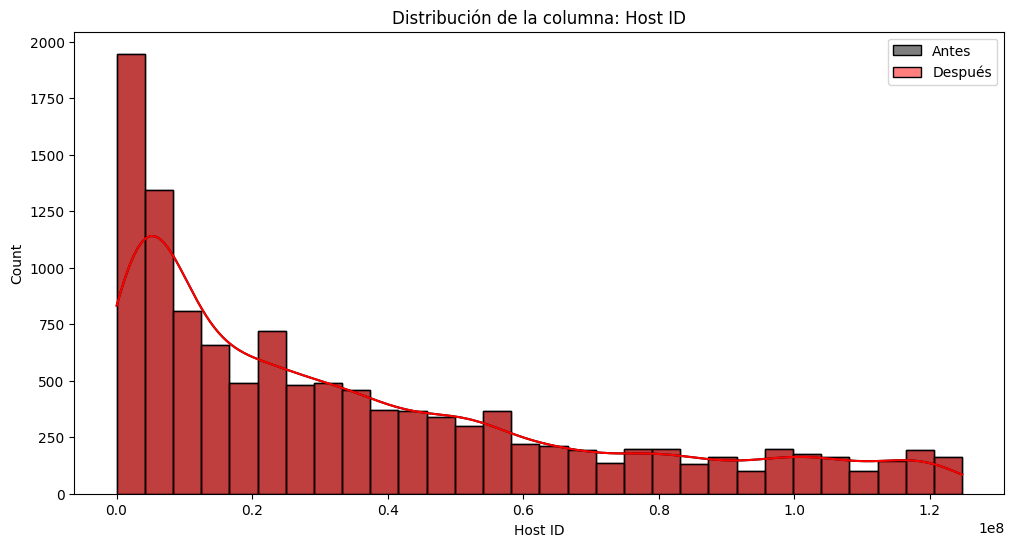

<Figure size 640x480 with 0 Axes>

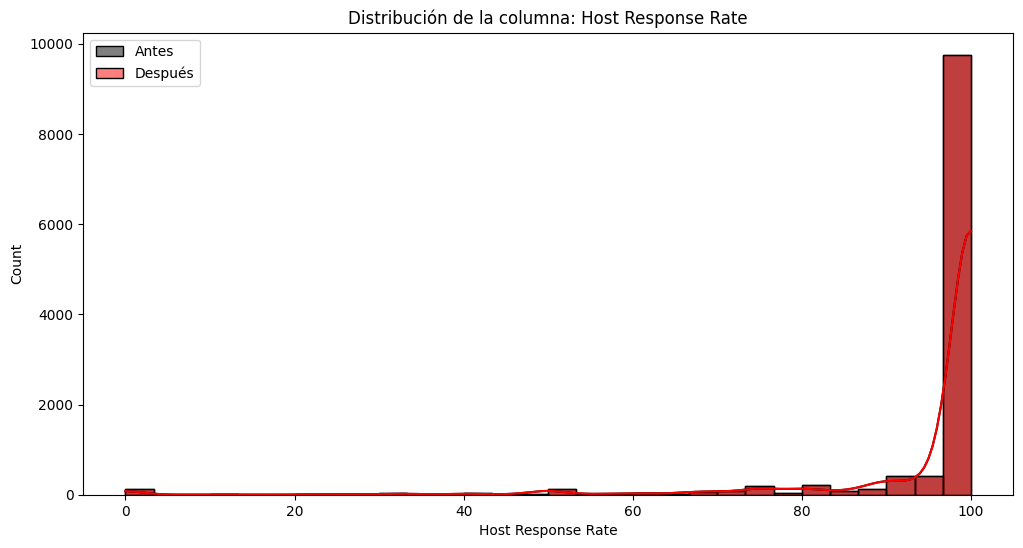

<Figure size 640x480 with 0 Axes>

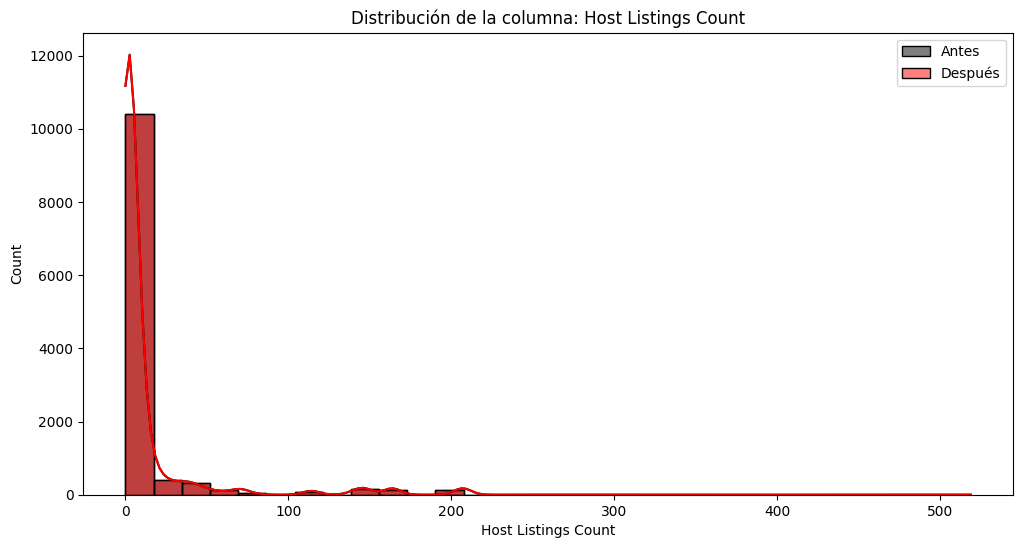

<Figure size 640x480 with 0 Axes>

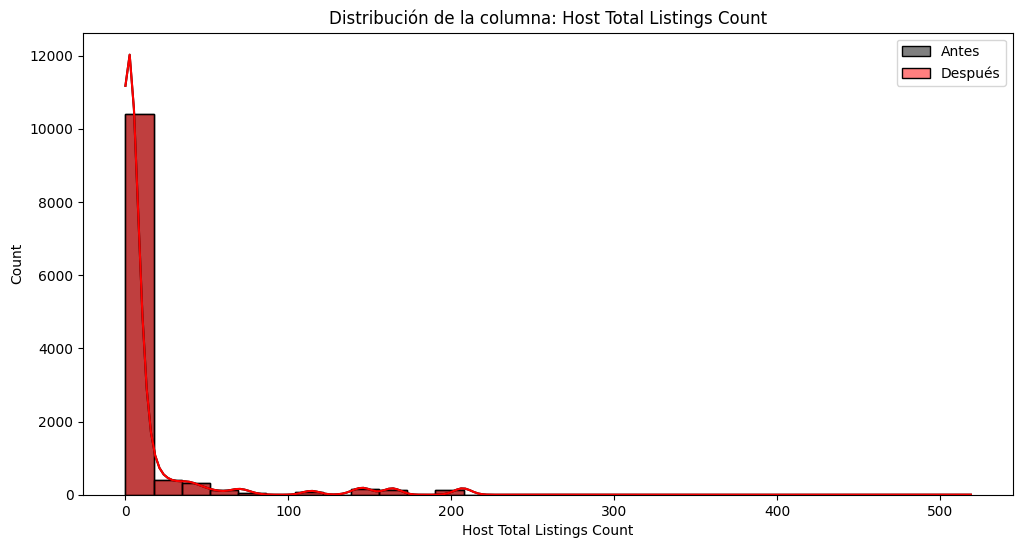

<Figure size 640x480 with 0 Axes>

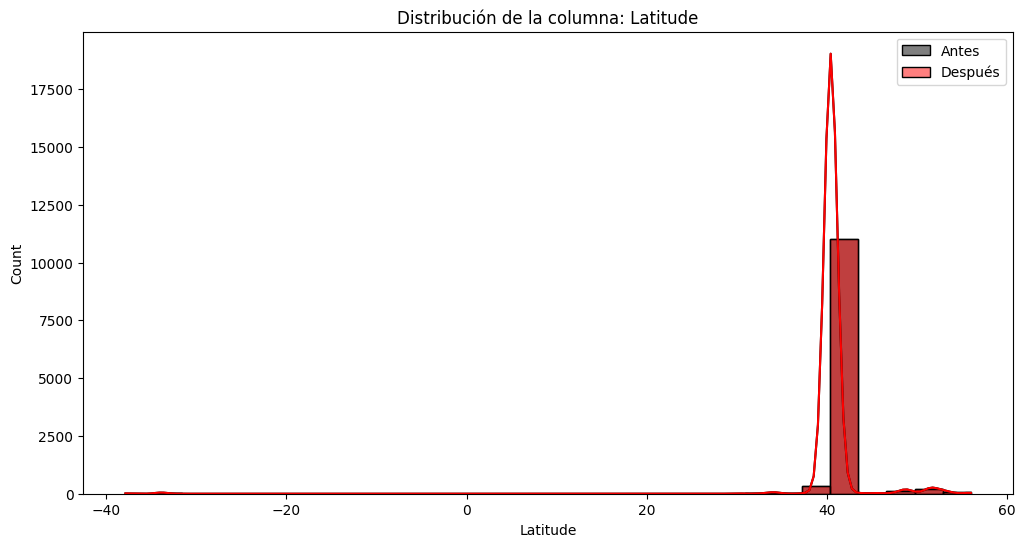

<Figure size 640x480 with 0 Axes>

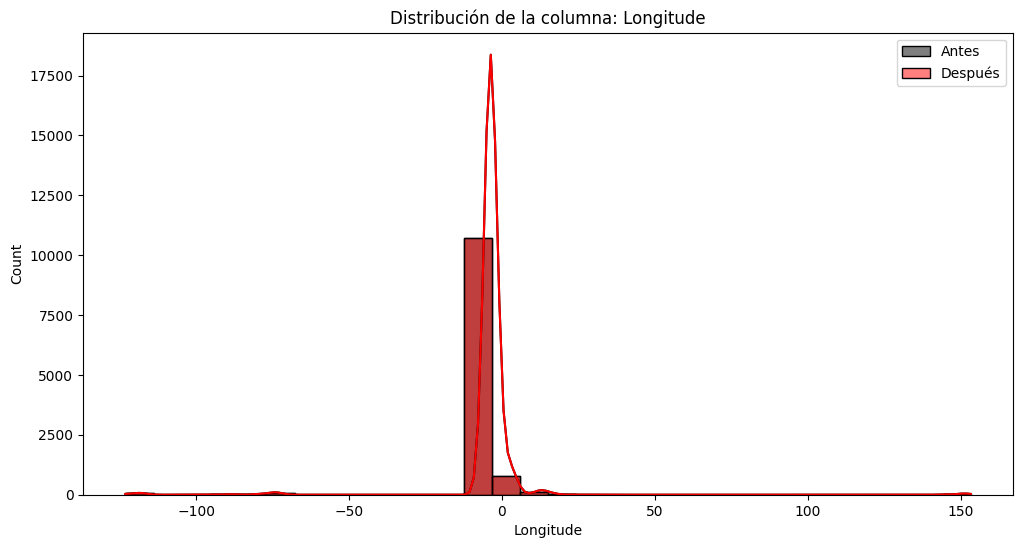

<Figure size 640x480 with 0 Axes>

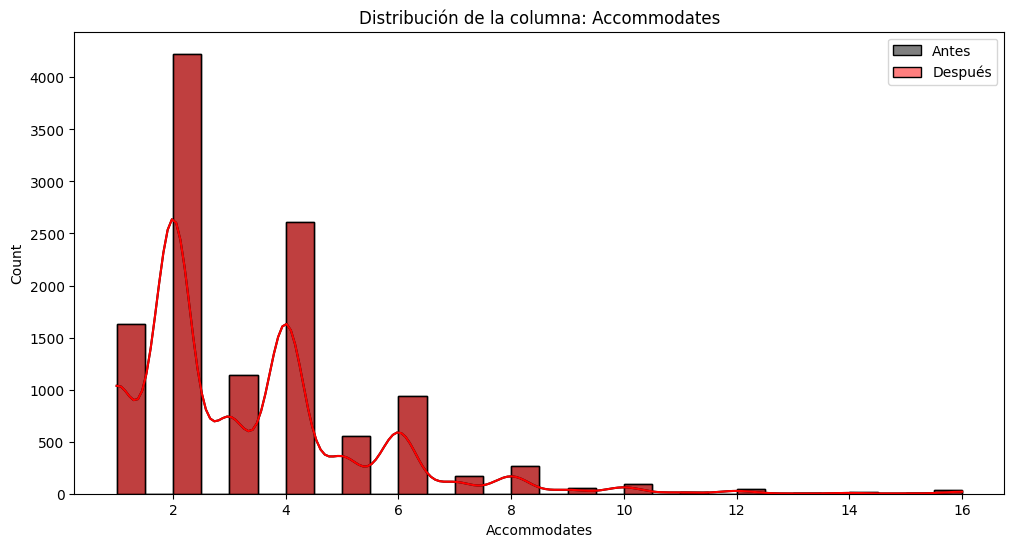

<Figure size 640x480 with 0 Axes>

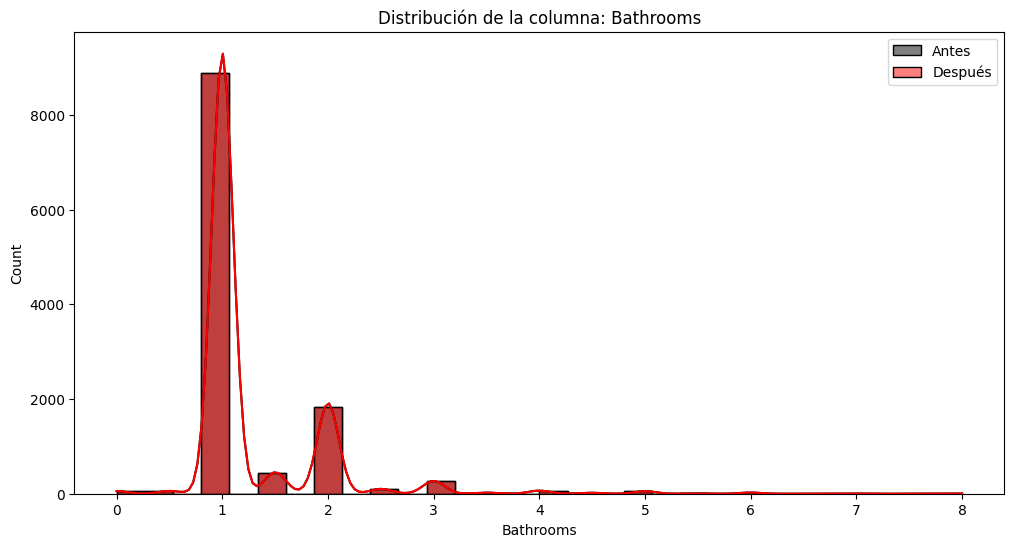

<Figure size 640x480 with 0 Axes>

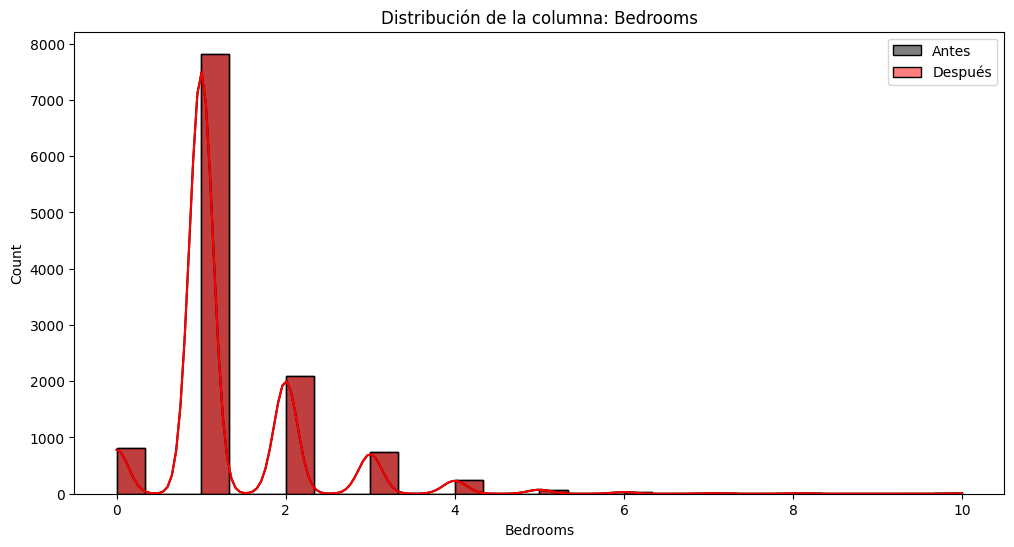

<Figure size 640x480 with 0 Axes>

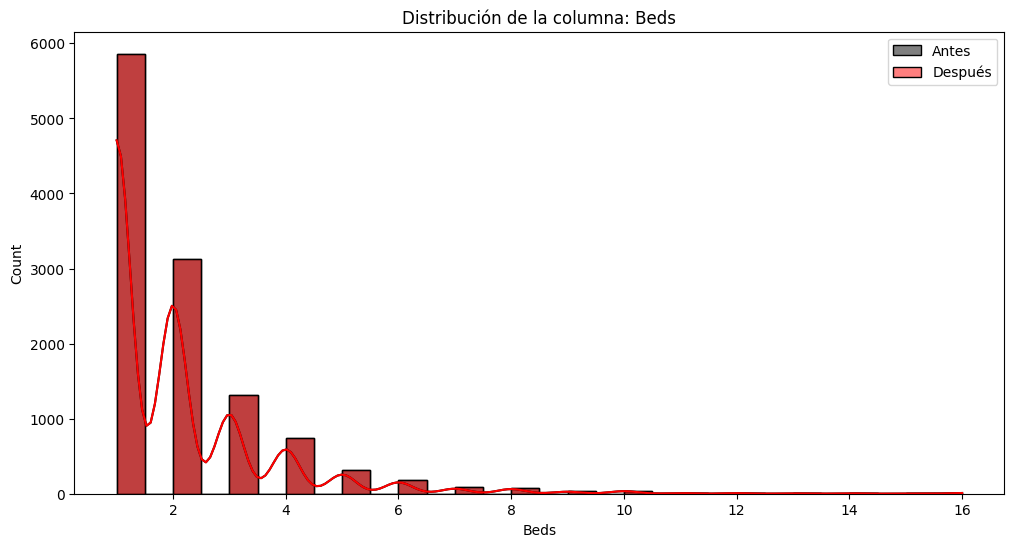

<Figure size 640x480 with 0 Axes>

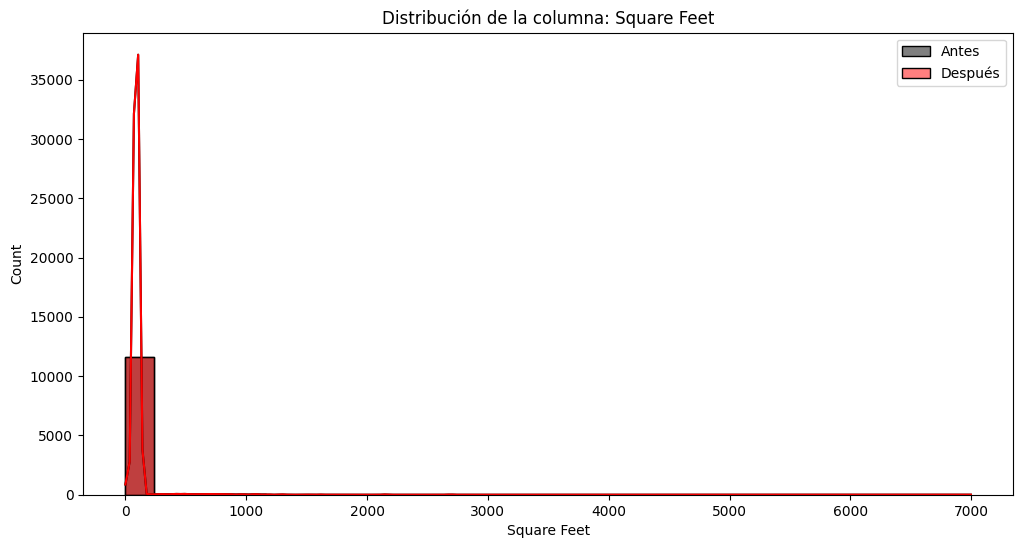

<Figure size 640x480 with 0 Axes>

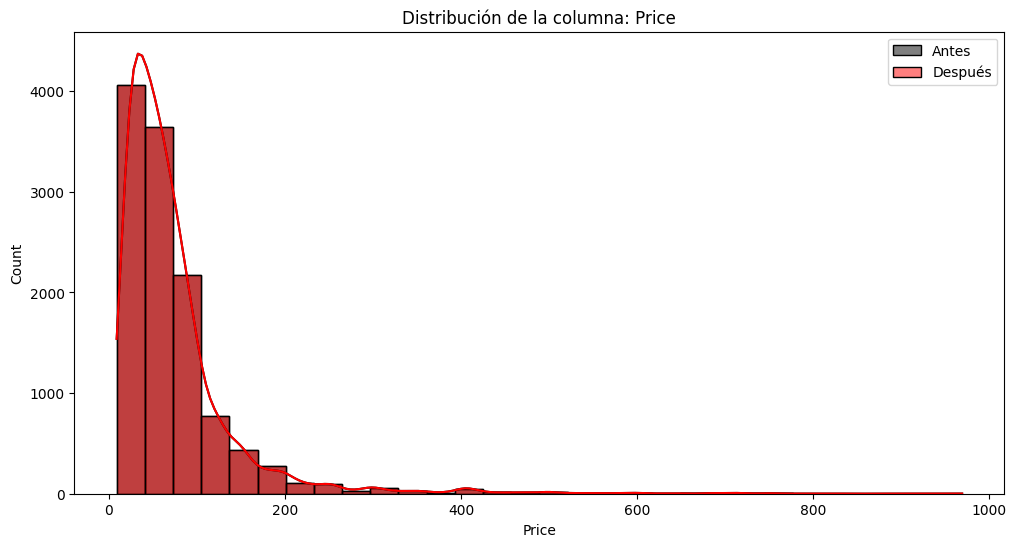

<Figure size 640x480 with 0 Axes>

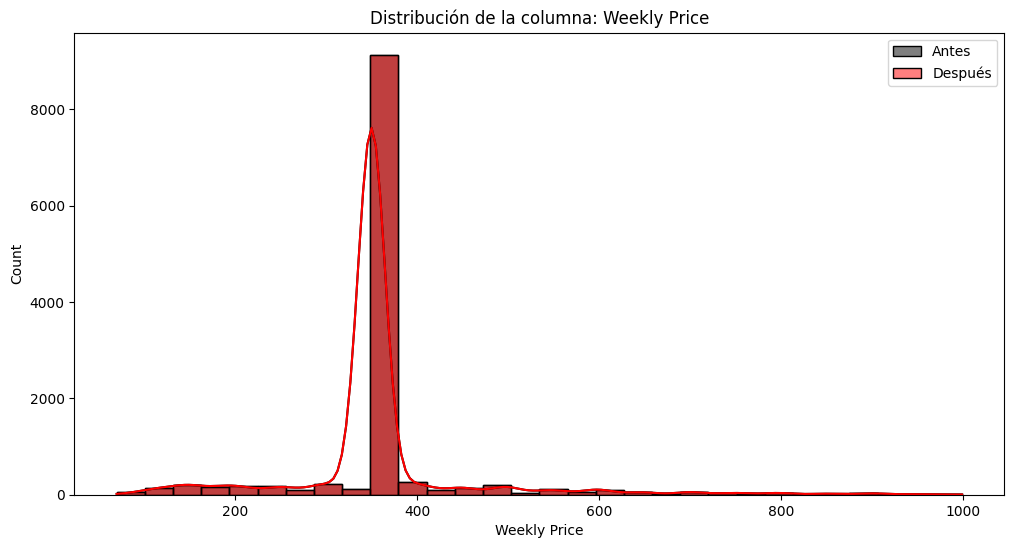

<Figure size 640x480 with 0 Axes>

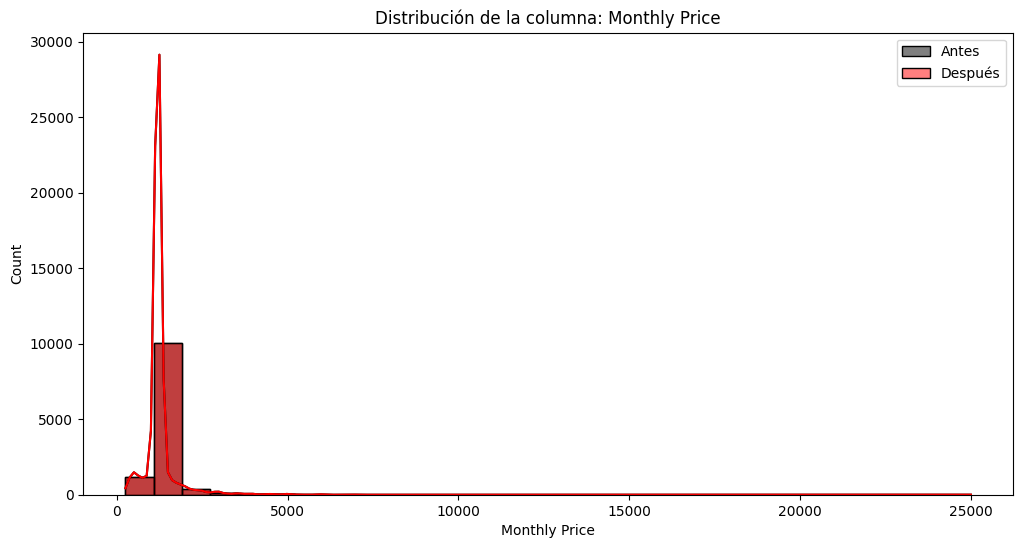

<Figure size 640x480 with 0 Axes>

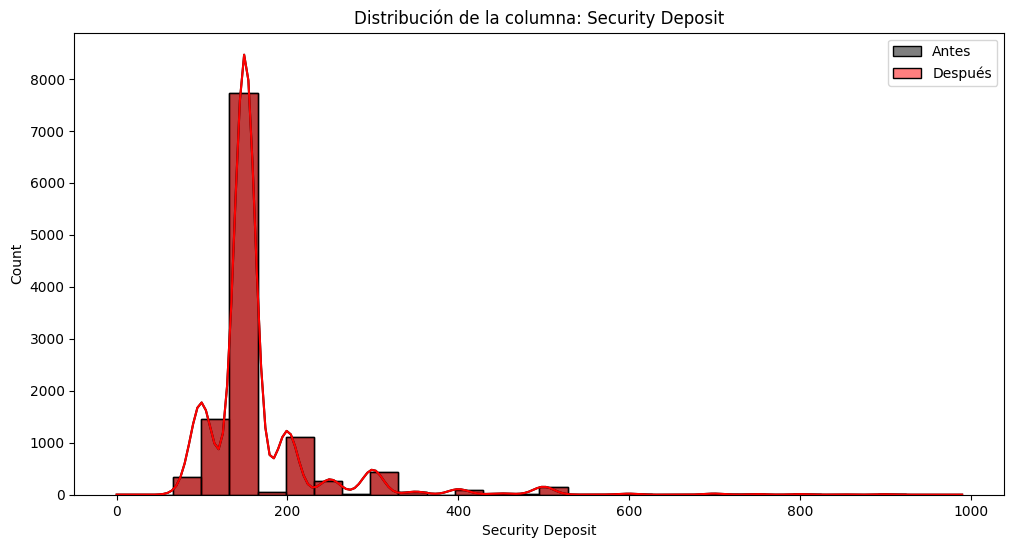

<Figure size 640x480 with 0 Axes>

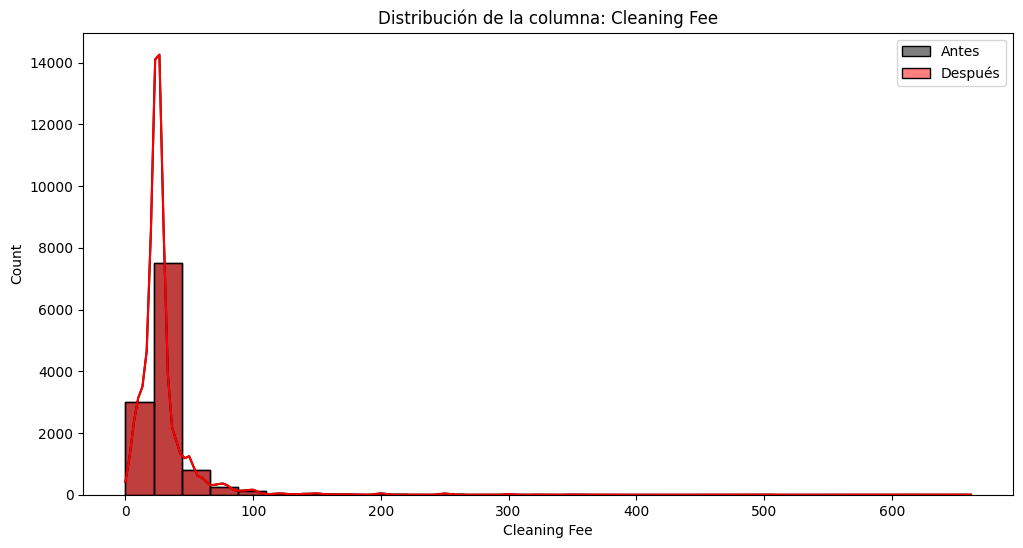

<Figure size 640x480 with 0 Axes>

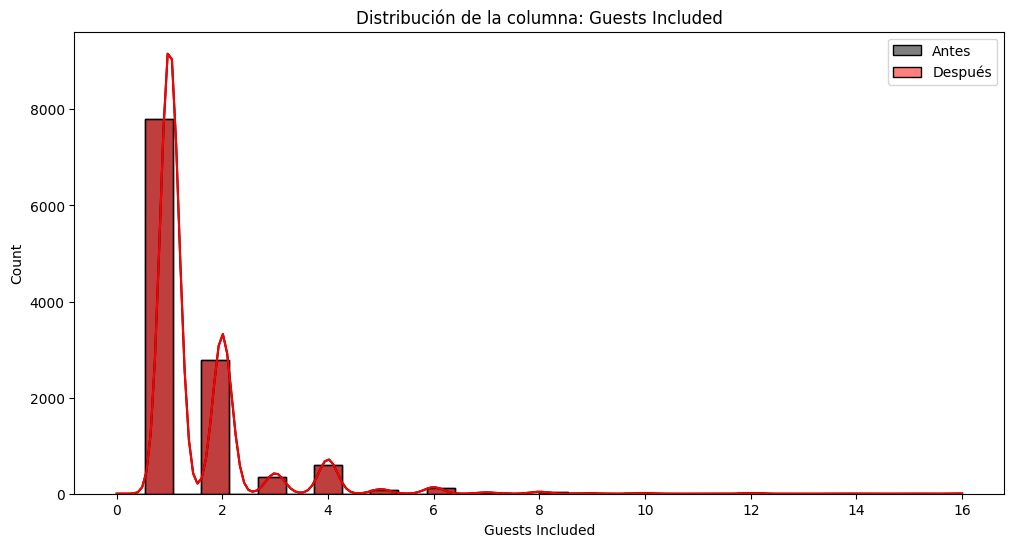

<Figure size 640x480 with 0 Axes>

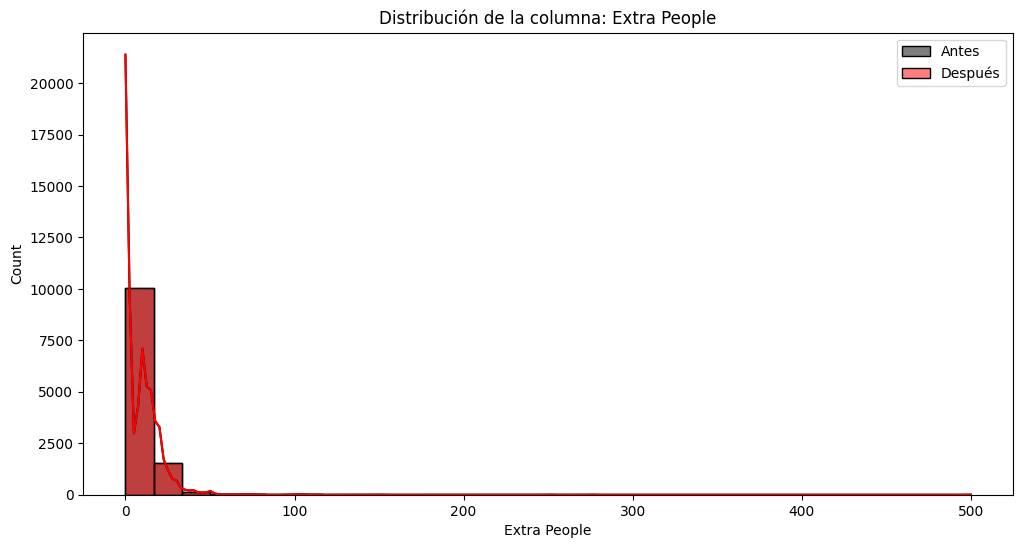

<Figure size 640x480 with 0 Axes>

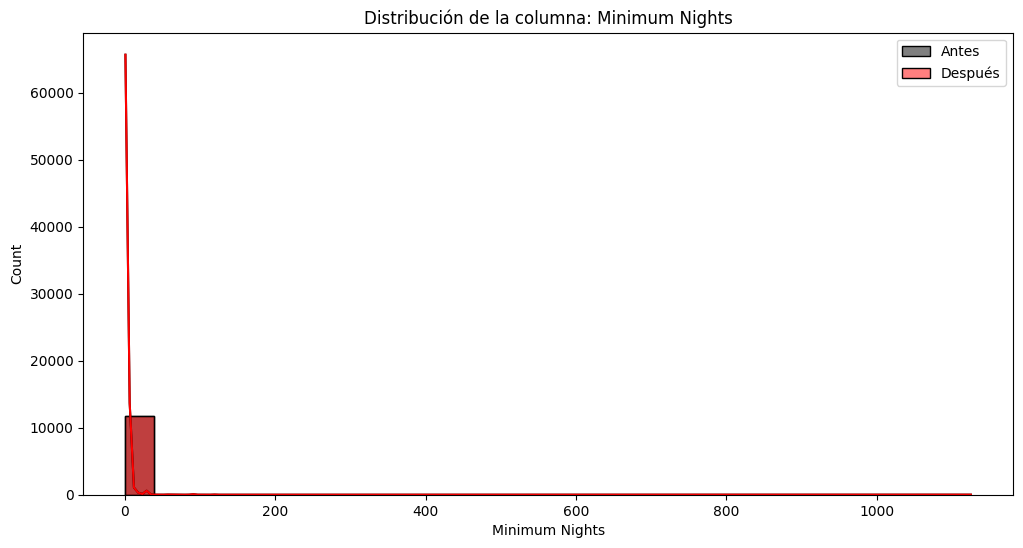

<Figure size 640x480 with 0 Axes>

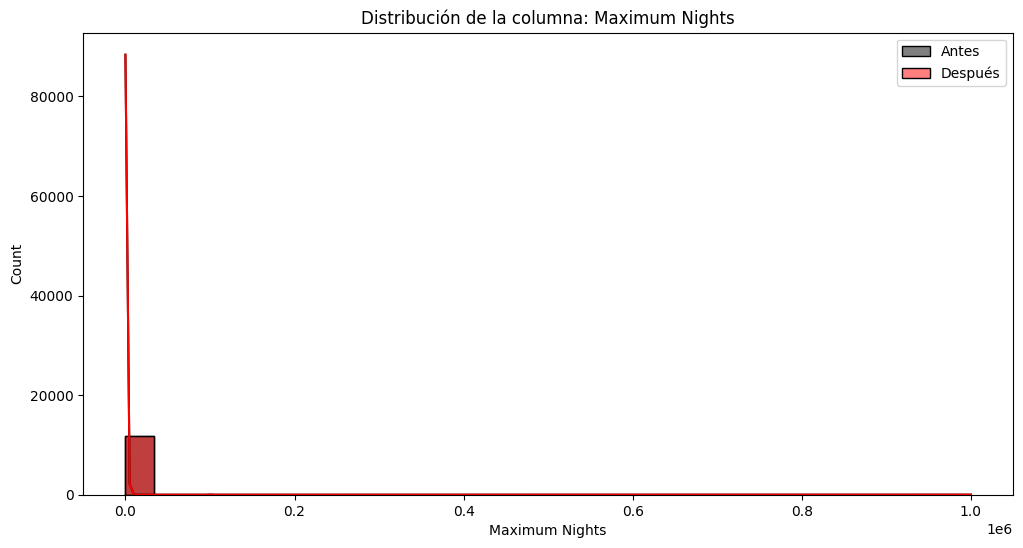

<Figure size 640x480 with 0 Axes>

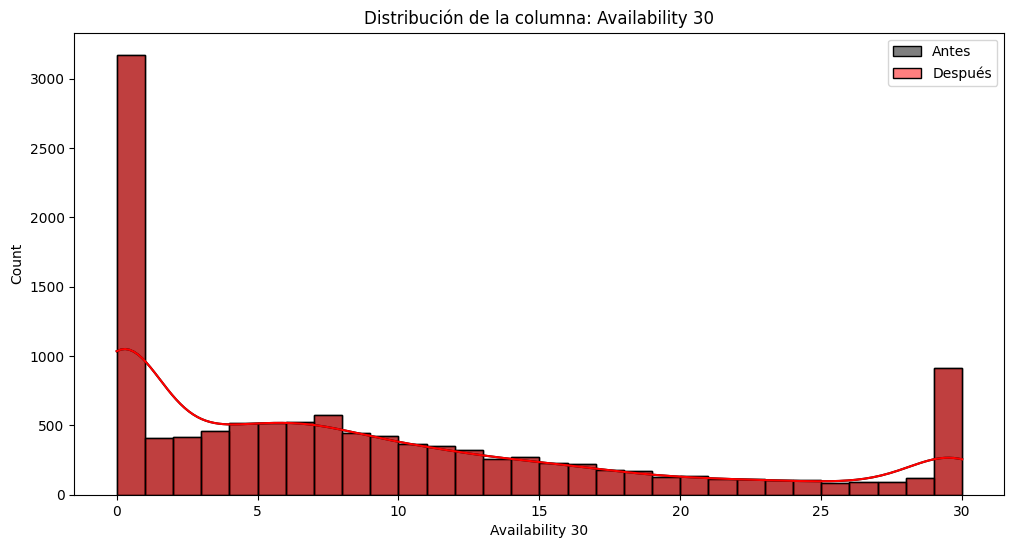

<Figure size 640x480 with 0 Axes>

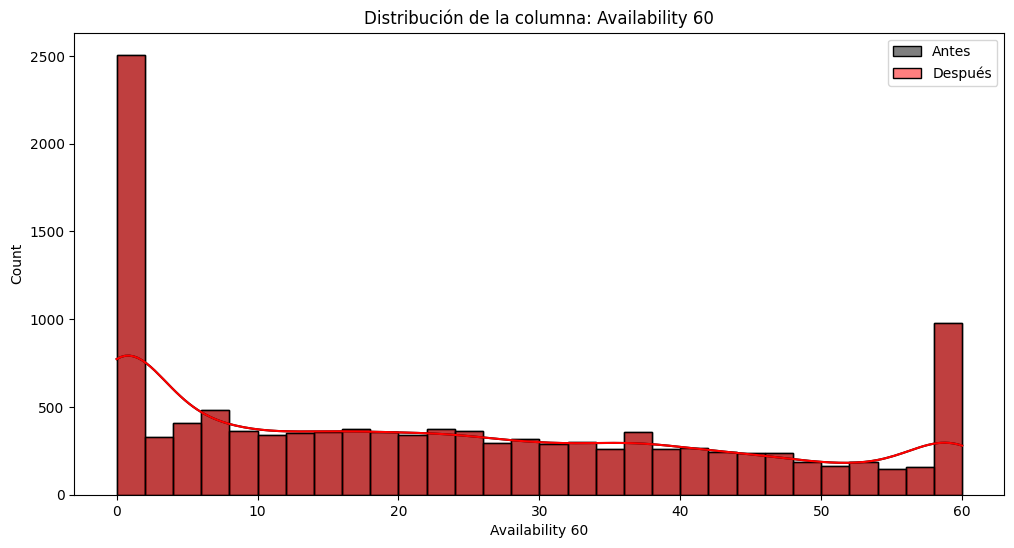

<Figure size 640x480 with 0 Axes>

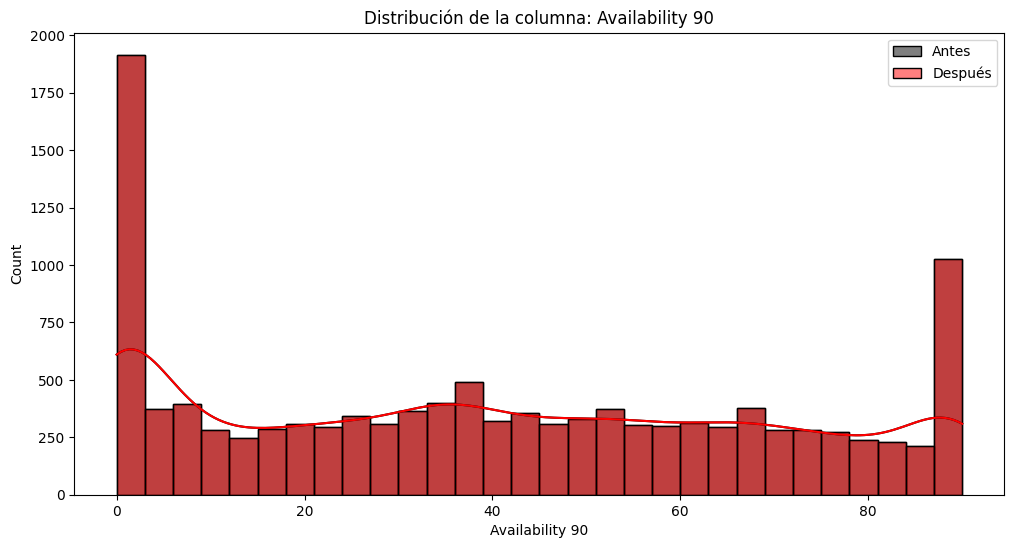

<Figure size 640x480 with 0 Axes>

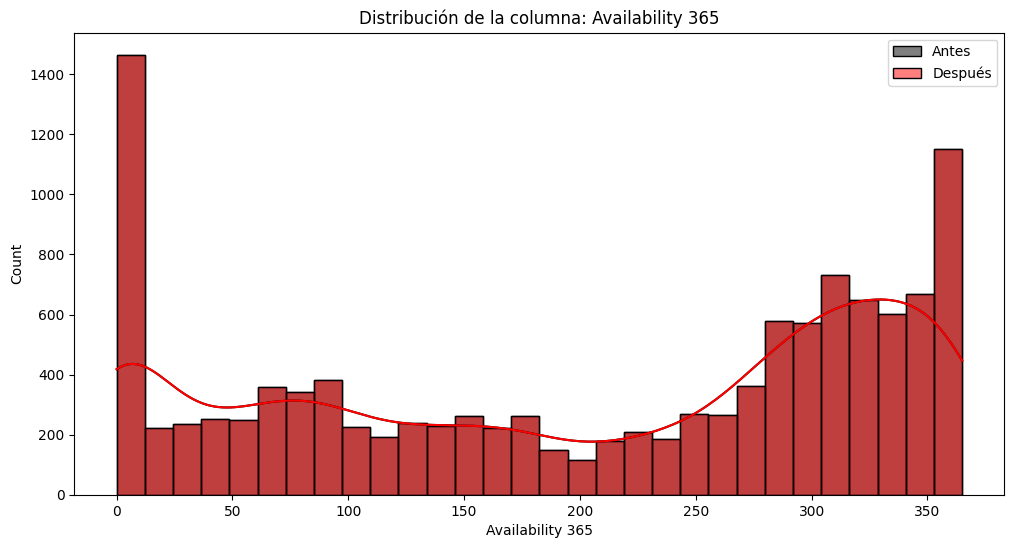

<Figure size 640x480 with 0 Axes>

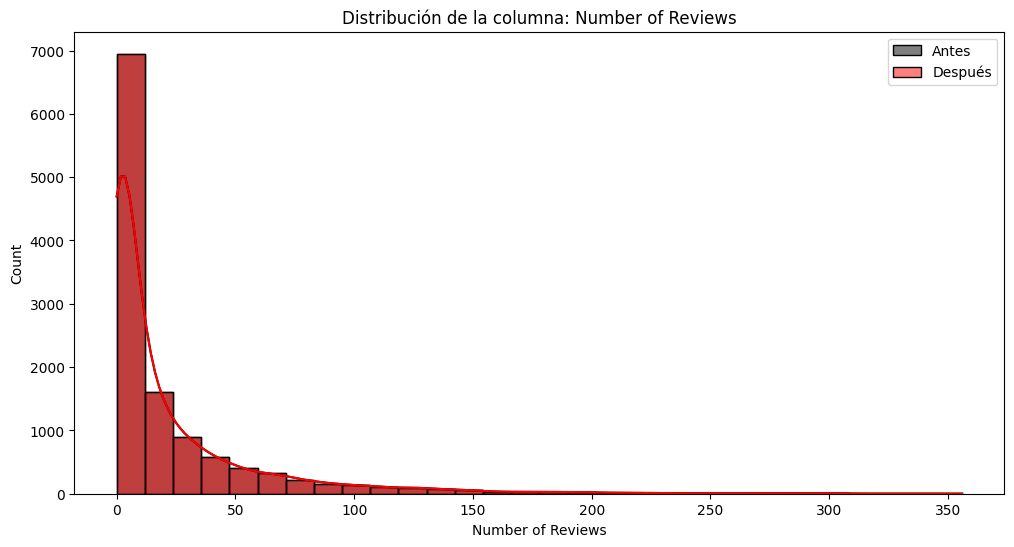

<Figure size 640x480 with 0 Axes>

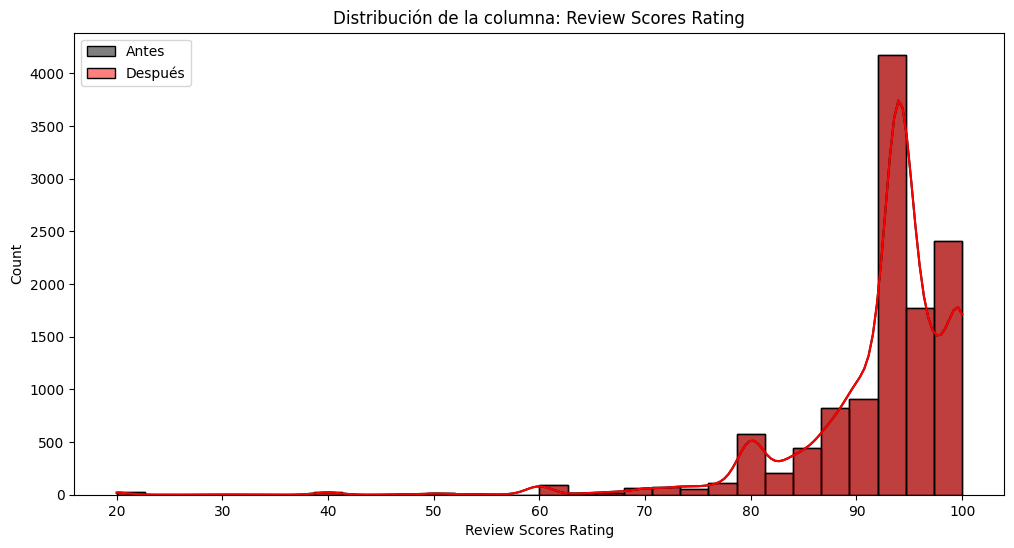

<Figure size 640x480 with 0 Axes>

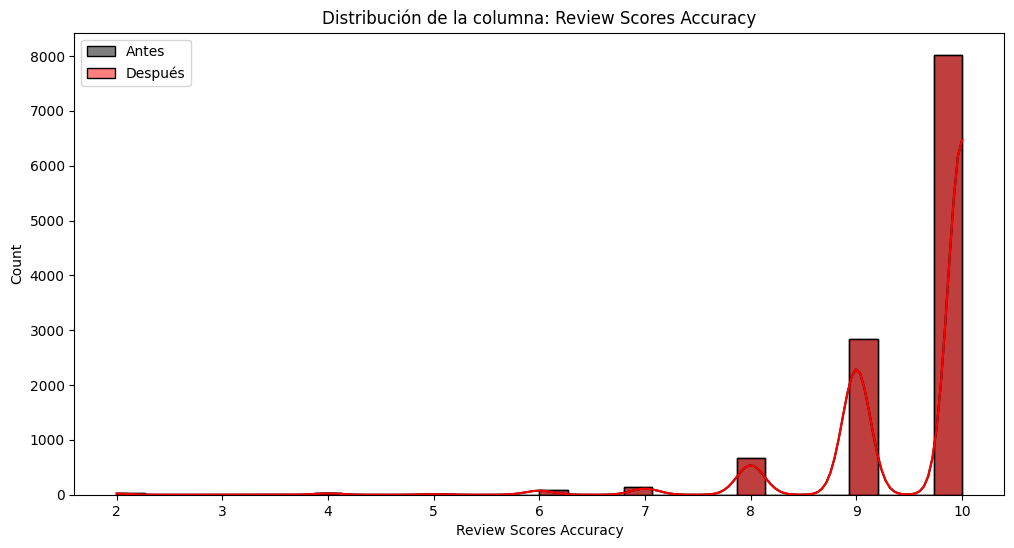

<Figure size 640x480 with 0 Axes>

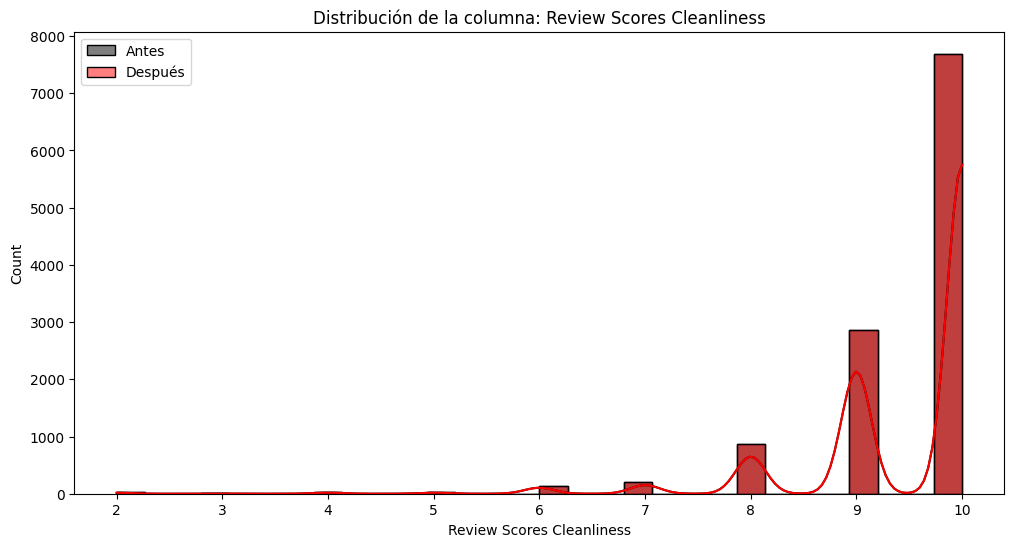

<Figure size 640x480 with 0 Axes>

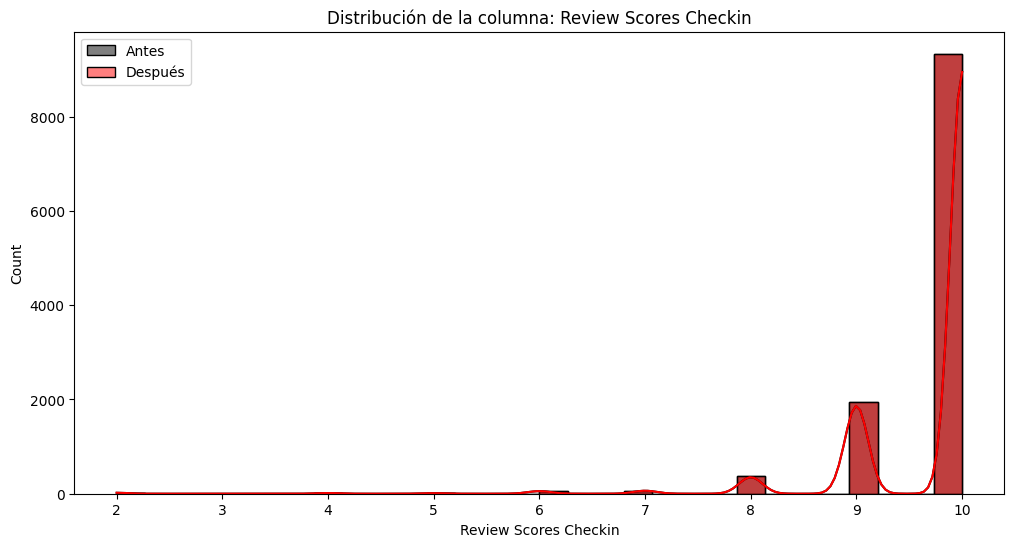

<Figure size 640x480 with 0 Axes>

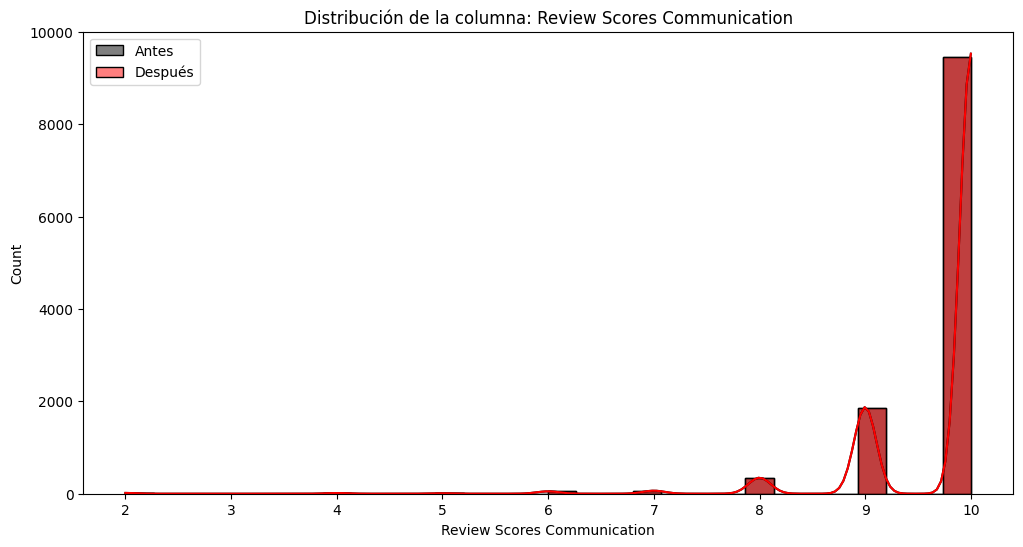

<Figure size 640x480 with 0 Axes>

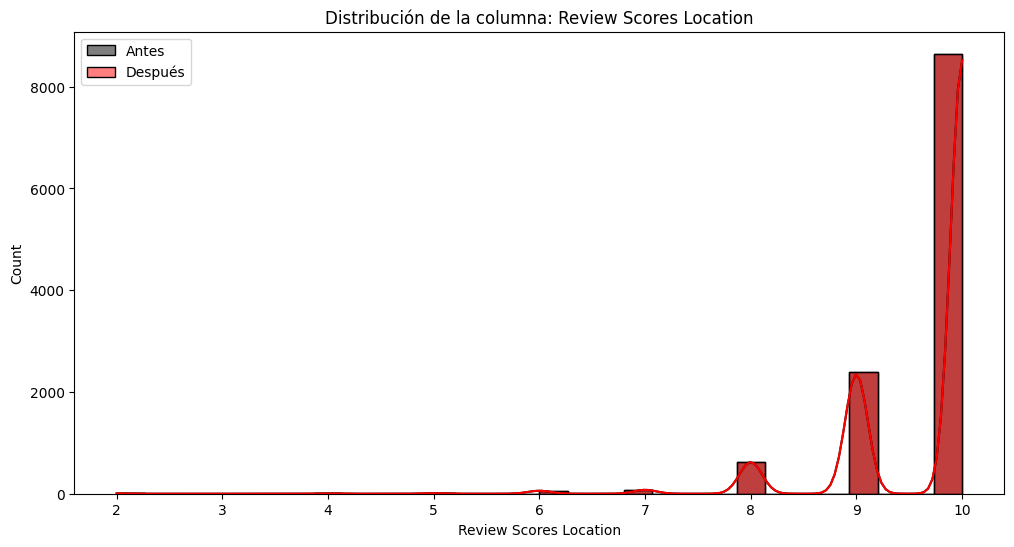

<Figure size 640x480 with 0 Axes>

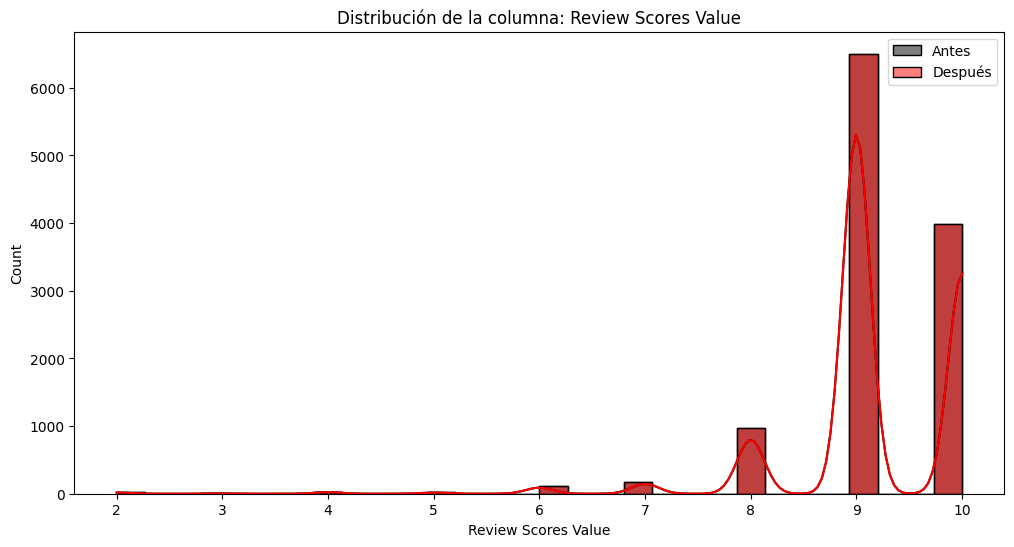

<Figure size 640x480 with 0 Axes>

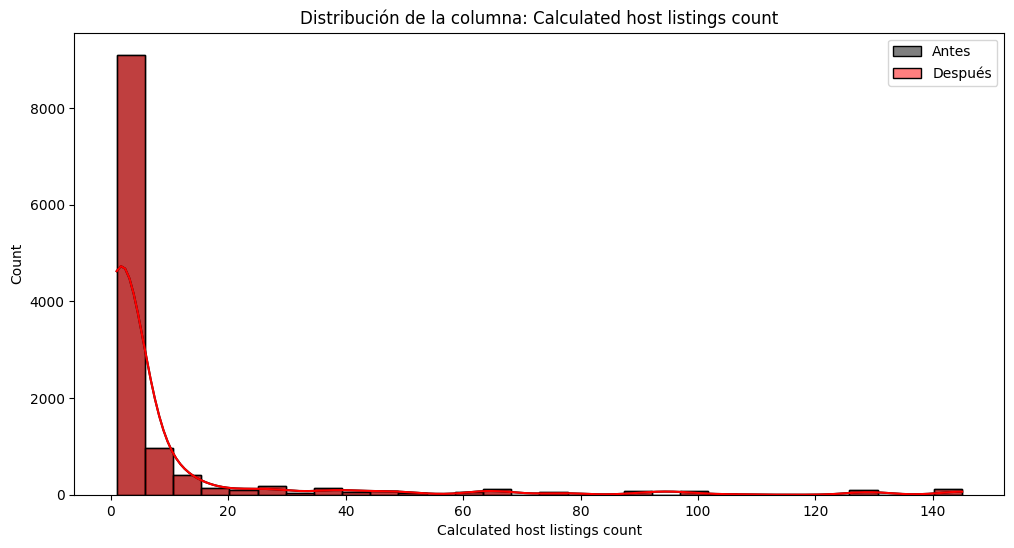

<Figure size 640x480 with 0 Axes>

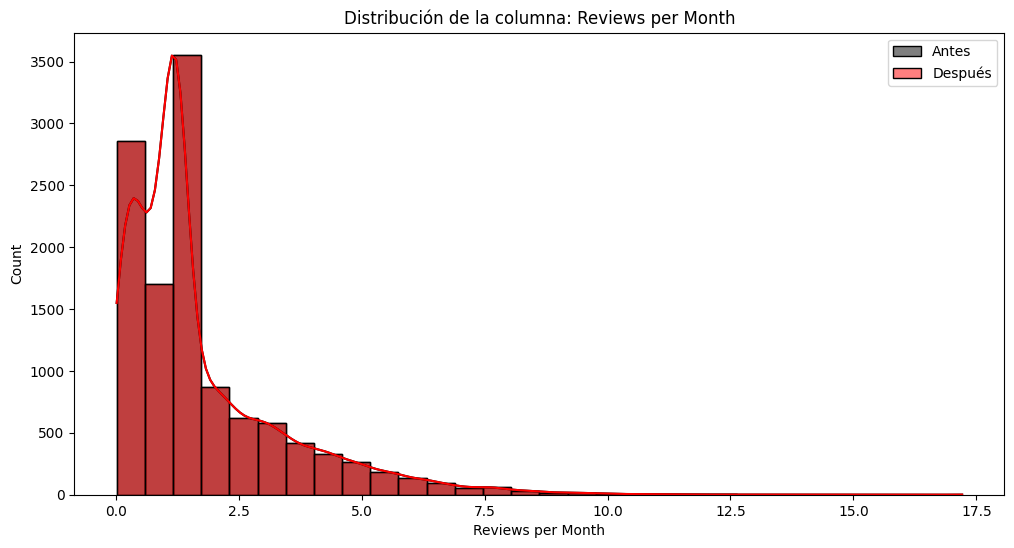

<Figure size 640x480 with 0 Axes>

In [28]:
# Histograma para verificar la distribución antes y después
for column in airbnb_data.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(airbnb_data[column], color="black", kde=True, label="Antes", bins=30)
    sns.histplot(airbnb_data_imputado[column], color="red", kde=True, label="Después", bins=30)
    plt.title(f"Distribución de la columna: {column}")
    plt.legend()
    plt.show()
    plt.clf()

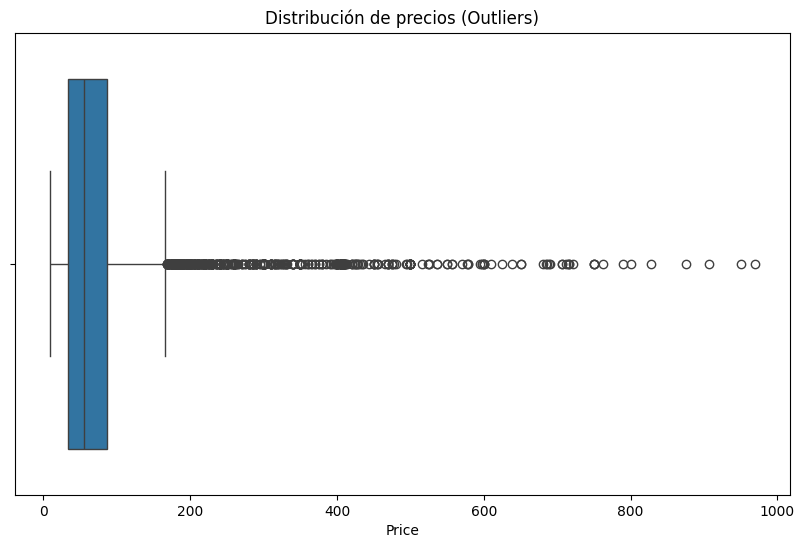

In [29]:
# Detección de outliers en la variable objetivo
plt.figure(figsize=(10, 6))
sns.boxplot(data=airbnb_data, x='Price')
plt.title('Distribución de precios (Outliers)')
plt.show()

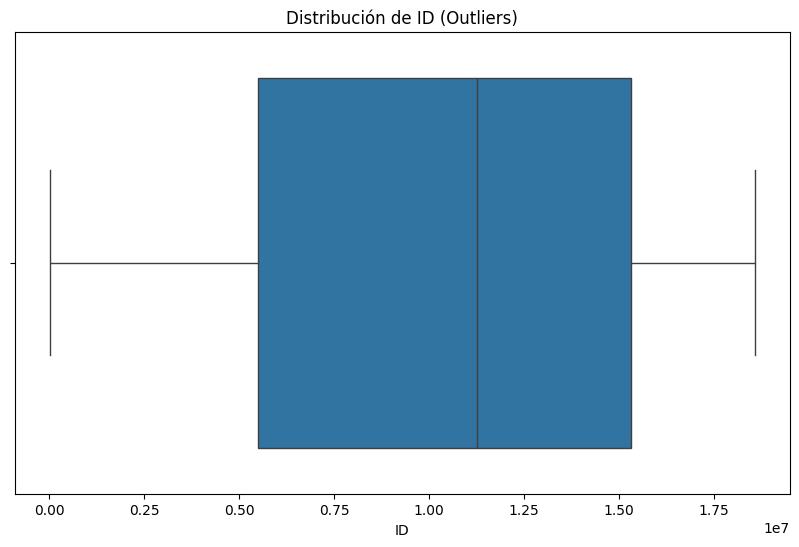

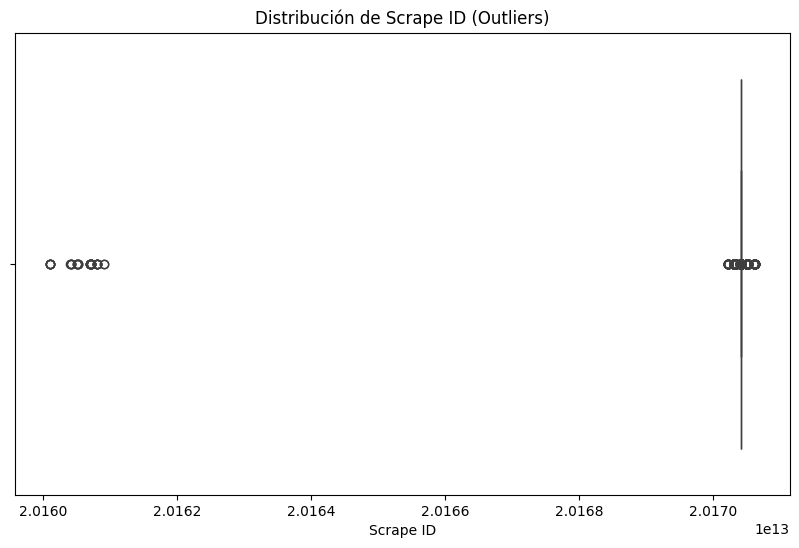

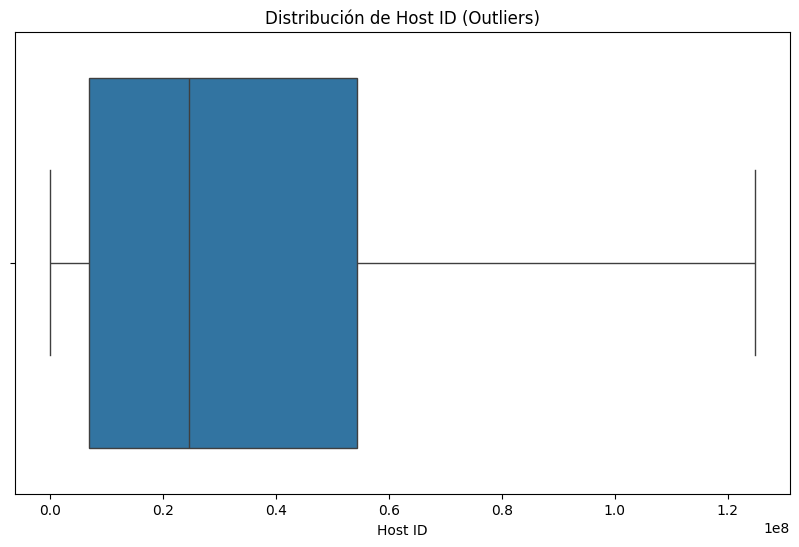

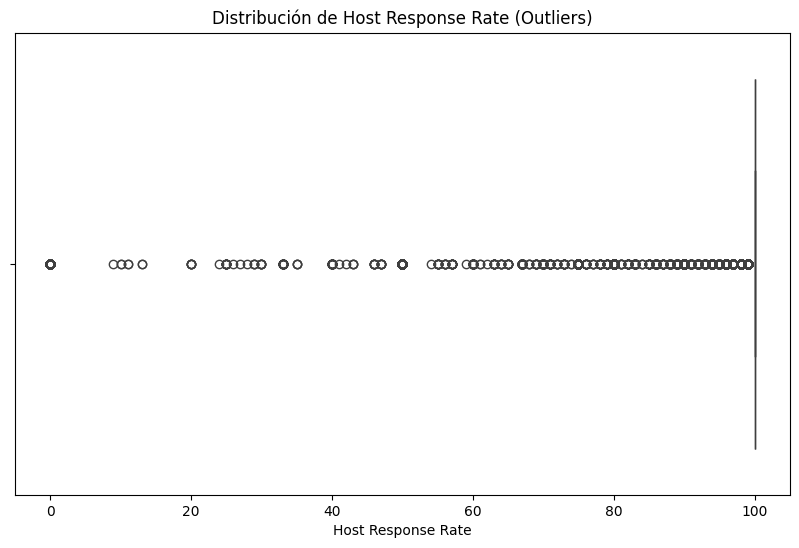

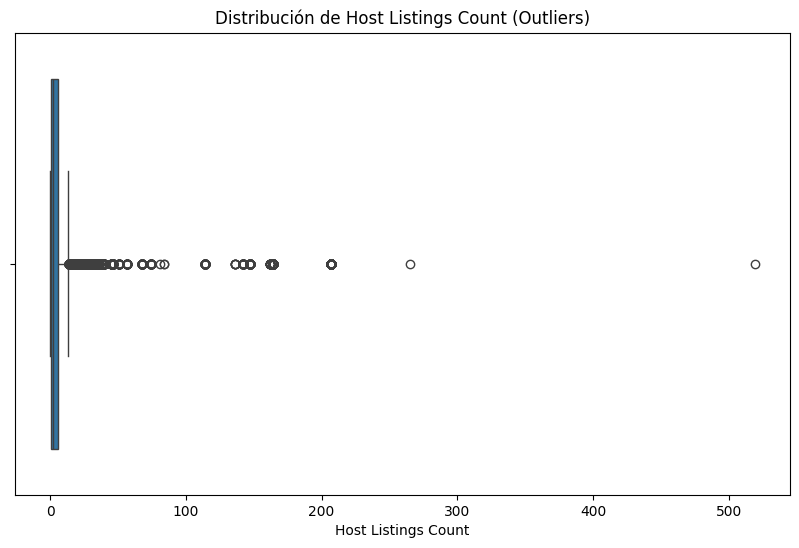

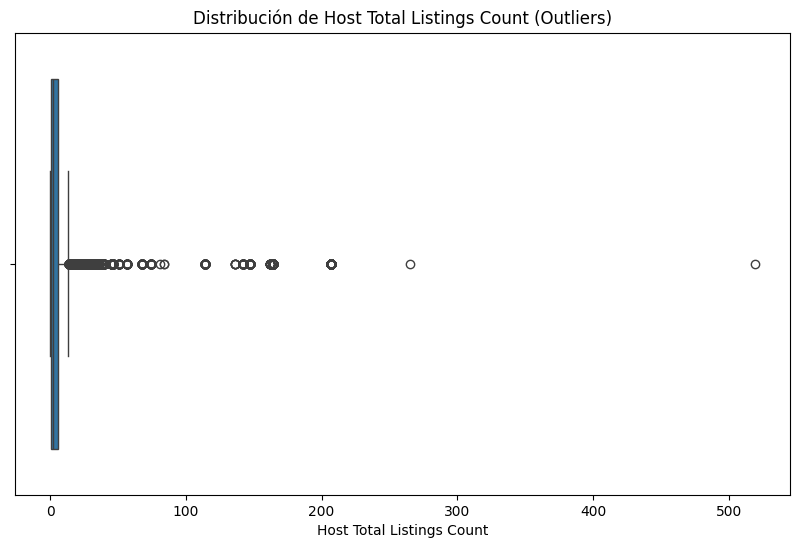

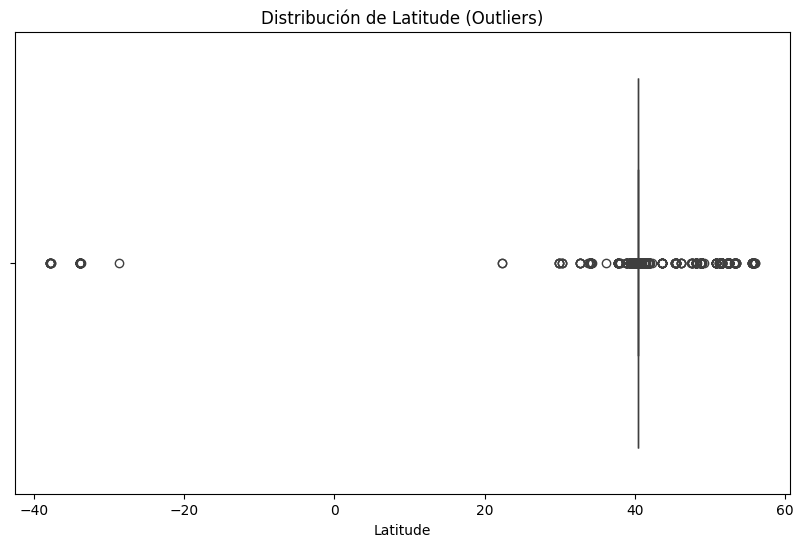

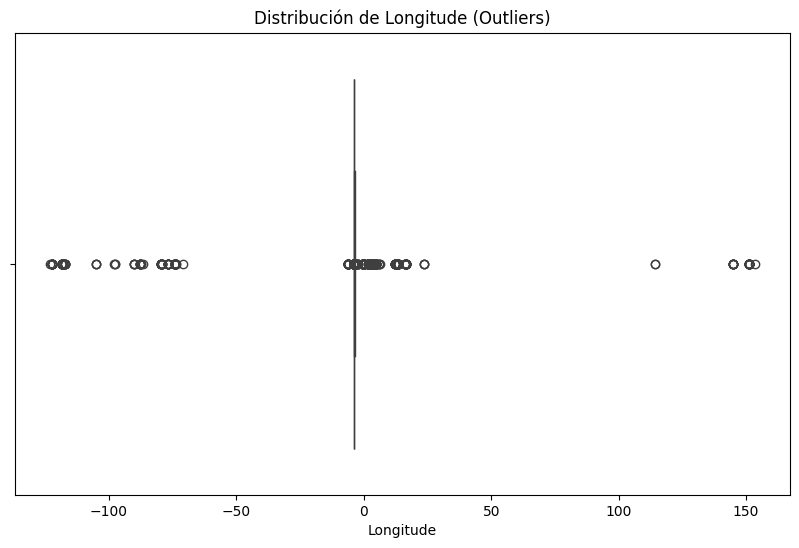

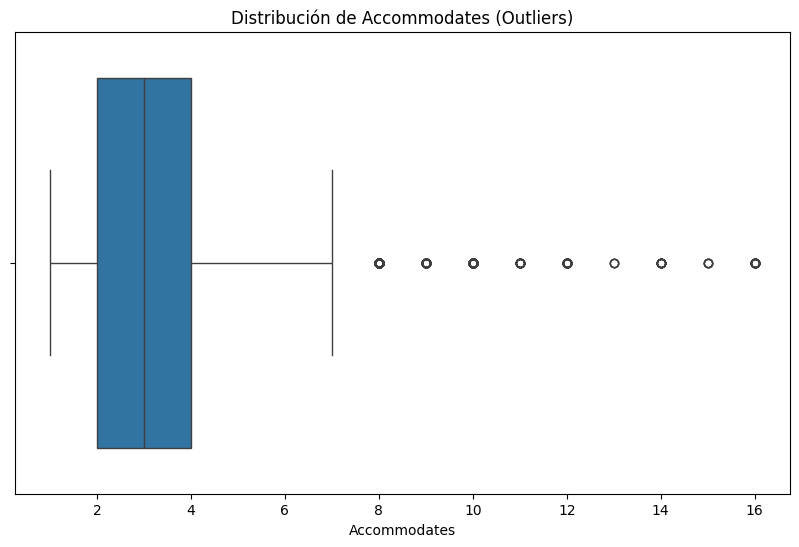

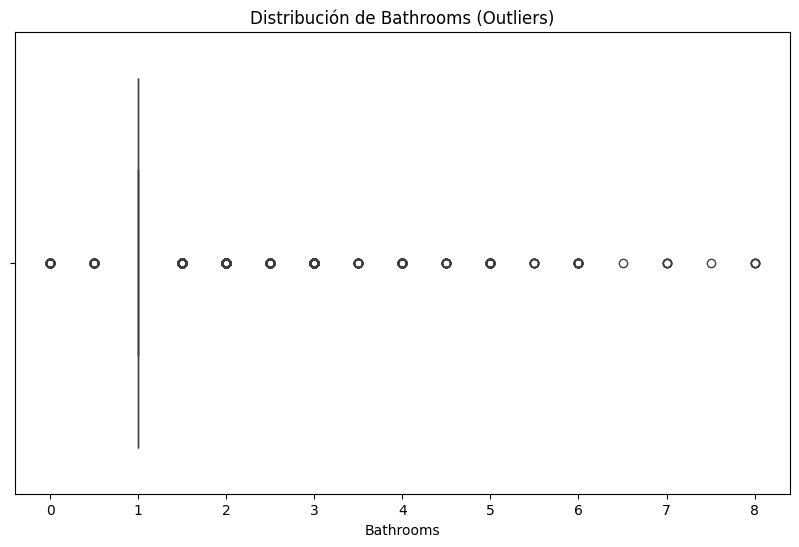

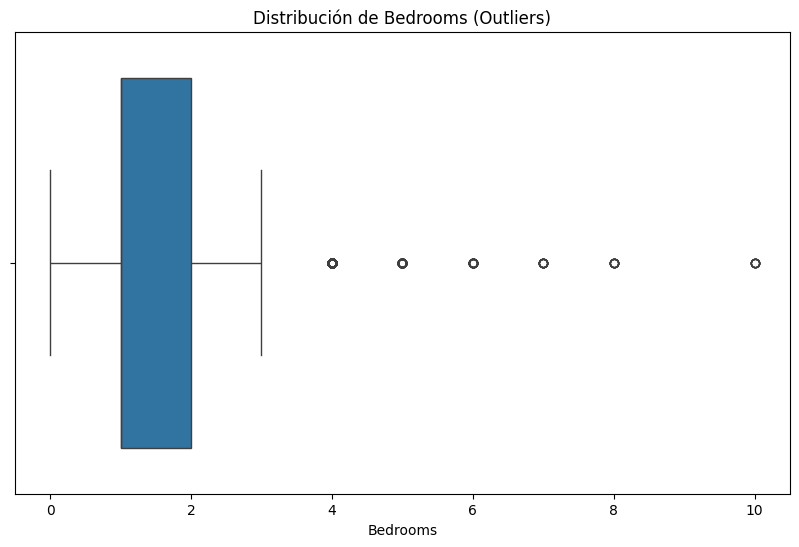

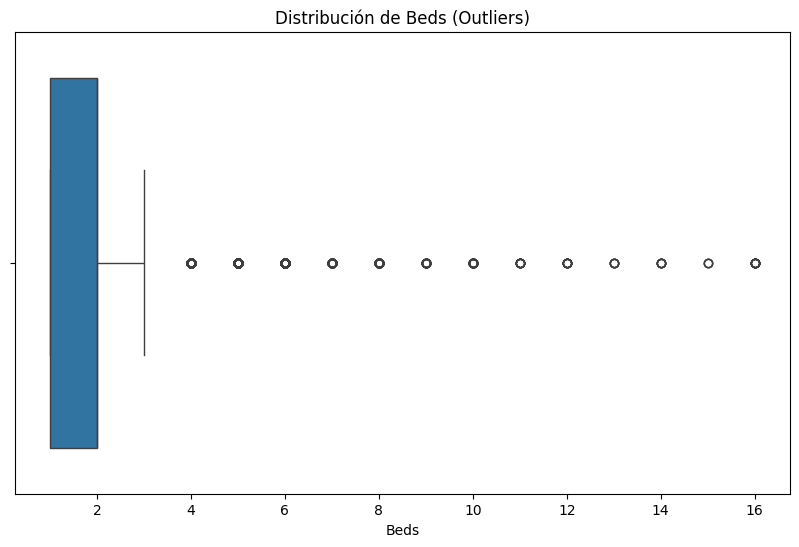

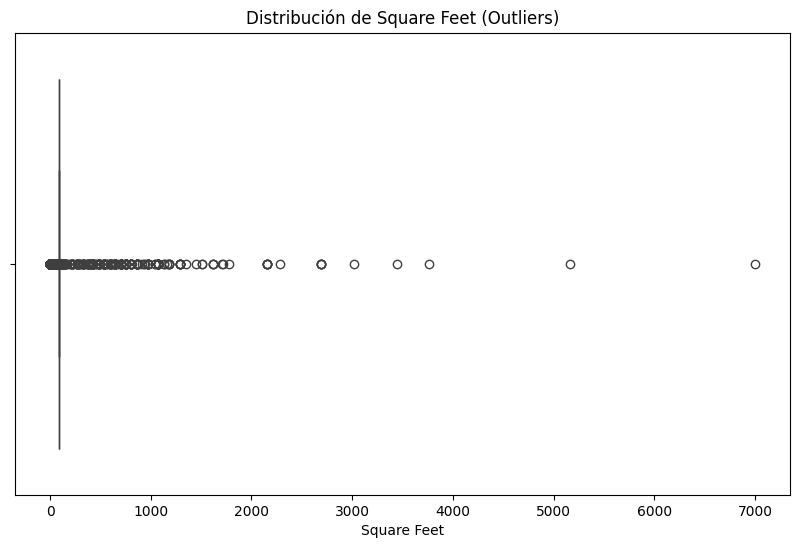

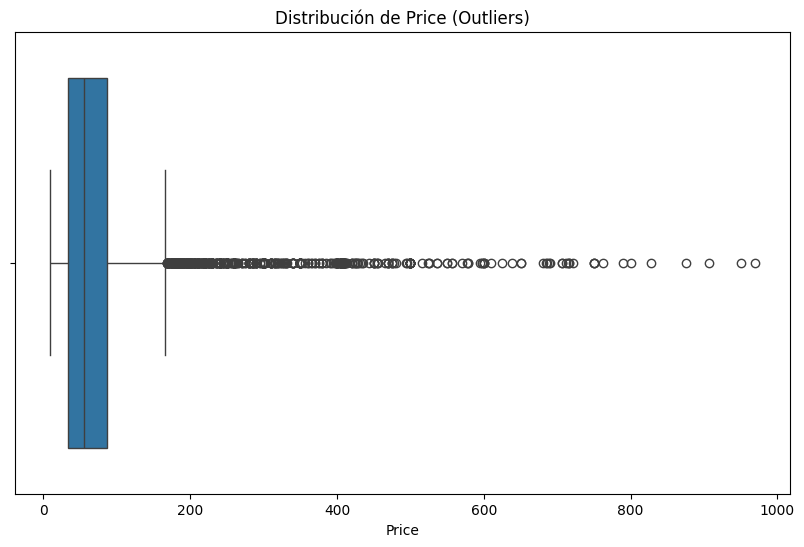

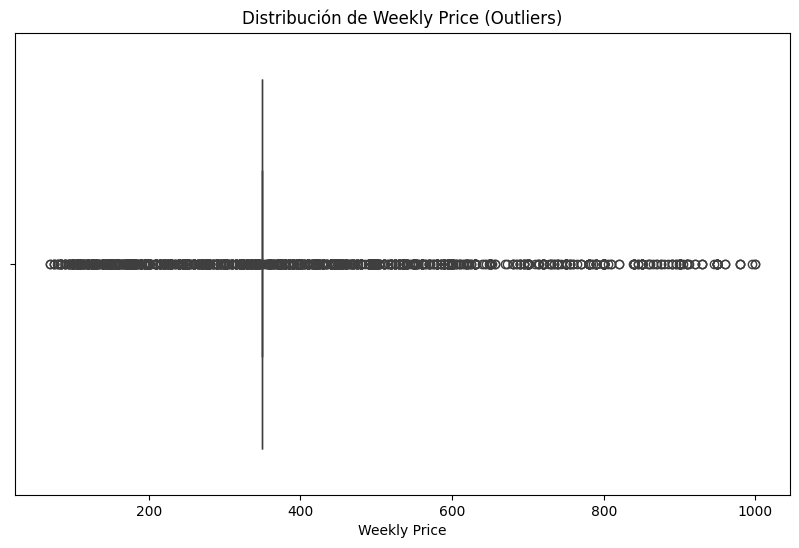

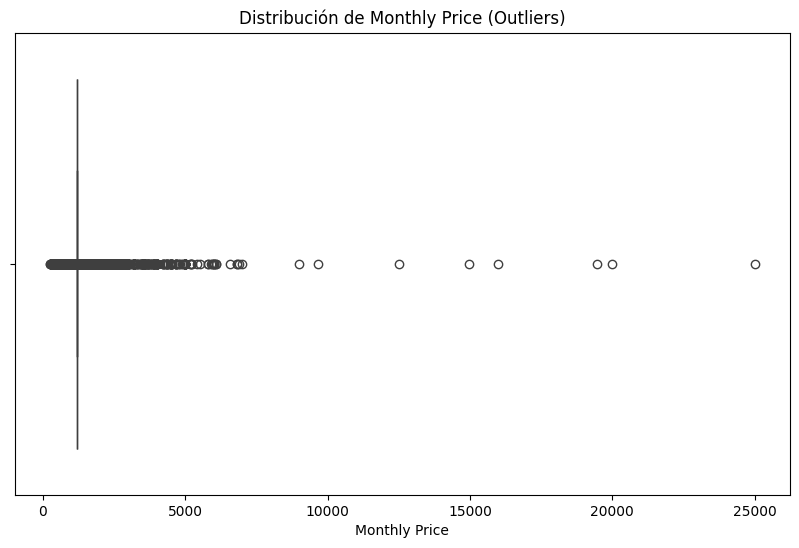

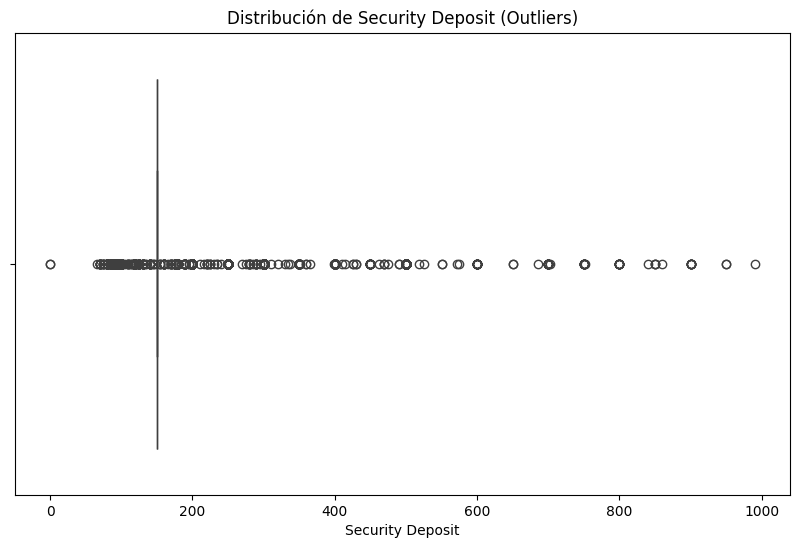

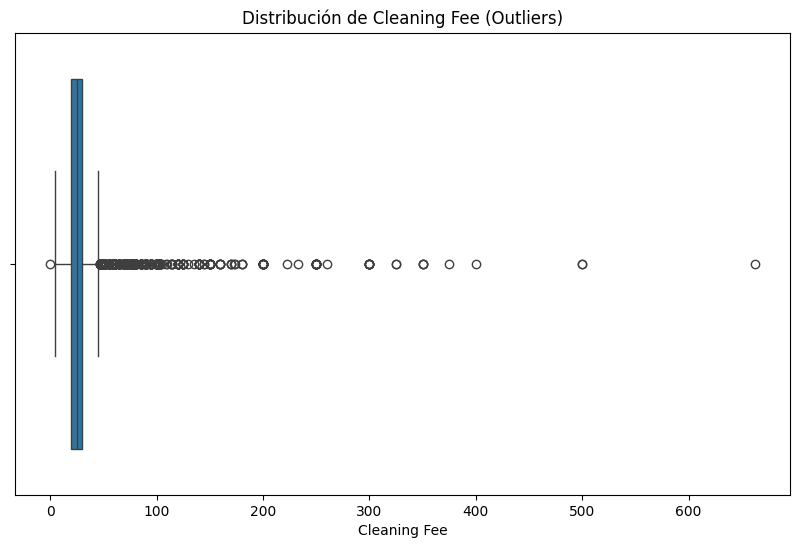

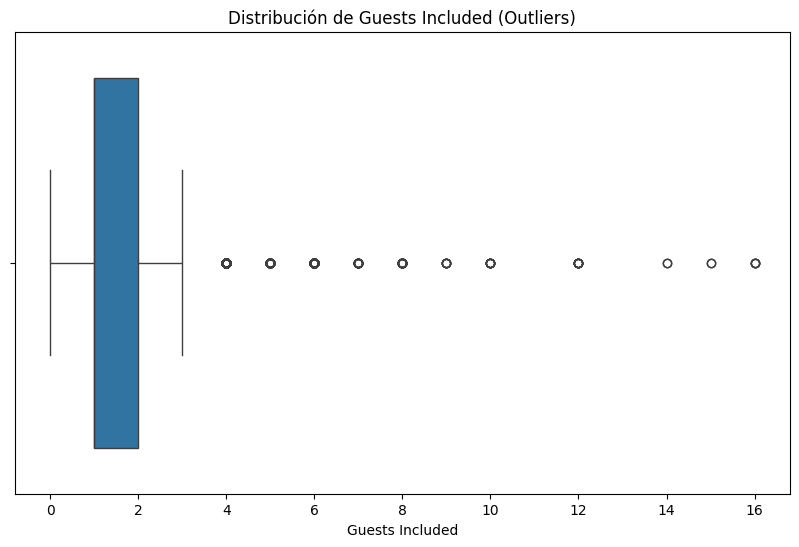

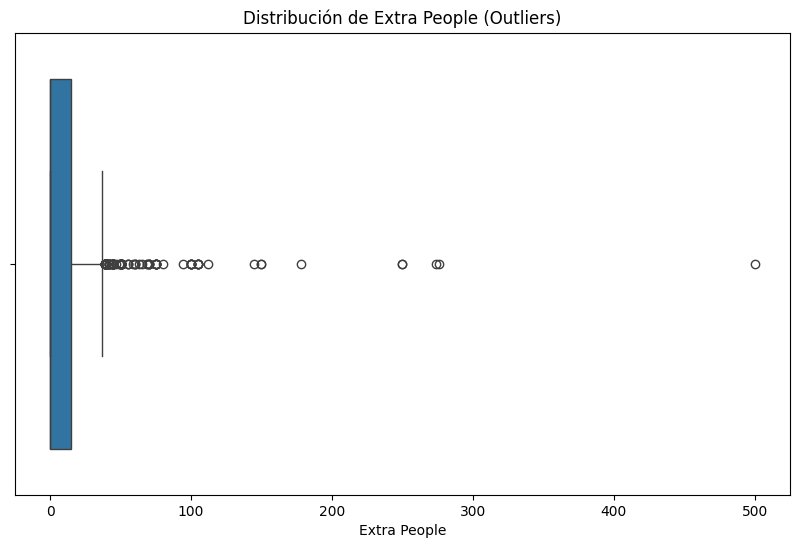

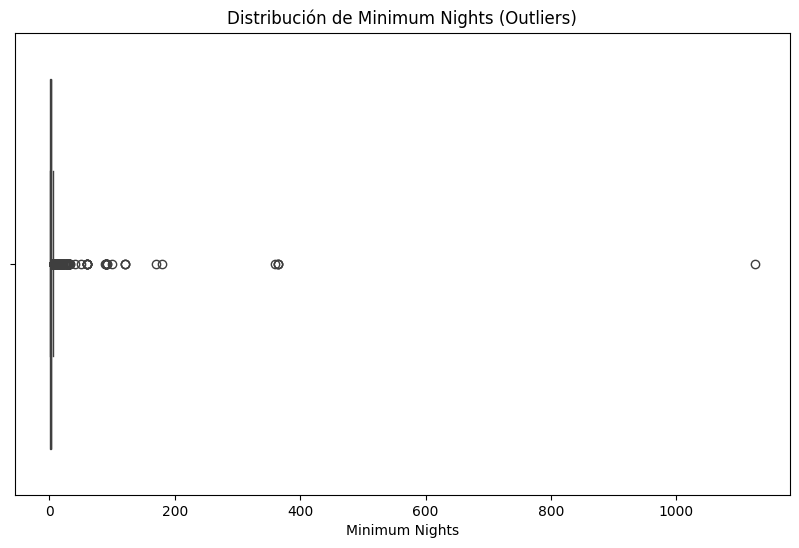

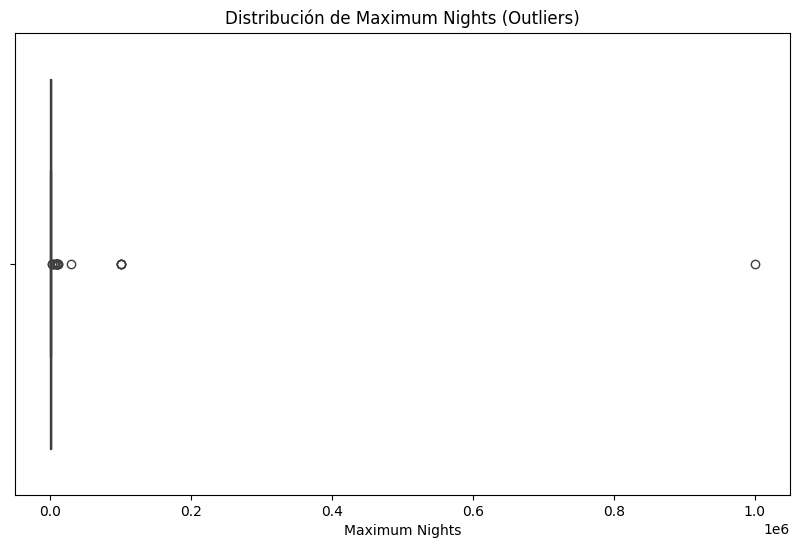

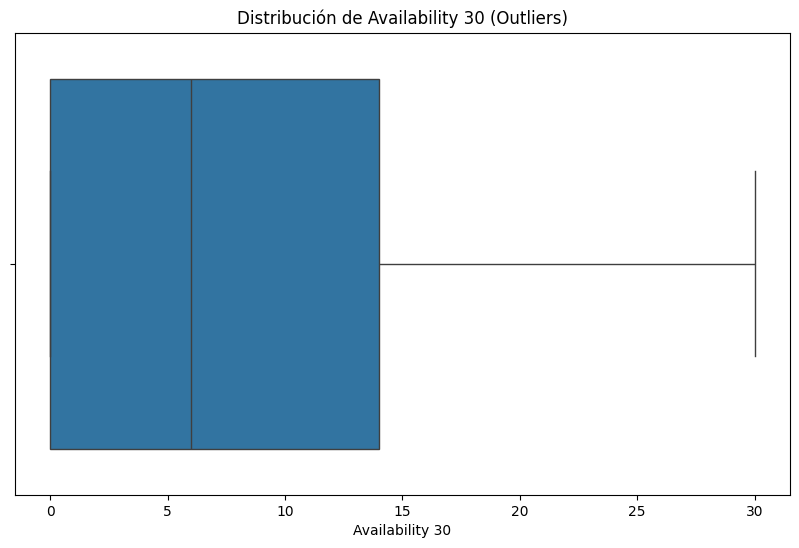

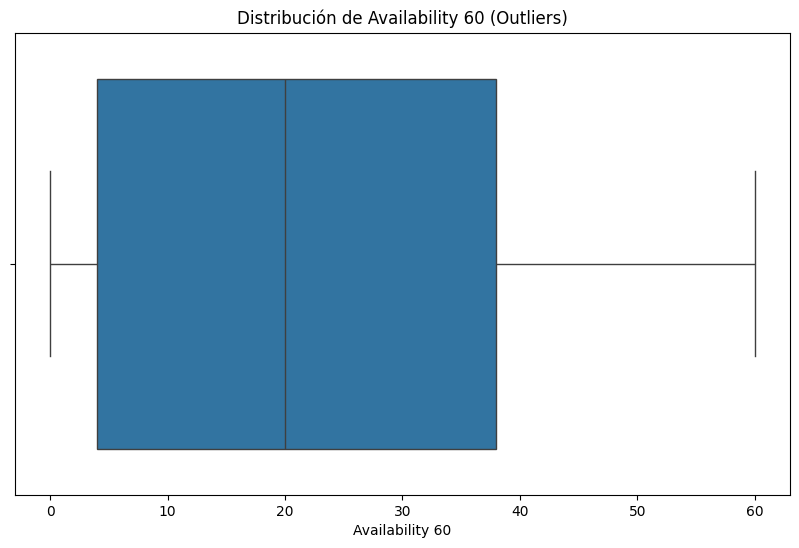

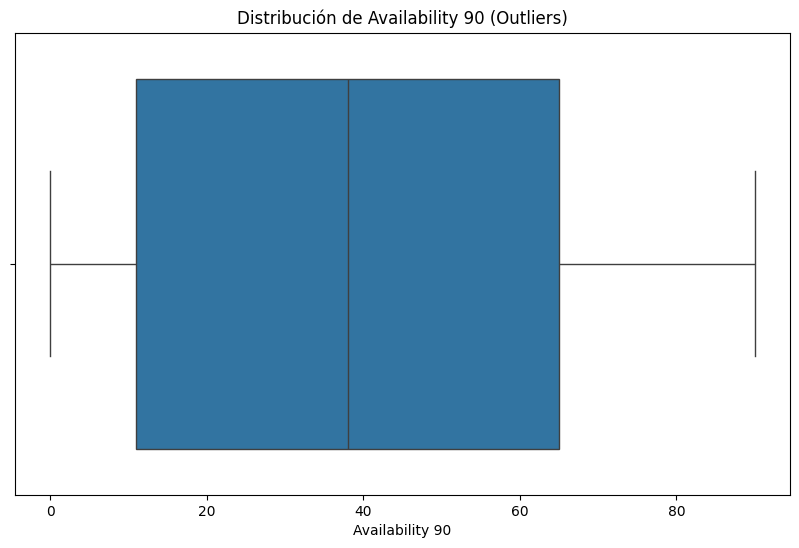

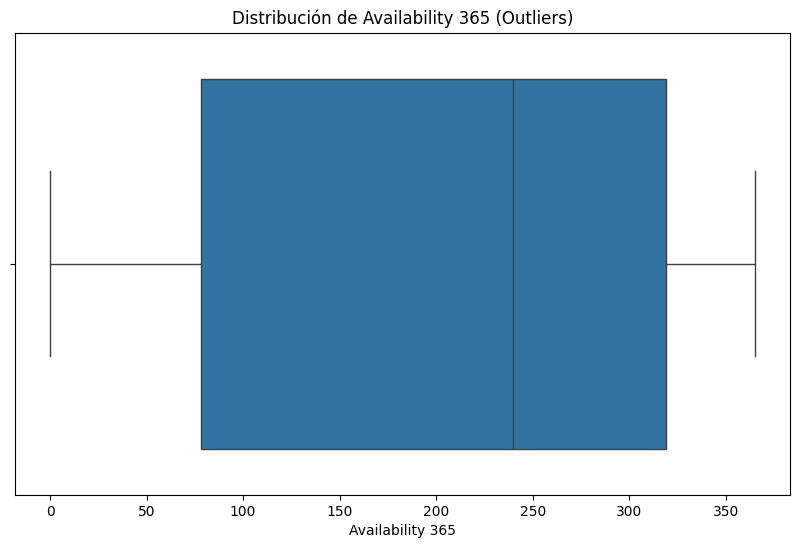

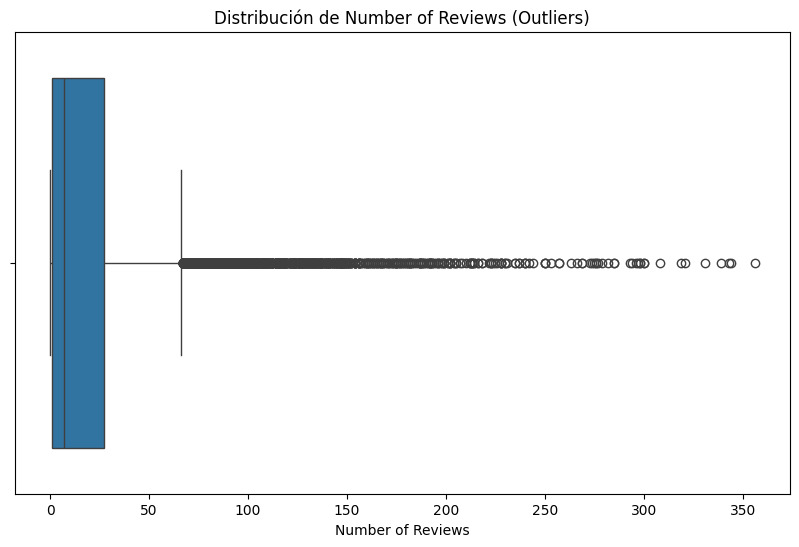

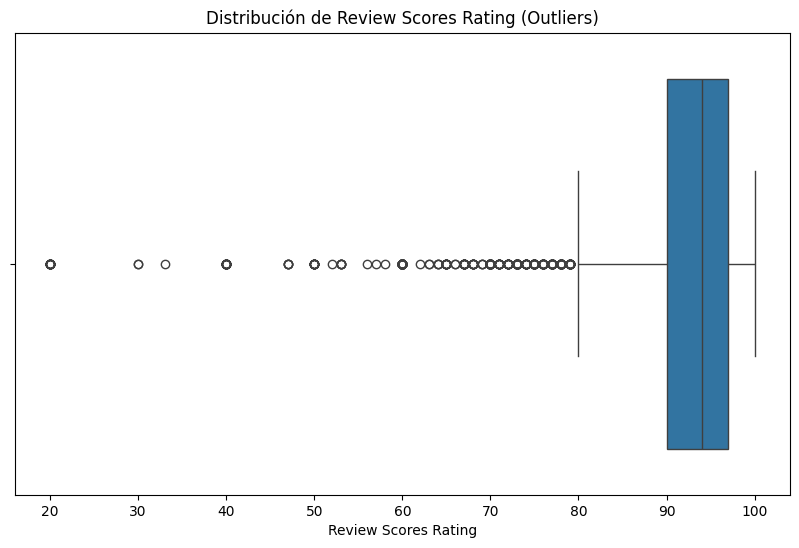

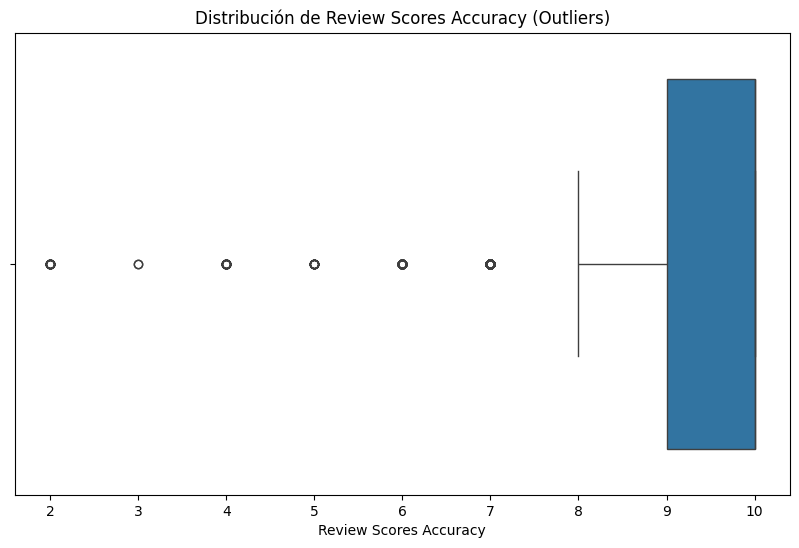

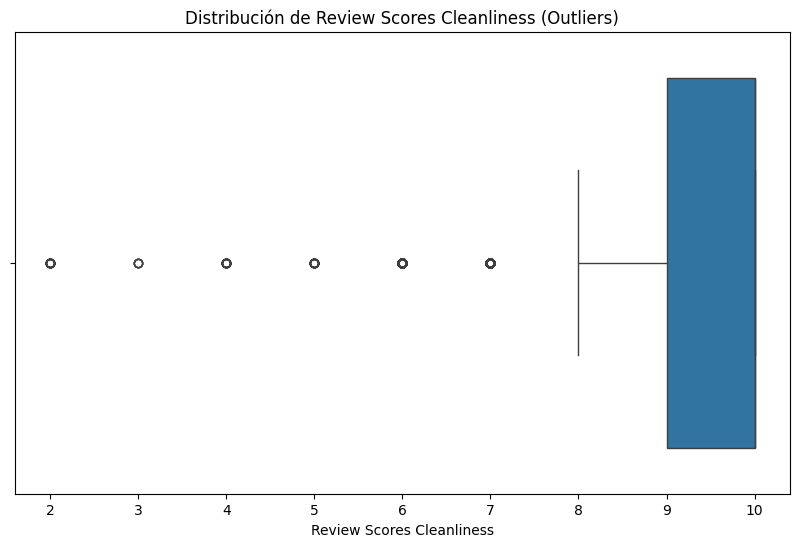

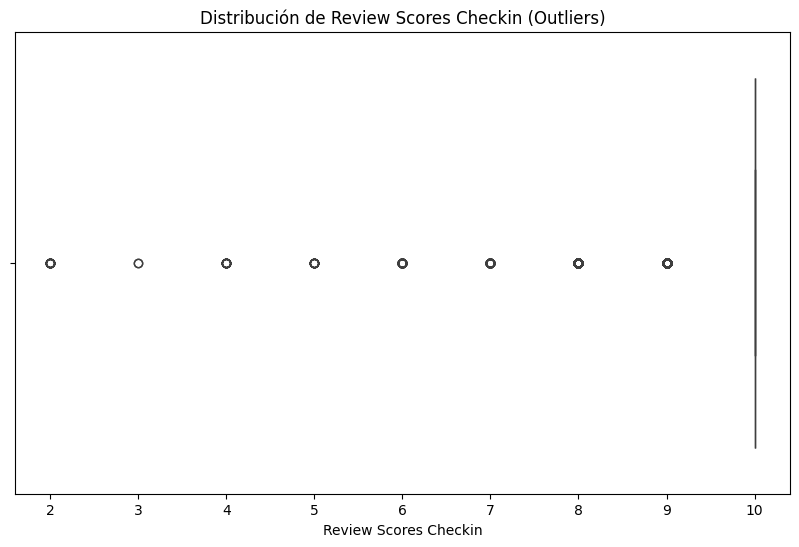

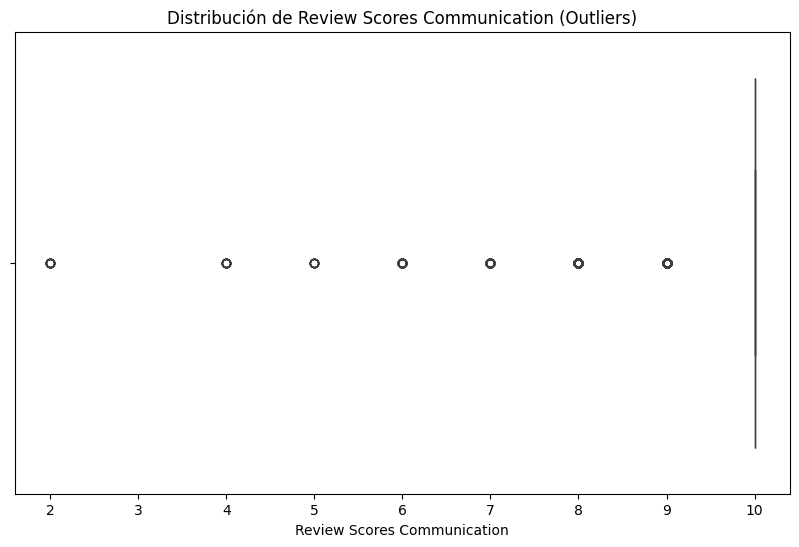

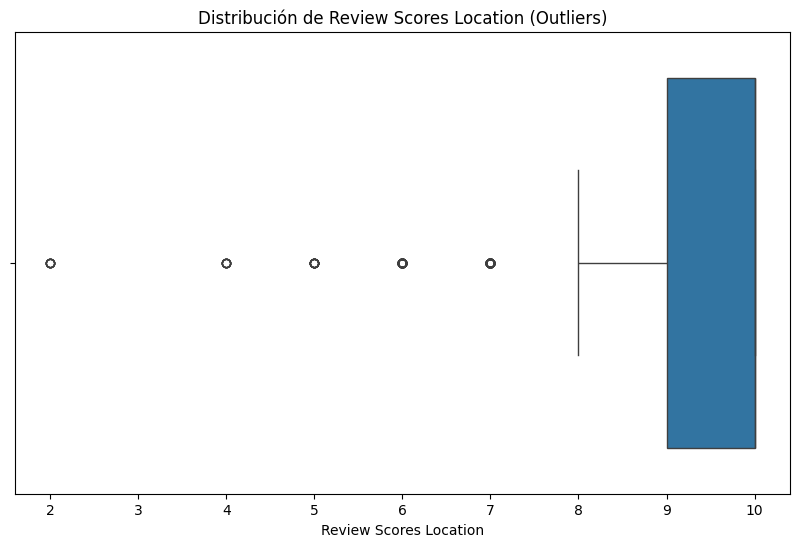

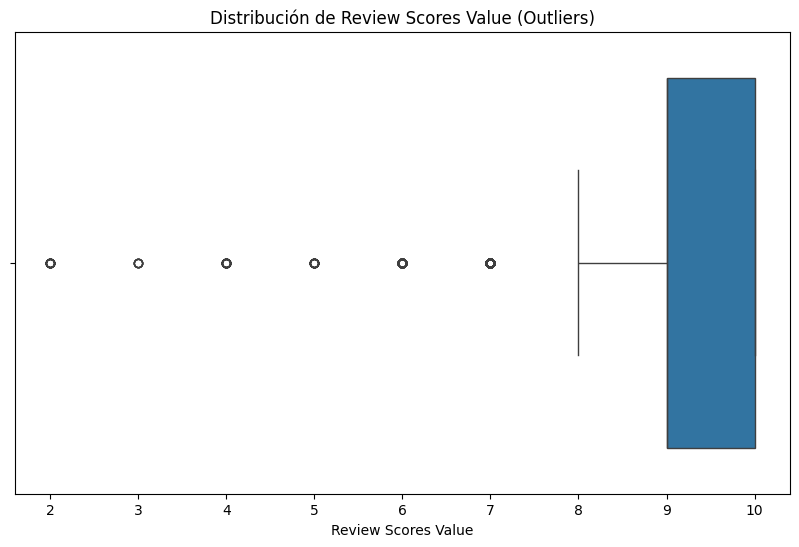

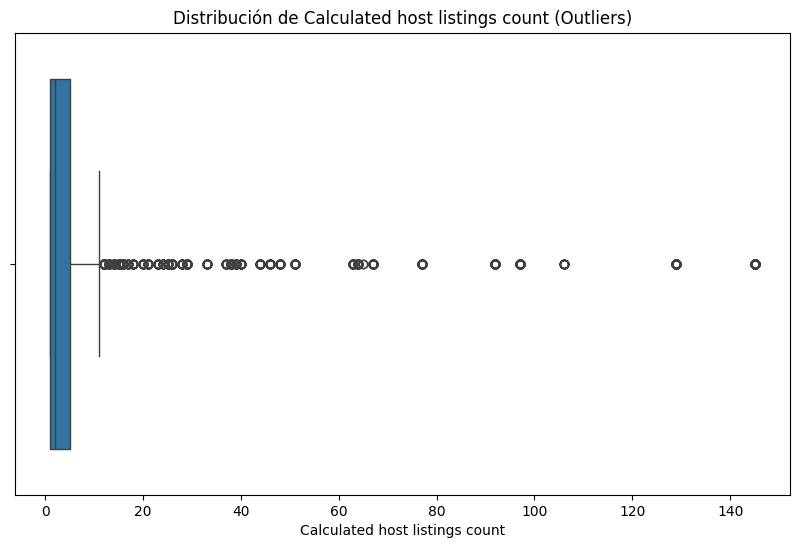

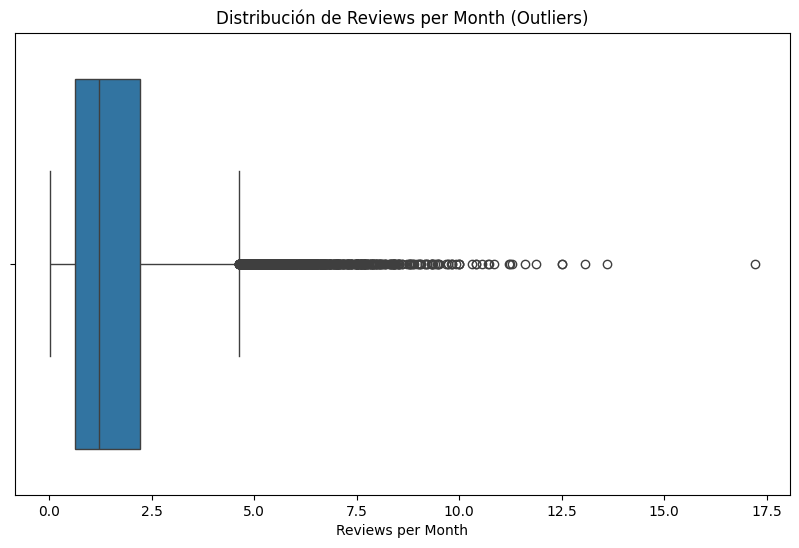

In [30]:
# Detección de outliers en otras variables numéricas
variables_numericas = airbnb_data.select_dtypes(include=np.number).columns
for variable in variables_numericas:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=airbnb_data, x=variable)
    plt.title(f'Distribución de {variable} (Outliers)')
    plt.show()

In [31]:
def tratar_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Imputar outliers con la mediana
    median_value = df[column].median()
    df[column] = np.where((df[column] < lower_limit) | (df[column] > upper_limit), median_value, df[column])

    return df

Ingeniería de Características
#####Pipelines:
#####Numéricas: Imputación con mediana + escalado estándar.
#####Categóricas: Imputación con moda + codificación OneHot.
Selección de Características:
#####Uso de LassoCV para identificar las características más importantes.
#####Eliminación de variables altamente correlacionadas para evitar redundancias.

In [32]:
# Aplicar el tratamiento a todas las columnas numéricas
variables_numericas = airbnb_data_imputado.select_dtypes(include=np.number).columns

for variable in variables_numericas:
    airbnb_data_imputado = tratar_outliers(airbnb_data_imputado, variable)

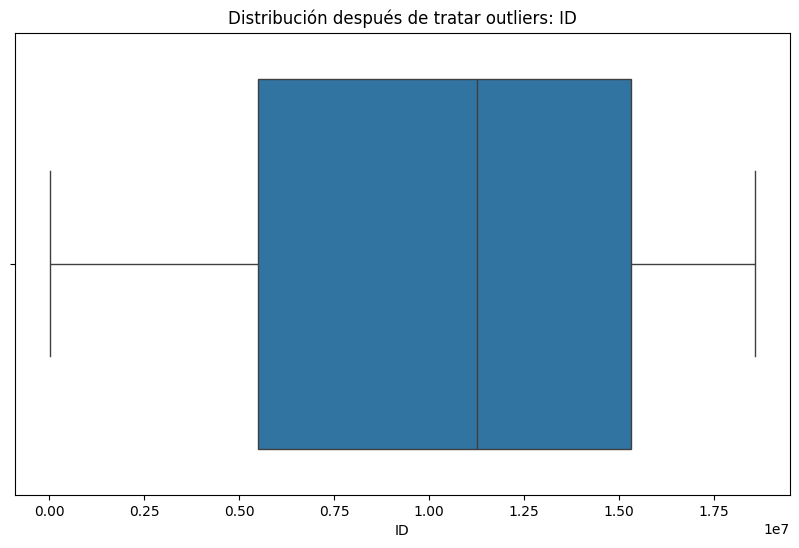

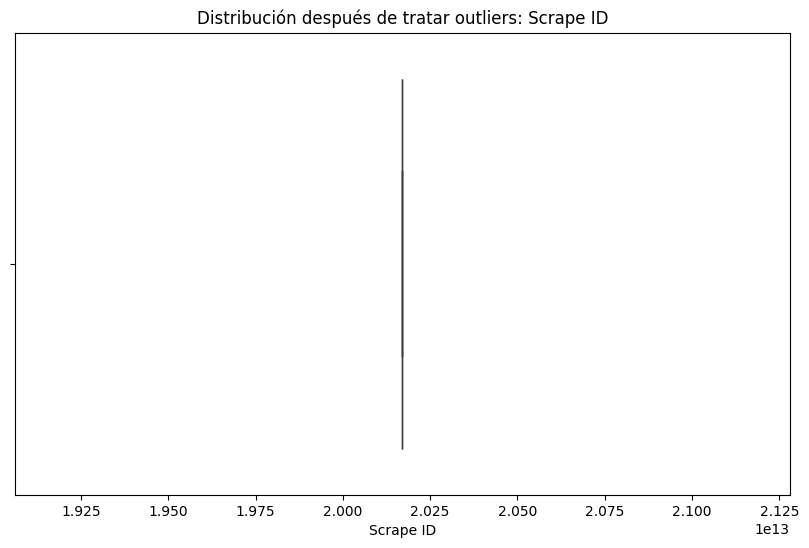

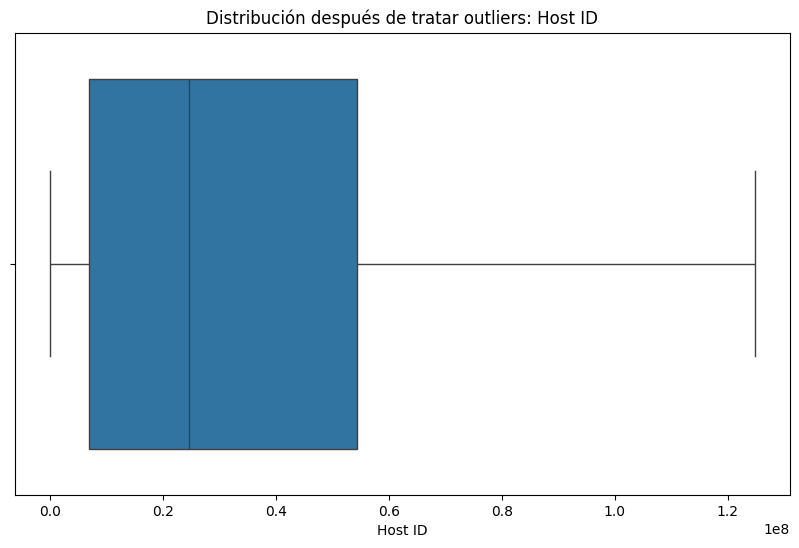

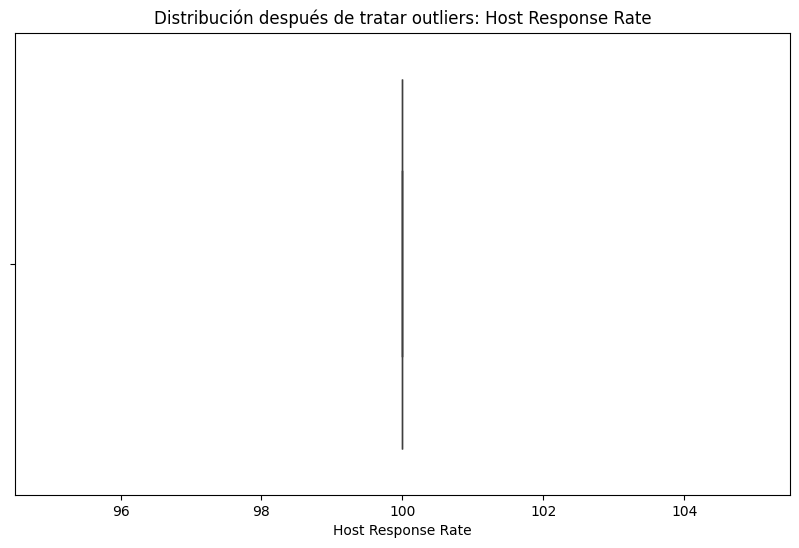

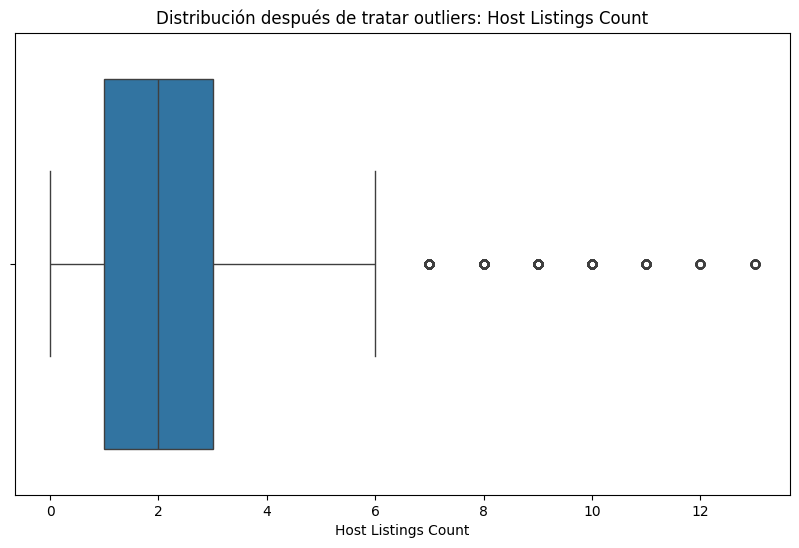

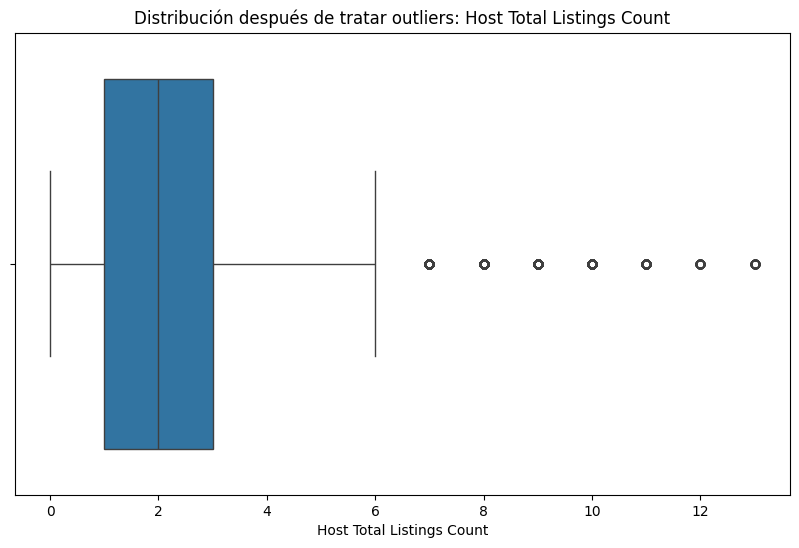

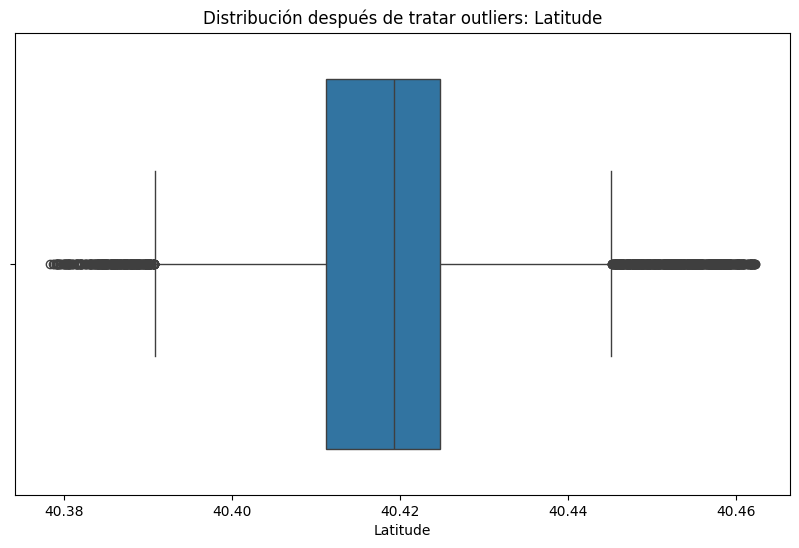

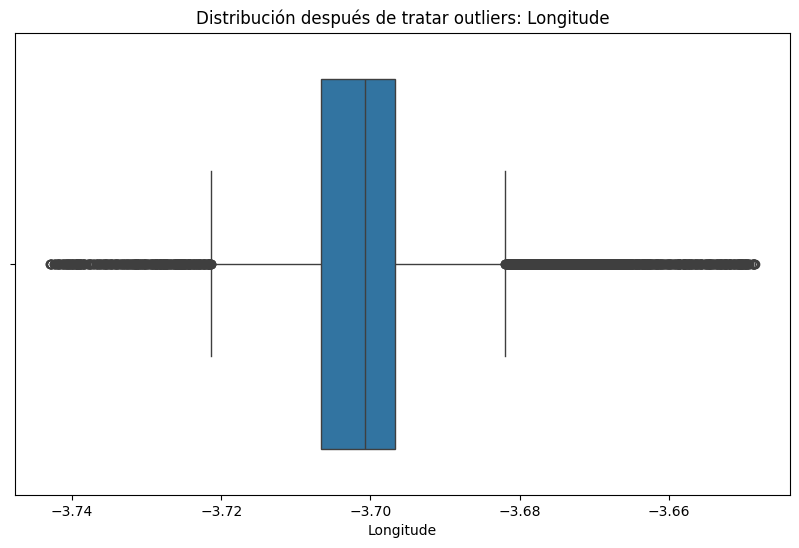

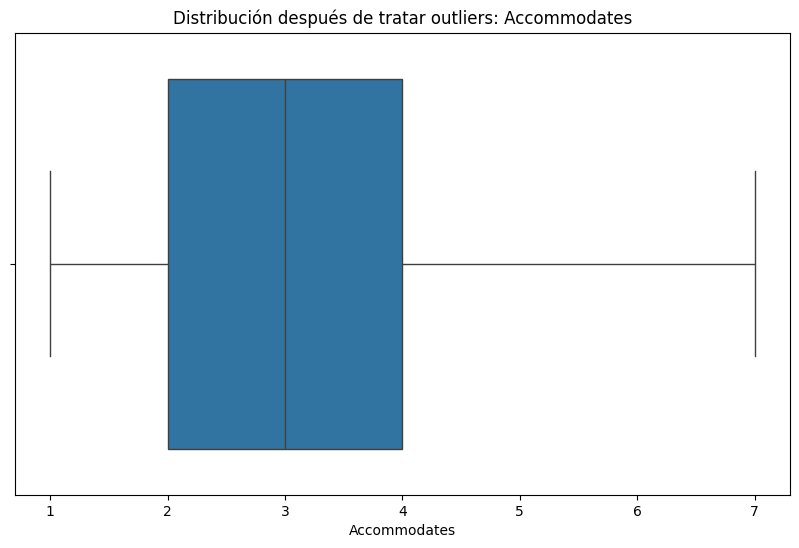

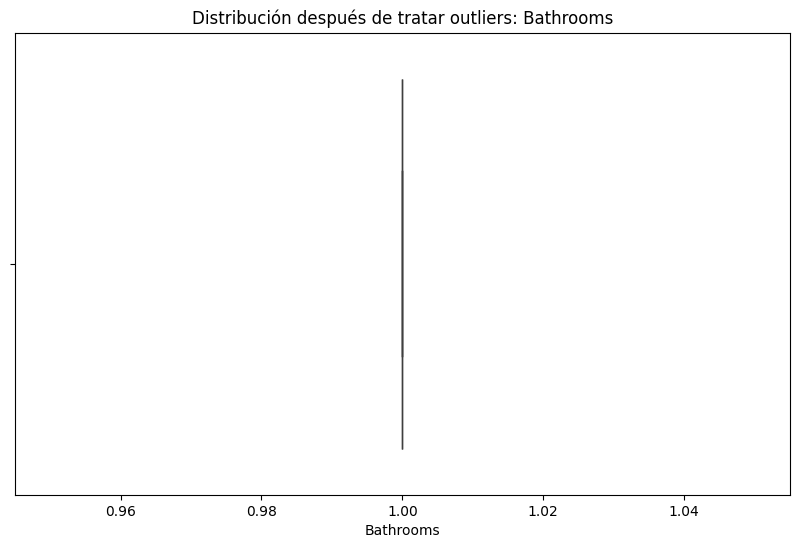

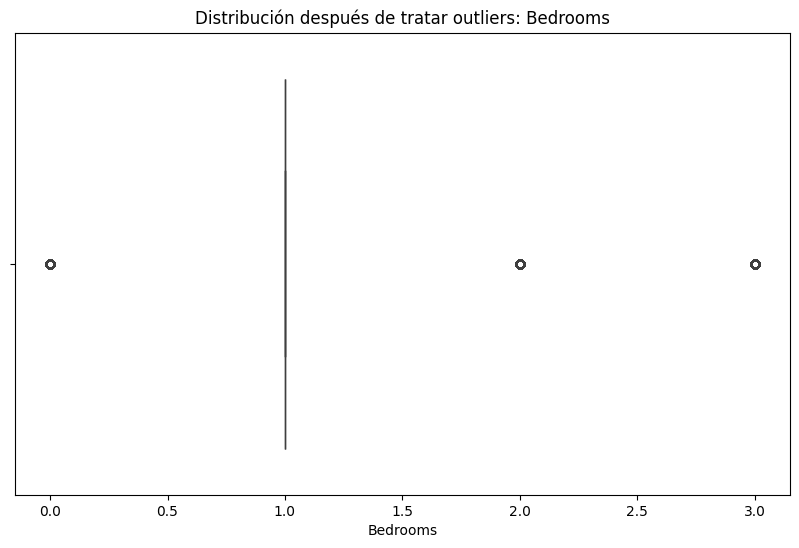

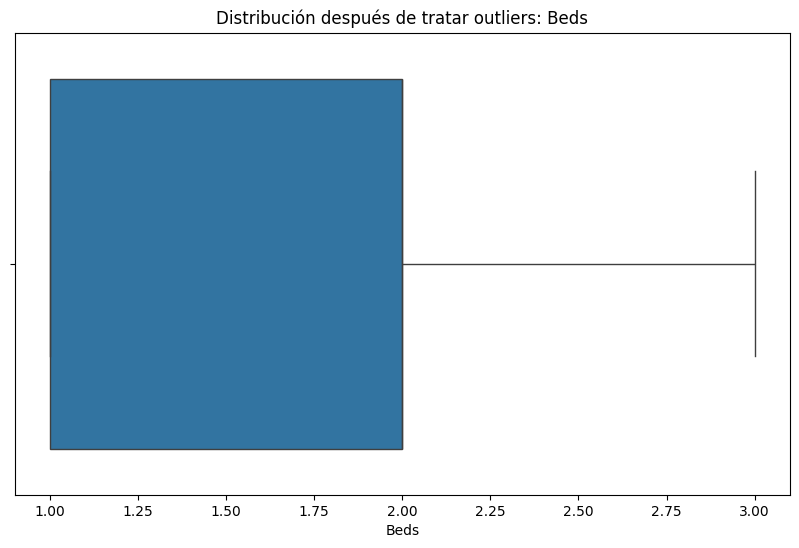

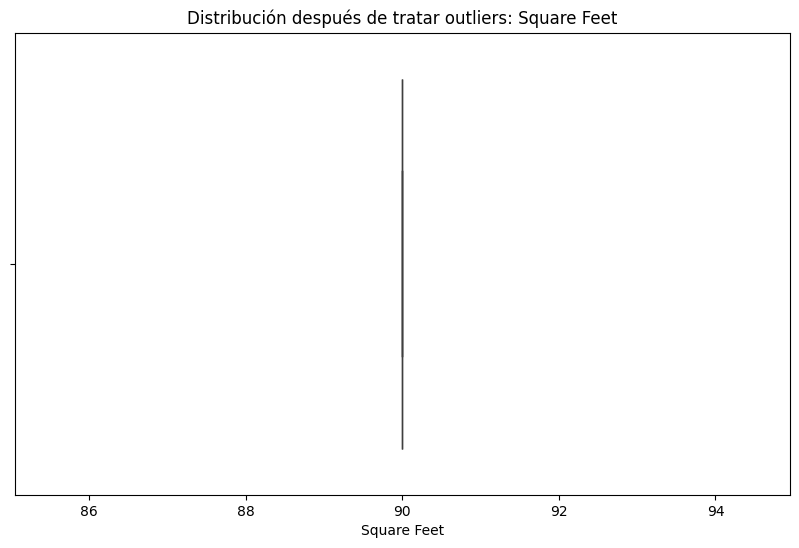

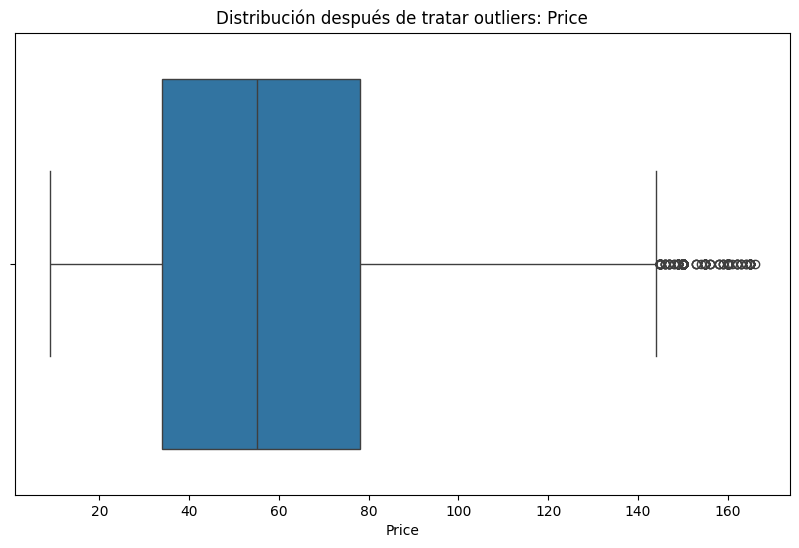

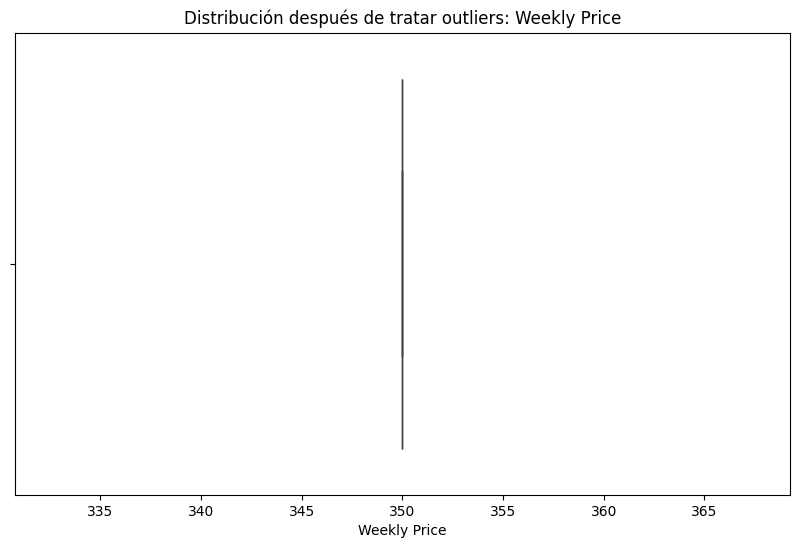

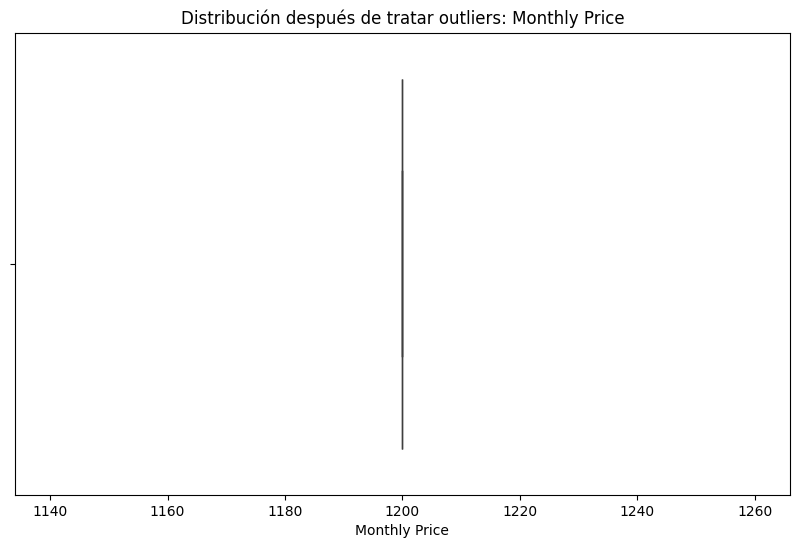

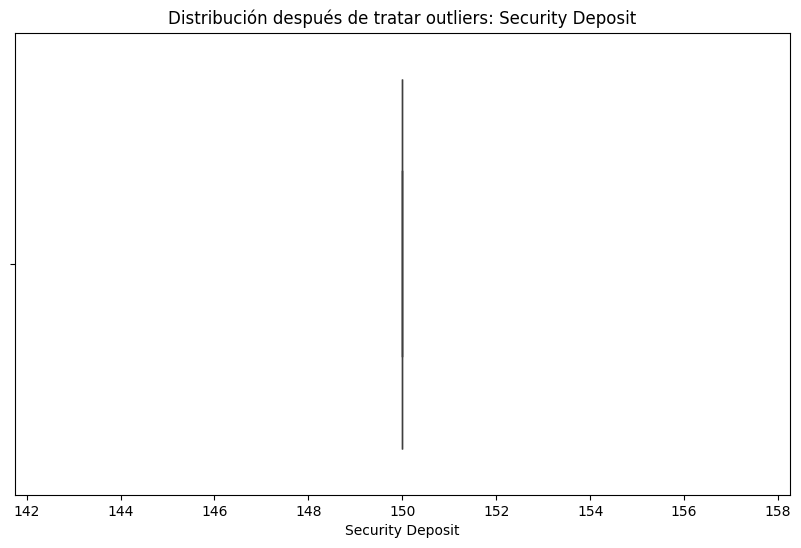

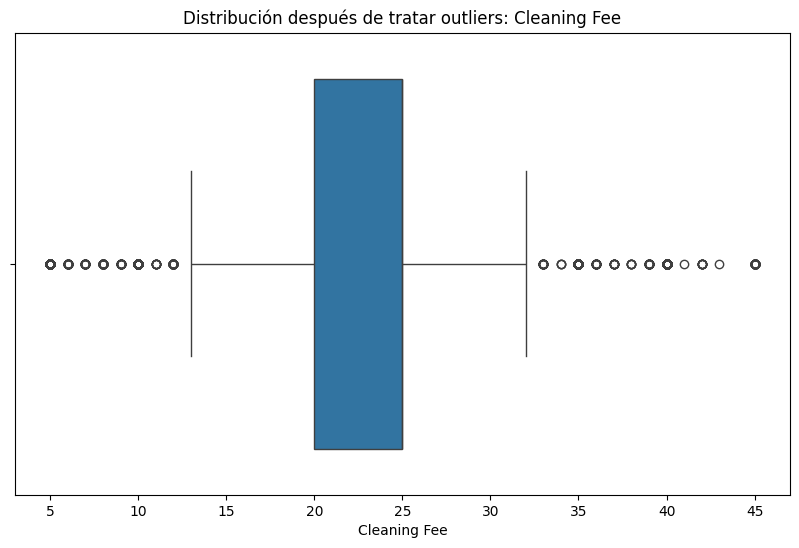

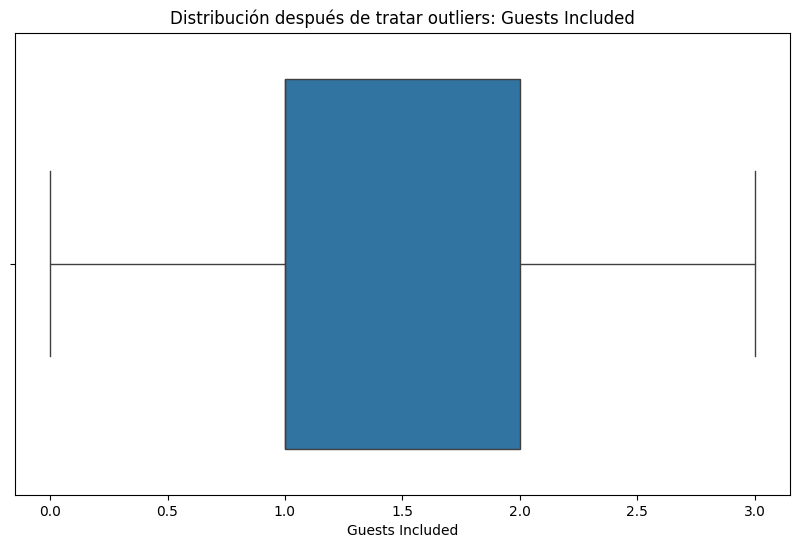

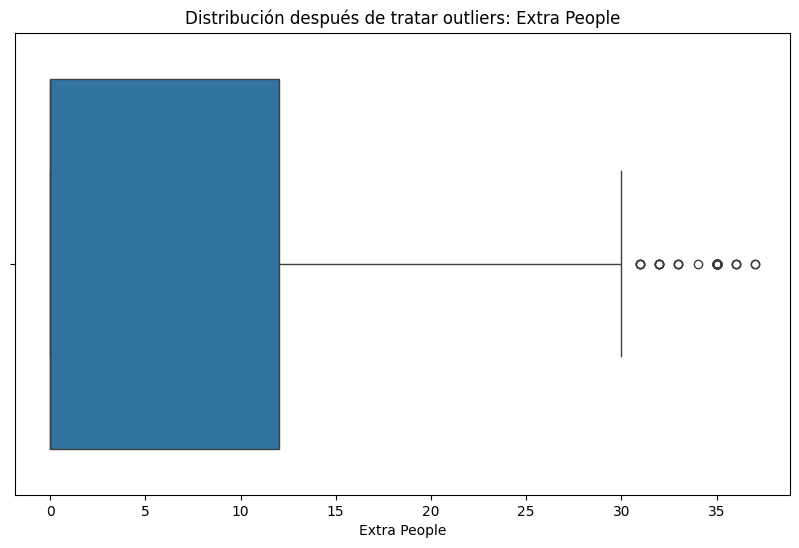

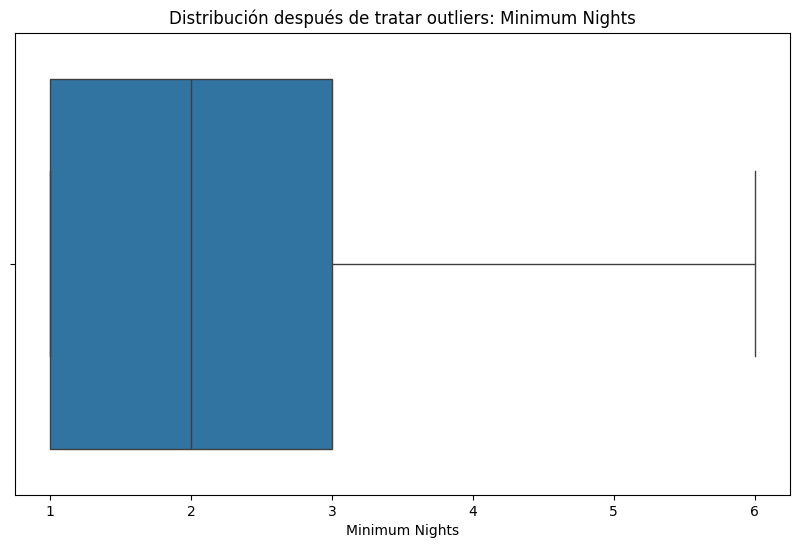

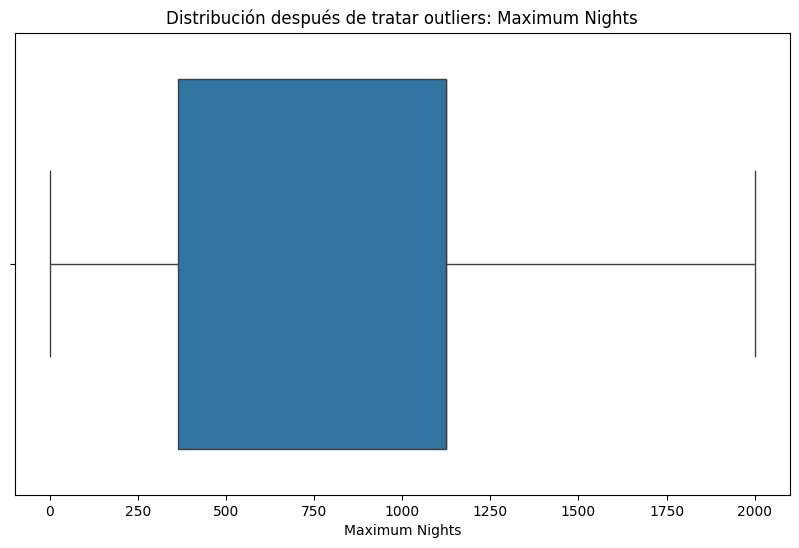

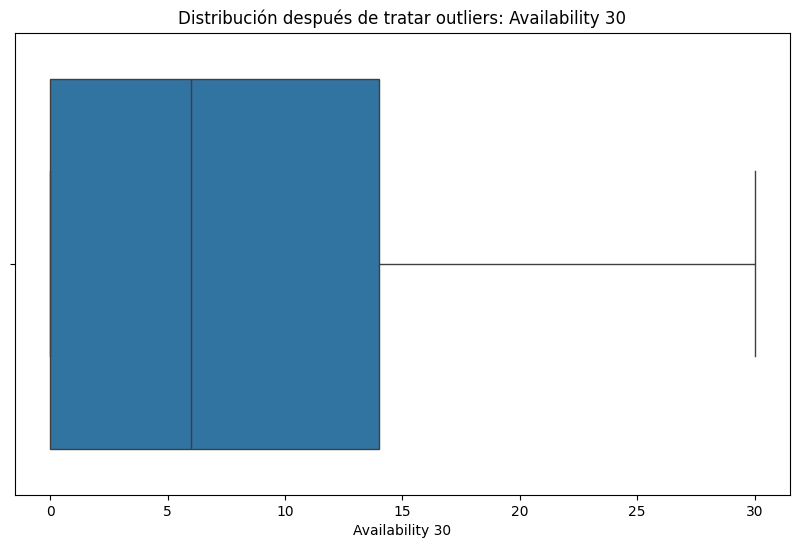

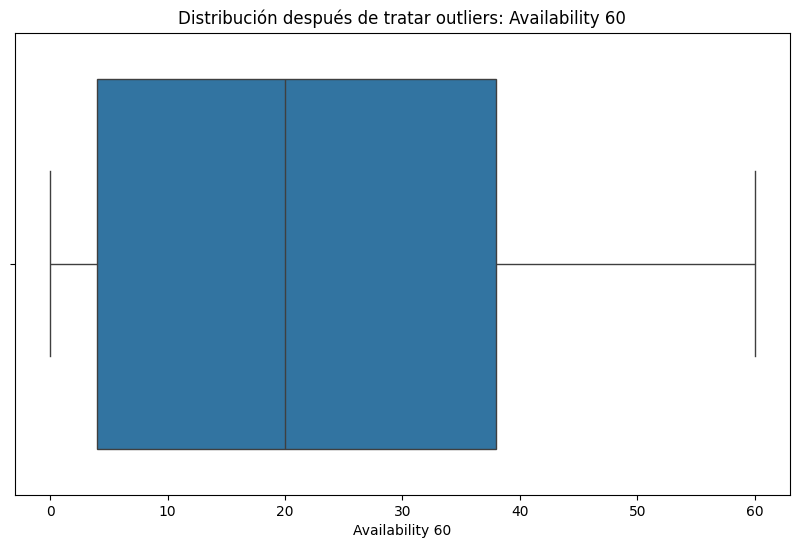

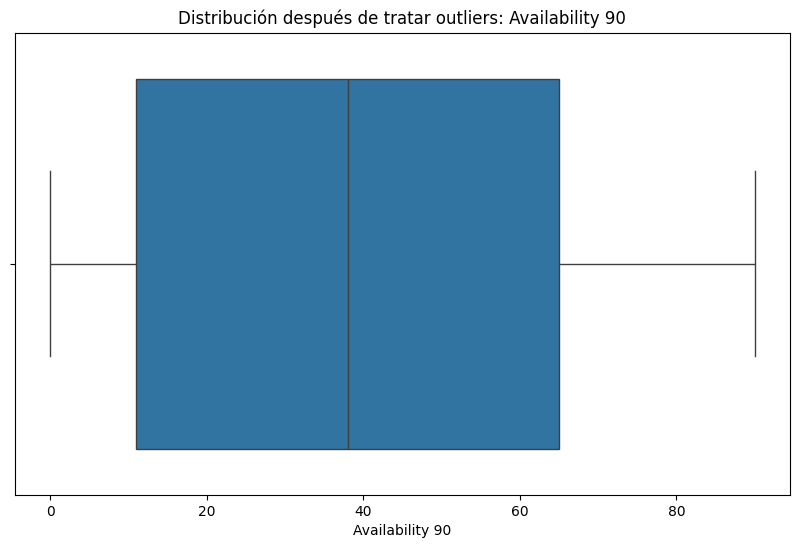

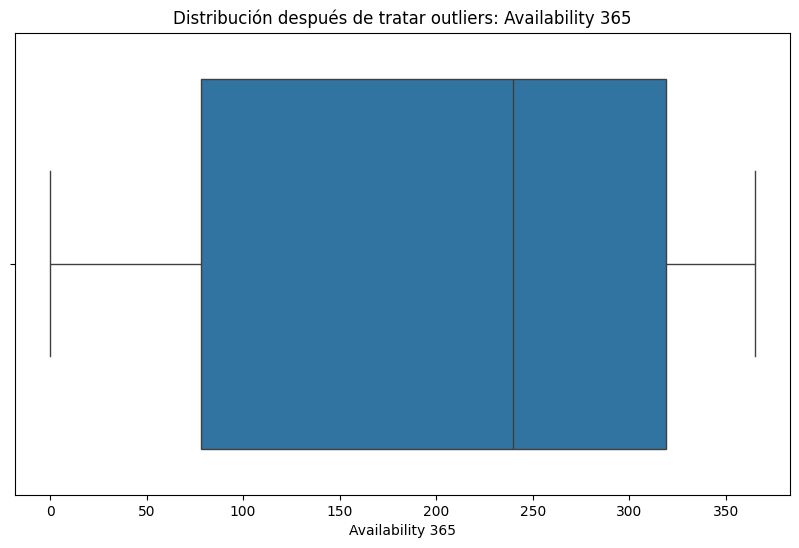

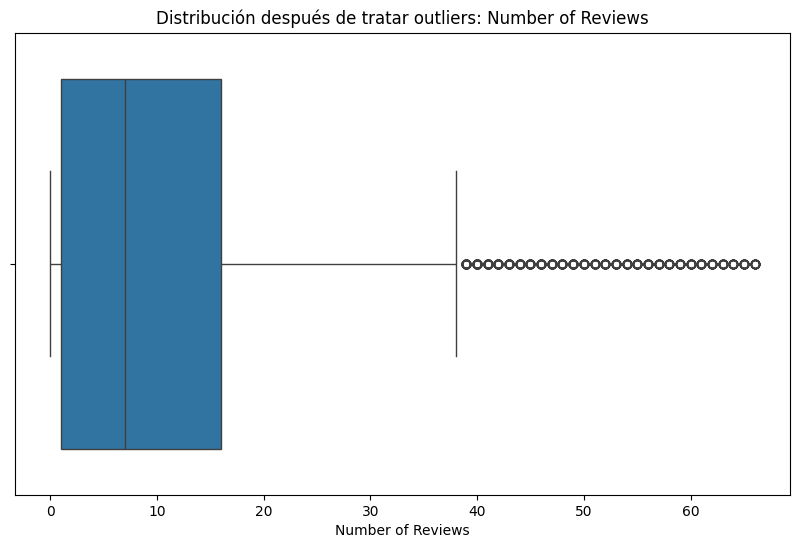

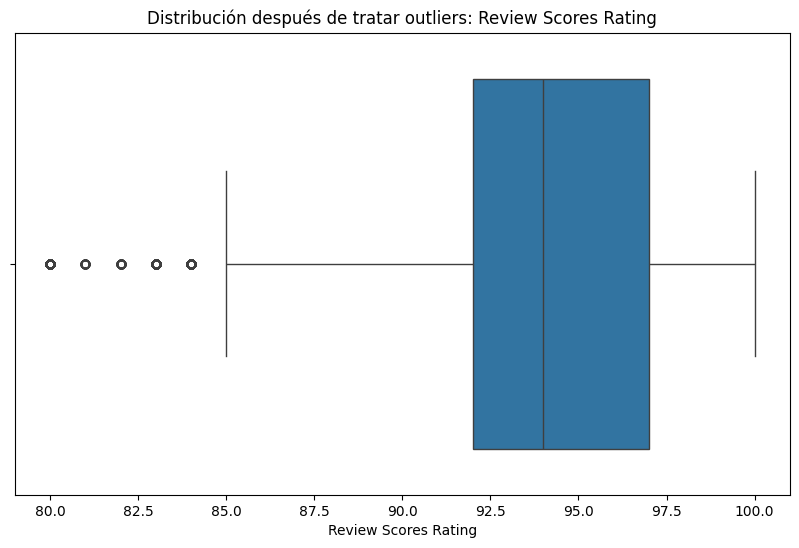

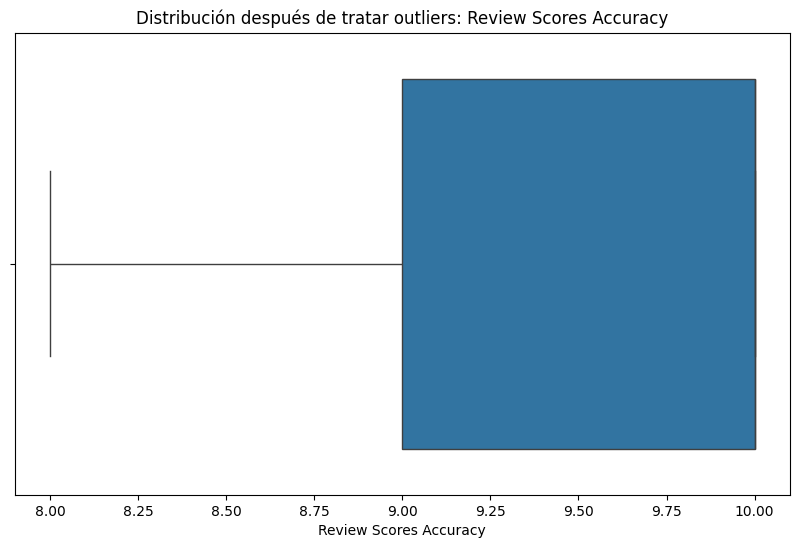

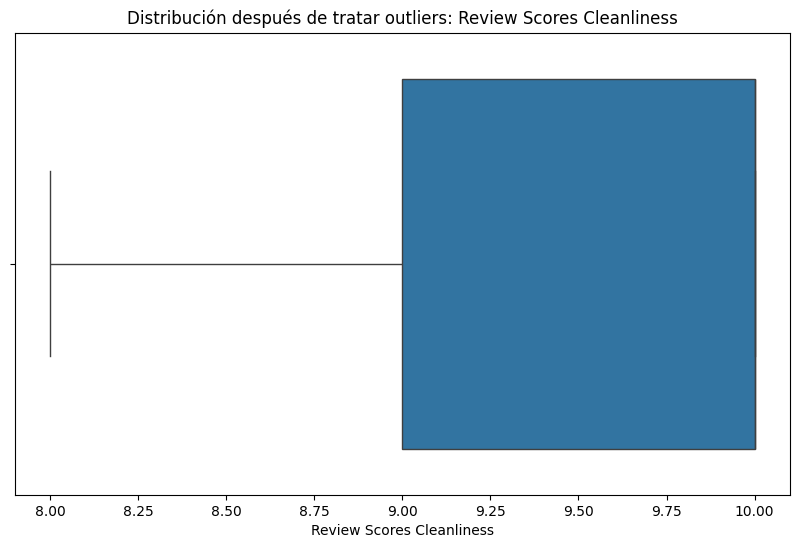

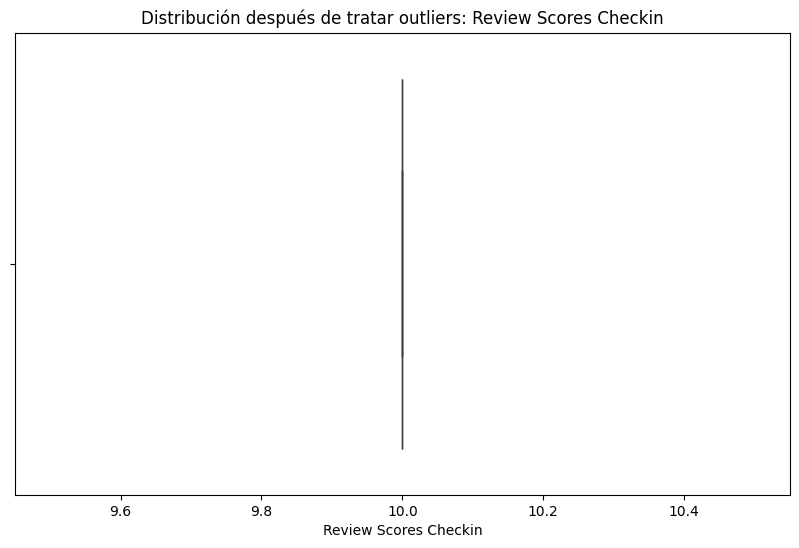

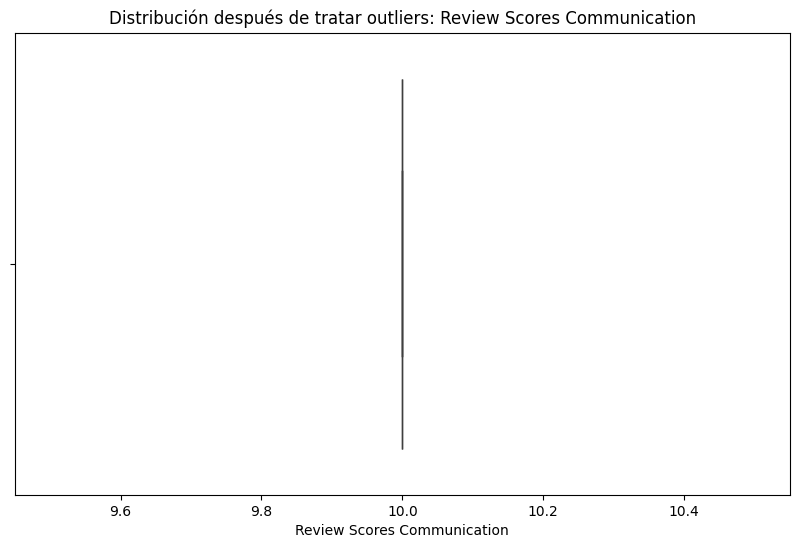

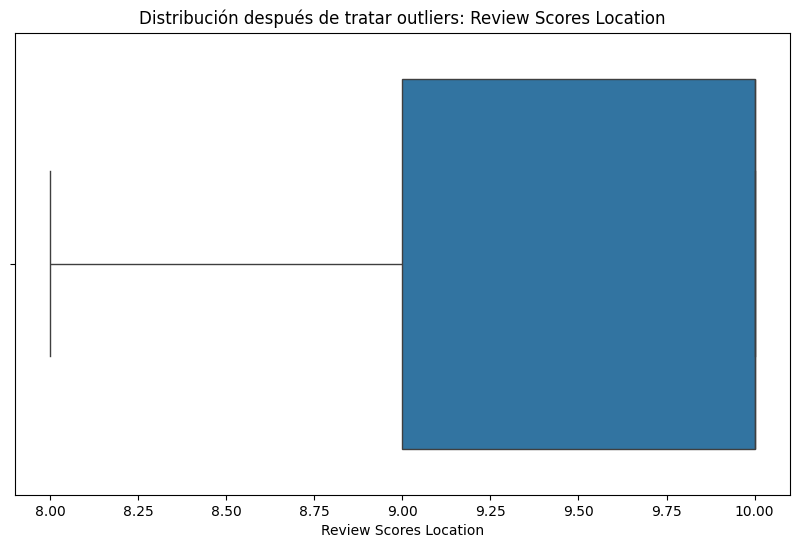

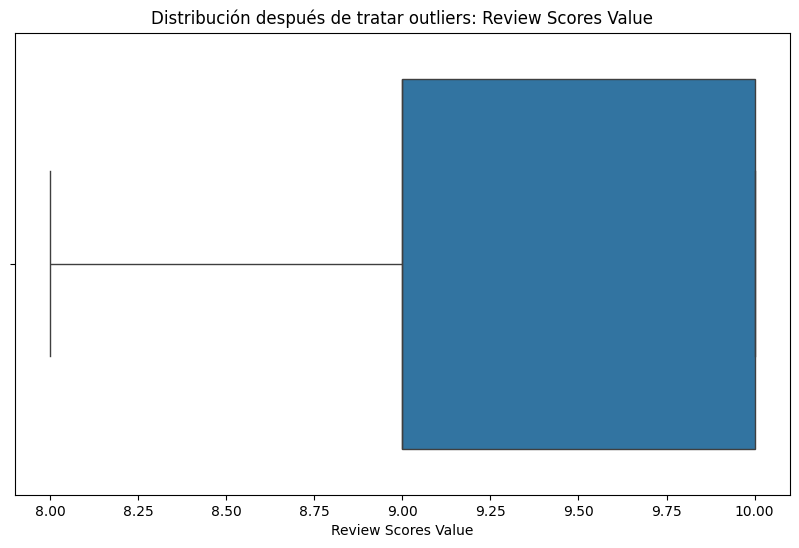

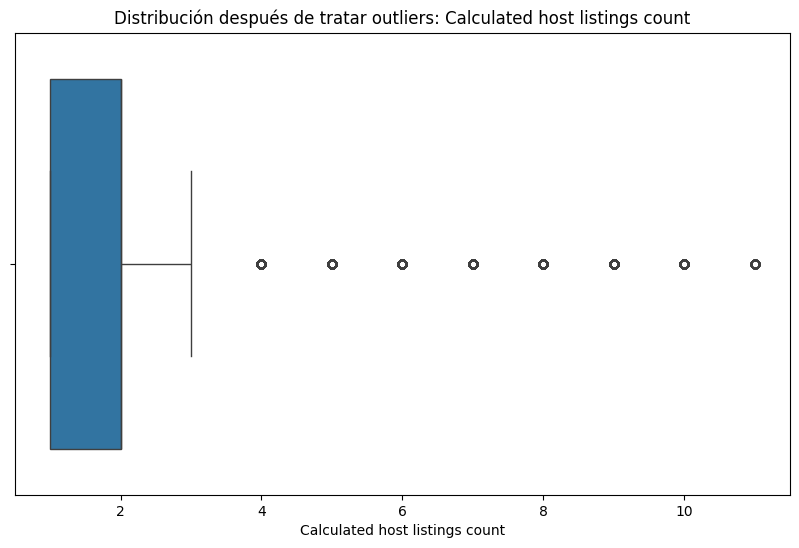

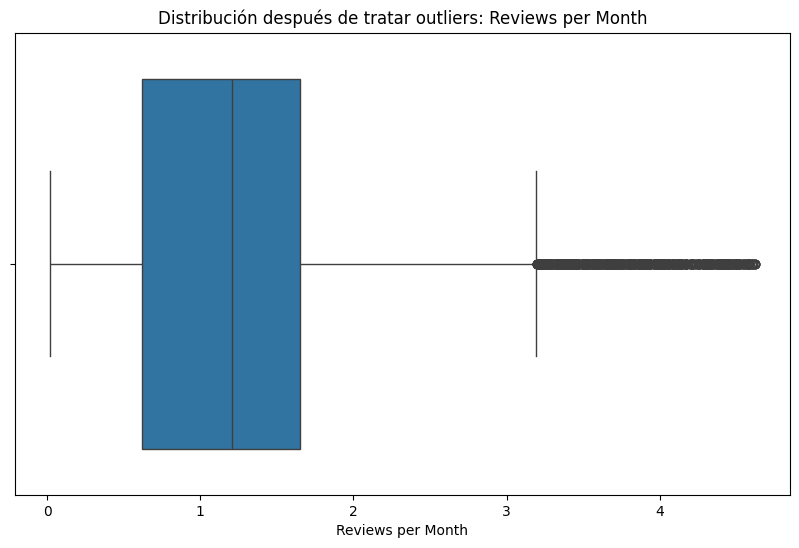

In [33]:
# Verificar la distribución después de tratamiento
for variable in variables_numericas:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=airbnb_data_imputado, x=variable)
    plt.title(f'Distribución después de tratar outliers: {variable}')
    plt.show()

In [34]:
# Variables numéricas y objetivo
variables_numericas = airbnb_data_imputado.select_dtypes(include=['number'])
target_variable = 'Price'

In [35]:
# Matriz de correlación entre variables explicativas y la variable objetivo
correlation_with_target = variables_numericas.corr()[target_variable].sort_values(ascending=False)
print("Correlación con la variable objetivo (Price):")
print(correlation_with_target)

Correlación con la variable objetivo (Price):
Price                             1.000000
Accommodates                      0.565163
Beds                              0.403501
Bedrooms                          0.377362
Cleaning Fee                      0.328126
Guests Included                   0.210463
Minimum Nights                    0.201163
Extra People                      0.125098
Review Scores Location            0.110400
Latitude                          0.093146
Host Total Listings Count         0.082949
Host Listings Count               0.082949
Calculated host listings count    0.063091
Review Scores Accuracy            0.051397
Review Scores Cleanliness         0.050882
Maximum Nights                    0.049345
Availability 365                  0.043439
Review Scores Rating              0.041647
Number of Reviews                 0.033409
Review Scores Value               0.018870
Reviews per Month                -0.003931
Longitude                        -0.009900
Availabi

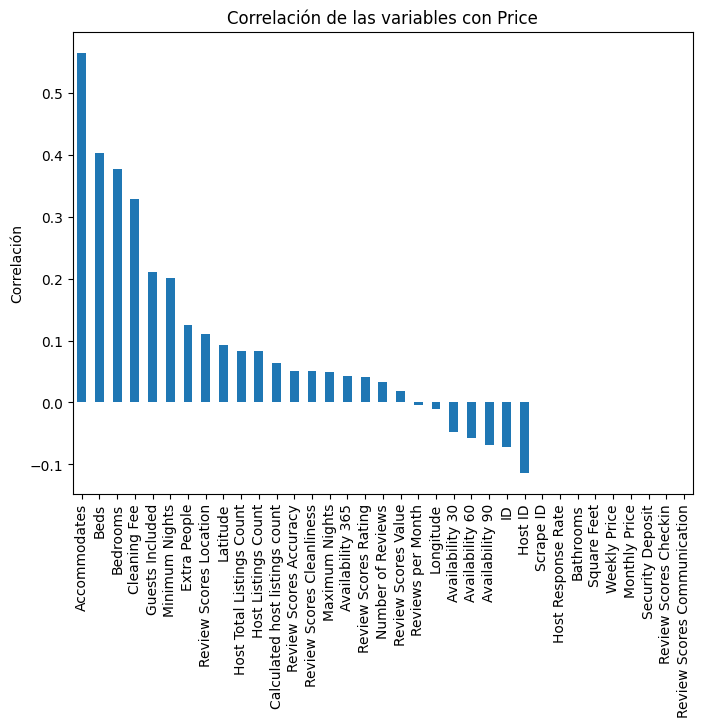

In [36]:
# Visualización de correlación de las características con la variable objetivo
plt.figure(figsize=(8, 6))
correlation_with_target.drop(target_variable).plot(kind='bar')
plt.title("Correlación de las variables con Price")
plt.ylabel("Correlación")
plt.show()

In [37]:
# Identificación de variables altamente correlacionadas
threshold = 0.8
correlation_matrix = variables_numericas.drop(target_variable, axis=1).corr()

variables_correlacionadas = [
    (correlation_matrix.columns[i], correlation_matrix.columns[j])
    for i in range(len(correlation_matrix.columns))
    for j in range(i)
    if abs(correlation_matrix.iloc[i, j]) > threshold
]
print("Pares de variables altamente correlacionadas:")
print(variables_correlacionadas)

Pares de variables altamente correlacionadas:
[('Host Total Listings Count', 'Host Listings Count'), ('Availability 60', 'Availability 30'), ('Availability 90', 'Availability 30'), ('Availability 90', 'Availability 60'), ('Calculated host listings count', 'Host Listings Count'), ('Calculated host listings count', 'Host Total Listings Count')]


In [38]:
# Eliminar variables altamente correlacionadas
variables_a_eliminar = set(pair[1] for pair in variables_correlacionadas)
X = variables_numericas.drop(columns=list(variables_a_eliminar), errors='ignore')

In [39]:
# Aplico Lasso
# Selección de variables numéricas del conjunto imputado
variables_numericas = airbnb_data_imputado.select_dtypes(include=['float64', 'int64'])
X = variables_numericas.drop(columns=['Price'], errors='ignore')  # Características
y = airbnb_data_imputado['Price']  # Variable objetivo

# Escalar características para Lasso
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Selección de características con Lasso
lasso = LassoCV(cv=5, random_state=0).fit(X_scaled, y)
lasso_selected_features = X.columns[lasso.coef_ != 0]

print("Características seleccionadas por Lasso:")
print(lasso_selected_features)

Características seleccionadas por Lasso:
Index(['ID', 'Host ID', 'Host Listings Count', 'Latitude', 'Longitude',
       'Accommodates', 'Bedrooms', 'Beds', 'Cleaning Fee', 'Guests Included',
       'Extra People', 'Minimum Nights', 'Maximum Nights', 'Availability 30',
       'Availability 90', 'Availability 365', 'Number of Reviews',
       'Review Scores Rating', 'Review Scores Accuracy',
       'Review Scores Cleanliness', 'Review Scores Location',
       'Review Scores Value', 'Calculated host listings count',
       'Reviews per Month'],
      dtype='object')


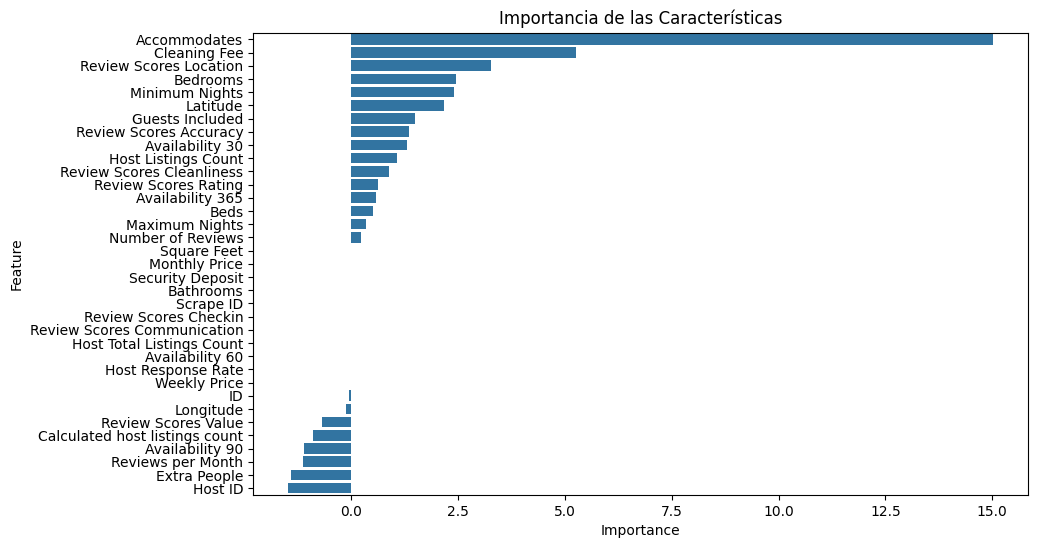

Características finales seleccionadas (Lasso + RF):
{'Cleaning Fee', 'Number of Reviews', 'Availability 365', 'Review Scores Location', 'Review Scores Accuracy', 'Availability 30', 'Latitude', 'Host Listings Count', 'Review Scores Rating', 'Minimum Nights', 'Accommodates', 'Beds', 'Review Scores Cleanliness', 'Maximum Nights', 'Guests Included', 'Bedrooms'}


In [47]:
# Visualizar la importancia de las características
plt.figure(figsize=(10, 6))
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': lasso.coef_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title("Importancia de las Características")
plt.show()
# Filtrar las características seleccionadas por Lasso y Random Forest
selected_features_rf = feature_importances.loc[feature_importances['Importance'] > 0.01, 'Feature']
final_selected_features = set(lasso_selected_features).intersection(selected_features_rf)

print("Características finales seleccionadas (Lasso + RF):")
print(final_selected_features)

In [48]:
# Características finales seleccionadas por Lasso + Random Forest
selected_features = {'Availability 30', 'Extra People', 'Reviews per Month', 'Minimum Nights',
                     'Availability 60', 'Bedrooms', 'Guests Included', 'Latitude',
                     'Availability 365', 'Number of Reviews', 'Review Scores Rating',
                     'Host ID', 'Availability 90', 'Review Scores Location', 'Longitude',
                     'ID', 'Cleaning Fee', 'Accommodates'}

In [49]:
# Pares altamente correlacionados de la matriz de correlación
correlated_pairs = [
    ('Host Total Listings Count', 'Host Listings Count'),
    ('Availability 60', 'Availability 30'),
    ('Availability 90', 'Availability 30'),
    ('Availability 90', 'Availability 60'),
    ('Calculated host listings count', 'Host Listings Count'),
    ('Calculated host listings count', 'Host Total Listings Count')
]

In [50]:
# Identificar variables redundantes de los pares correlacionados
redundant_features = set(pair[1] for pair in correlated_pairs)

# Filtrar características finales eliminando las redundantes
final_features = selected_features - redundant_features

print("Características seleccionadas finales (Lasso + RF, sin redundancias):")
print(final_features)

Características seleccionadas finales (Lasso + RF, sin redundancias):
{'Cleaning Fee', 'Number of Reviews', 'Availability 365', 'Reviews per Month', 'Extra People', 'Availability 90', 'Host ID', 'Review Scores Location', 'Longitude', 'Review Scores Rating', 'Latitude', 'Minimum Nights', 'Accommodates', 'Guests Included', 'Bedrooms', 'ID'}


In [51]:
# Crear un subconjunto del DataFrame con las características finales
airbnb_data_filtered = airbnb_data_imputado[list(final_features) + ['Price']]  # Agregamos 'Price' como objetivo

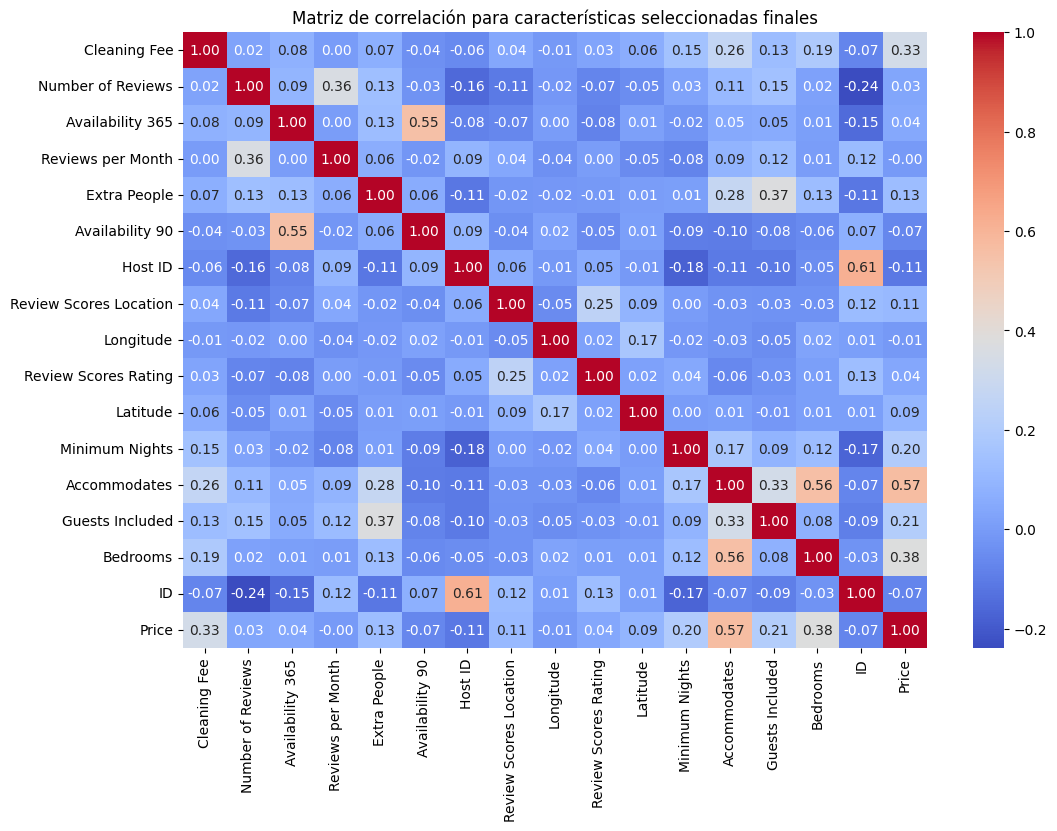

In [52]:
# Matriz de correlación para las características seleccionadas finales
plt.figure(figsize=(12, 8))
correlation_matrix = airbnb_data_filtered.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Matriz de correlación para características seleccionadas finales')
plt.show()

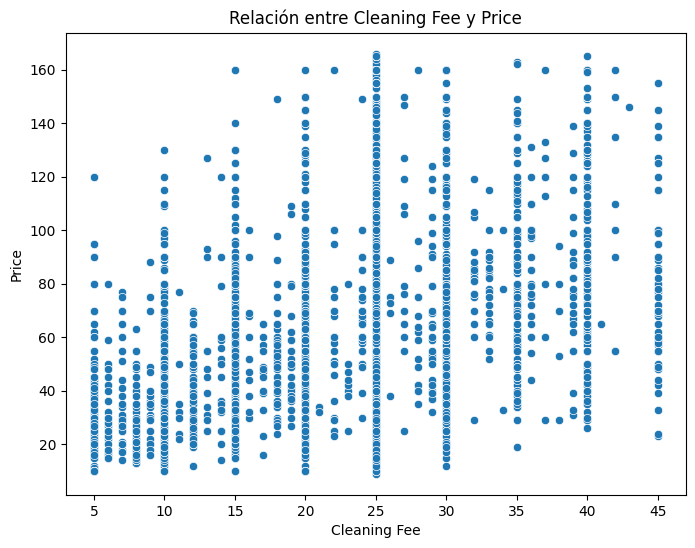

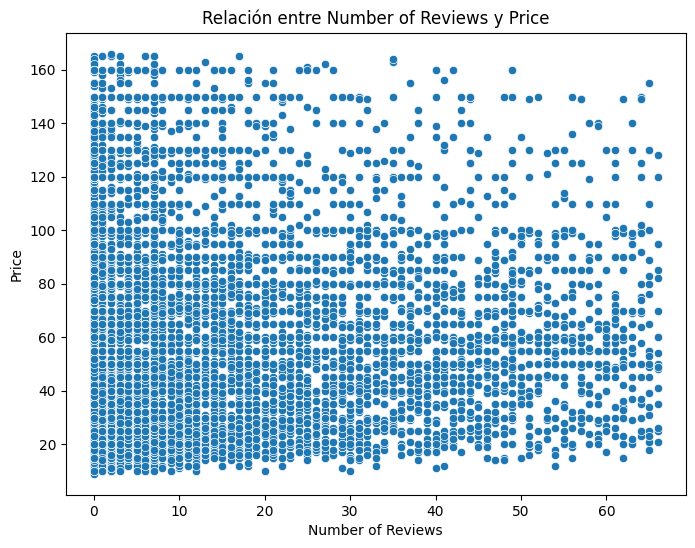

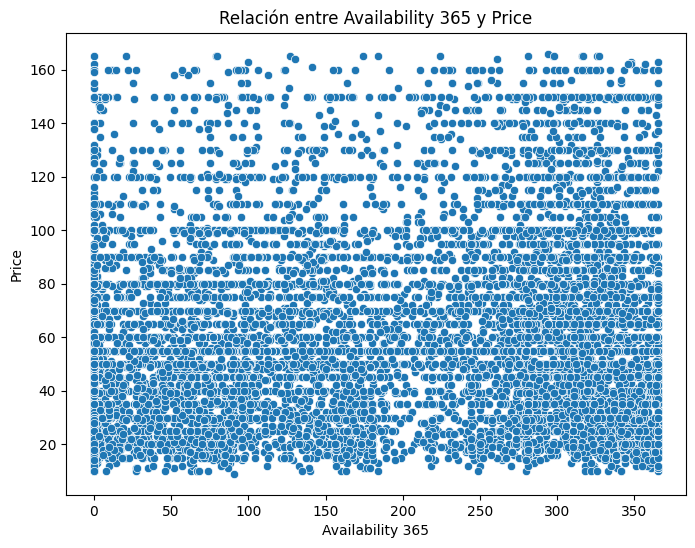

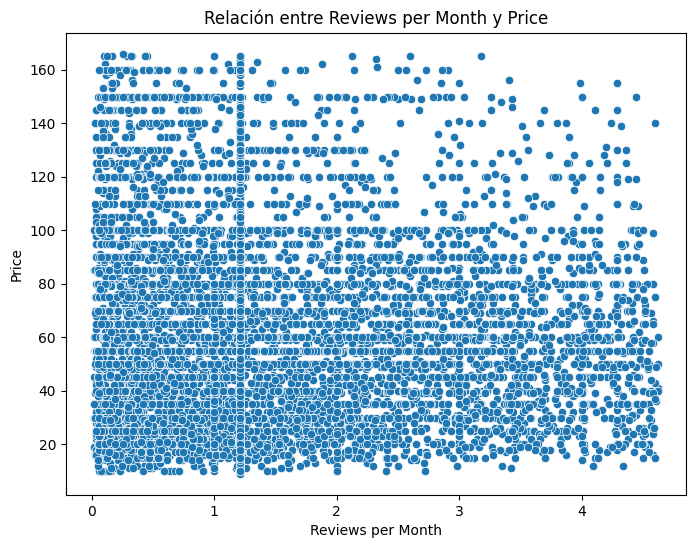

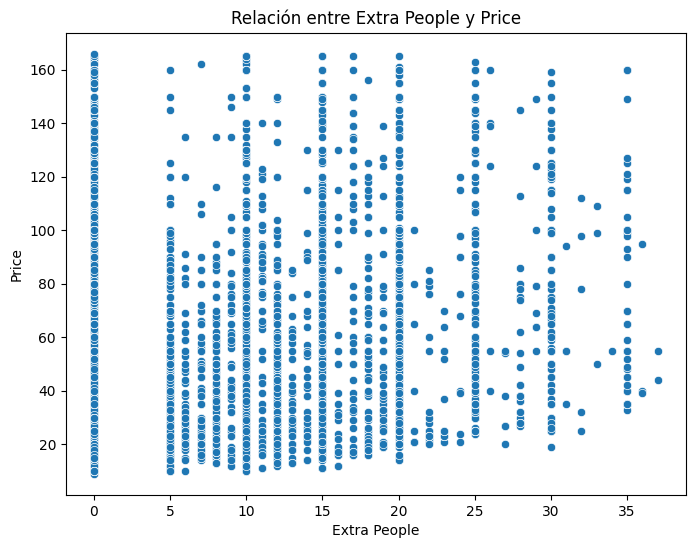

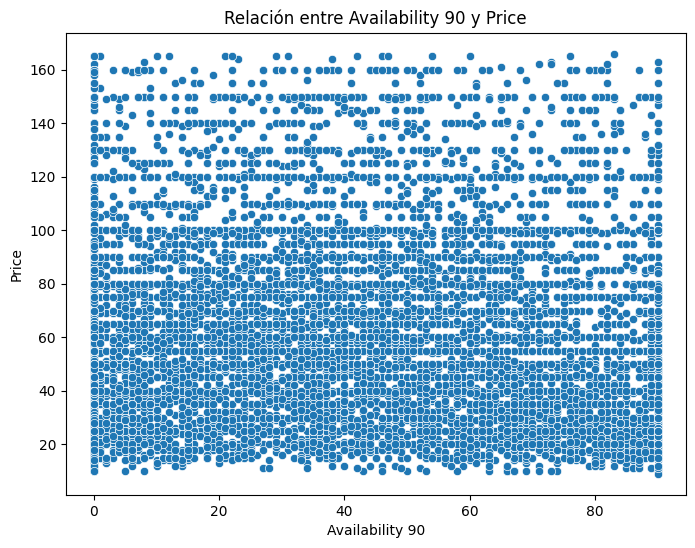

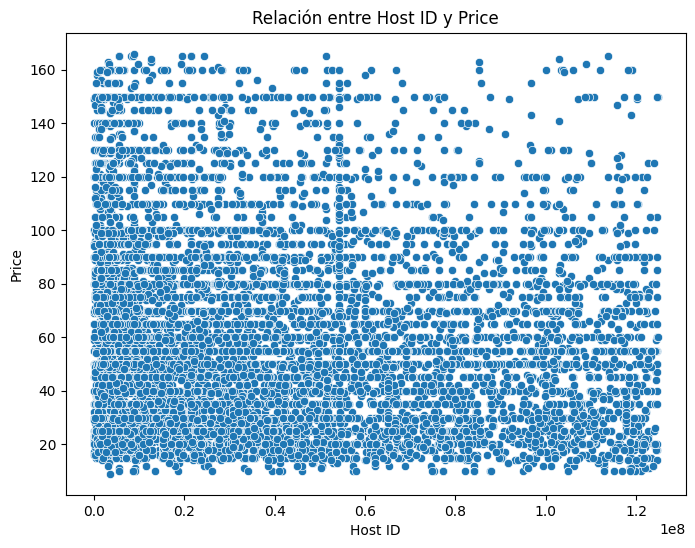

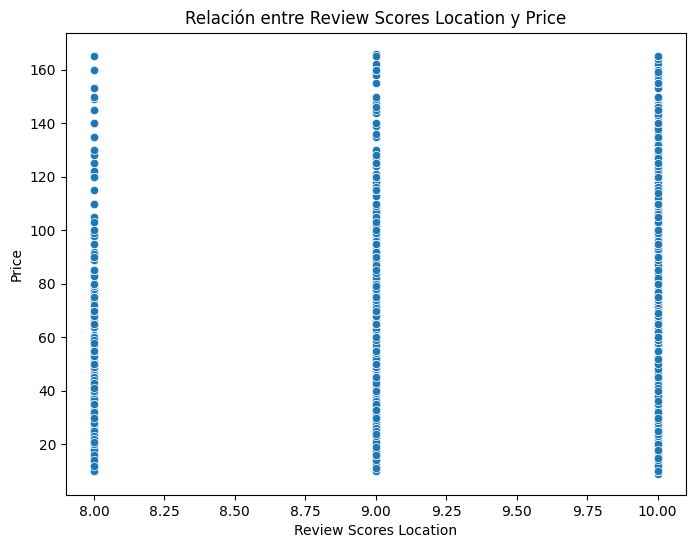

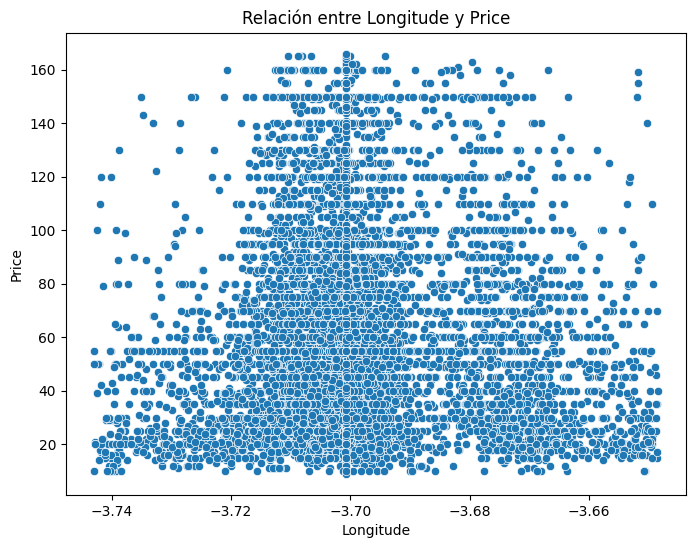

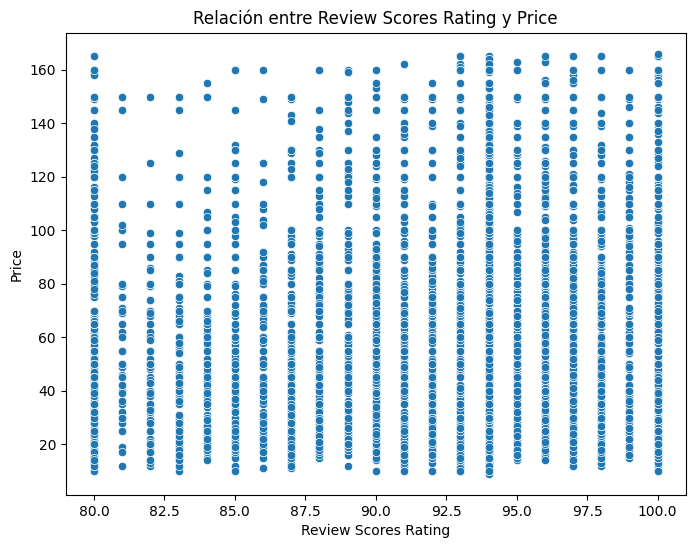

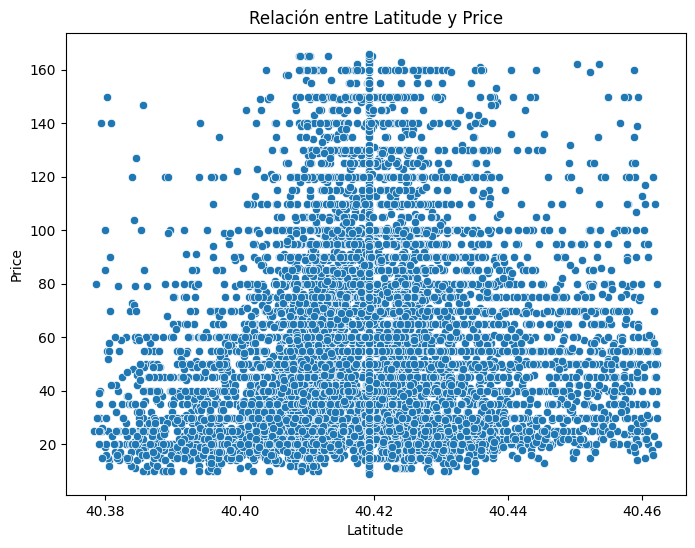

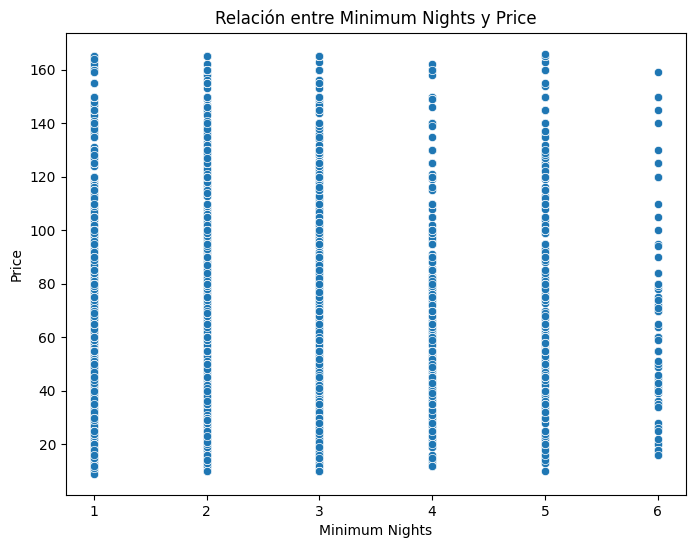

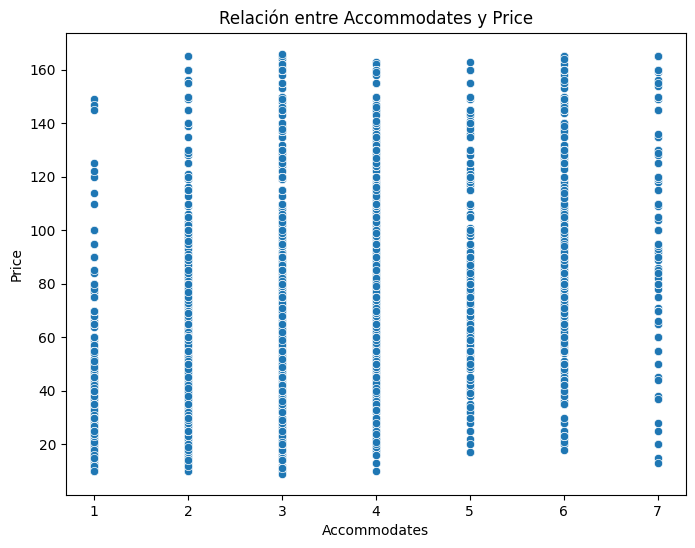

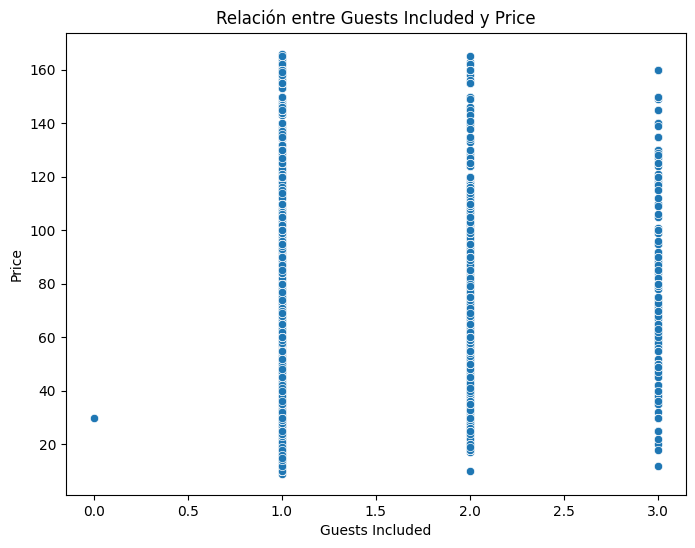

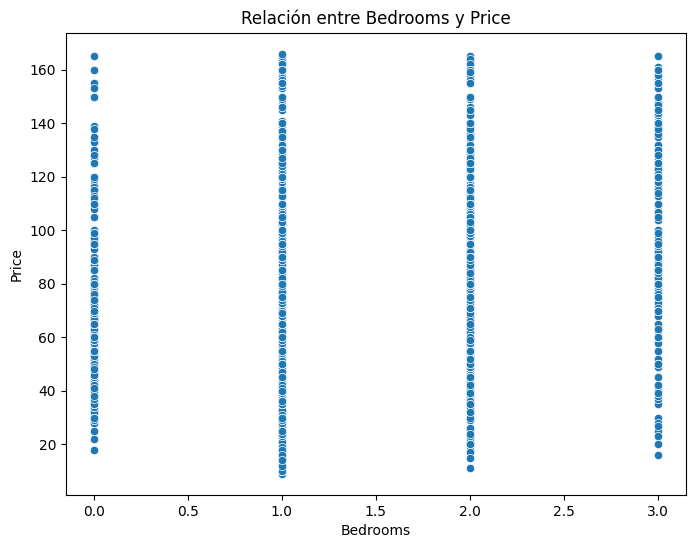

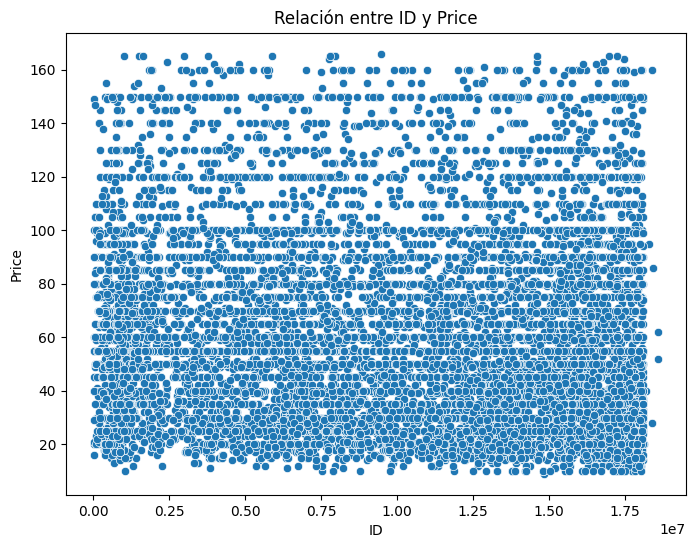

In [53]:
# Diagrama de dispersión
for feature in final_features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=airbnb_data_filtered, x=feature, y='Price')
    plt.title(f'Relación entre {feature} y Price')
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.show()

In [56]:
# Gráficos de boxplot para variables categóricas seleccionadas (si existen en
# final_features)
categorical_features = airbnb_data_filtered.select_dtypes(include=['object']).columns.intersection(final_features)
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=airbnb_data_filtered, x=feature, y='Price')
    plt.title(f'Relación entre {feature} y Price')
    plt.xticks(rotation=45)
    plt.show()

División del Conjunto de Datos
#####División estratificada en train (80%) y test (20%) con respecto a la variable objetivo Price (usando Price_bin).
#####Aleatorización para evitar sesgos por orden de las muestras.

In [65]:
# Estratificación y aleatorización
airbnb_data_filtered['Price_bin'] = pd.qcut(airbnb_data_filtered['Price'], q=5, labels=False)
airbnb_data_filtered = shuffle(airbnb_data_filtered, random_state=42)

In [66]:
# División estratificada en train/test
X = airbnb_data_filtered.drop(columns=['Price', 'Price_bin'])
y = airbnb_data_filtered['Price']
strat_train, strat_test = train_test_split(airbnb_data_filtered, test_size=0.2, stratify=airbnb_data_filtered['Price_bin'], random_state=42)
X_train = strat_train.drop(columns=['Price', 'Price_bin'])
y_train = strat_train['Price']
X_test = strat_test.drop(columns=['Price', 'Price_bin'])
y_test = strat_test['Price']

# ======= Pipeline de Preprocesamiento ========

In [59]:
# Columnas numéricas y categóricas
num_attribs = X_train.select_dtypes(include=['float64', 'int64']).columns
cat_attribs = X_train.select_dtypes(include=['object']).columns

In [60]:
# Pipeline para variables numéricas
num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

In [72]:
# Pipeline para variables categóricas
cat_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("encode", OneHotEncoder(handle_unknown="ignore"))
])

In [84]:
# Combinación de pipelines con ColumnTransformer
preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

# ======= Modelado con Diferentes Algoritmos ========
#####Se entrenaron y evaluaron varios modelos utilizando validación cruzada y ajuste de hiperparámetros

In [85]:
# Modelo: Regresión Lineal
# Crear el pipeline completo
lin_reg_pipeline = Pipeline([
    ("preprocessing_pipeline", preprocessing),
    ("linear_regression", LinearRegression())
])

# Entrenar el modelo
lin_reg_pipeline.fit(X_train, y_train)

# Validación cruzada en el conjunto de entrenamiento
lin_rmse_cv = -cross_val_score(lin_reg_pipeline, X_train, y_train,
                               scoring="neg_root_mean_squared_error", cv=5)
print(f"Regresión Lineal - RMSE medio (validación cruzada): {lin_rmse_cv.mean():.2f}")

# Evaluación en el conjunto de prueba
y_pred = lin_reg_pipeline.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Resultados en el conjunto de prueba:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

Regresión Lineal - RMSE medio (validación cruzada): 25.50
Resultados en el conjunto de prueba:
RMSE: 26.41
R²: 0.37


Regresión Lineal
#####Técnica: Pipeline con preprocesamiento y LinearRegression.
Resultados:
#####RMSE (validación cruzada): 26.45
#####RMSE (test): 25.50
#####R²: 0.47
Conclusión: Modelo básico, rendimiento aceptable

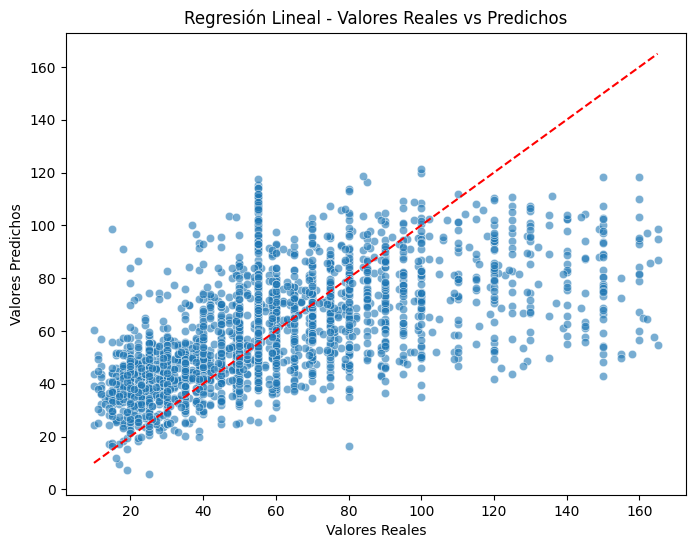

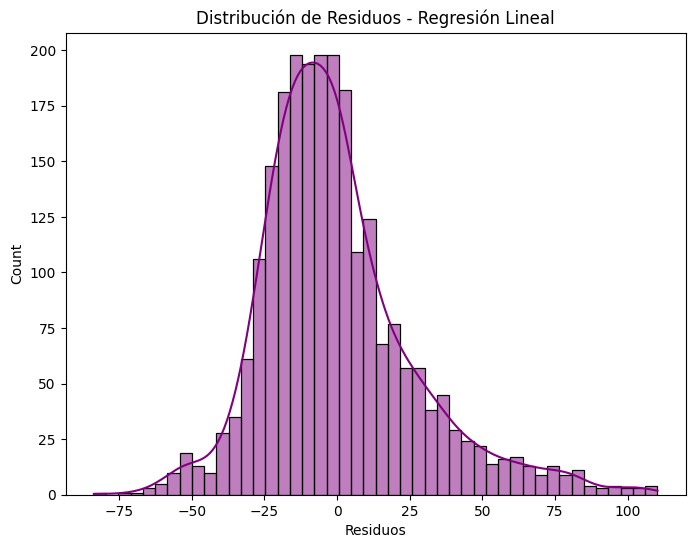

In [83]:
# Visualización de Resultados
# Comparación entre valores reales y predichos
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.title("Regresión Lineal - Valores Reales vs Predichos")
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.show()

# Histograma de residuos
residuos = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuos, kde=True, color='purple')
plt.title("Distribución de Residuos - Regresión Lineal")
plt.xlabel("Residuos")
plt.show()

In [86]:
# Modelo: Árbol de Decisión
# Crear el pipeline para Árbol de decisión
tree_reg_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("decision_tree", DecisionTreeRegressor(random_state=42))
])

In [87]:
# Entrenar el modelo
tree_reg_pipeline.fit(X_train, y_train)

# Validación cruzada en el conjunto de entrenamiento
tree_rmse_cv = -cross_val_score(tree_reg_pipeline, X_train, y_train,
                                scoring="neg_root_mean_squared_error", cv=5)
print(f"Árbol de Decisión - RMSE medio (validación cruzada): {tree_rmse_cv.mean():.2f}")

# Evaluación en el conjunto de prueba
y_pred_tree = tree_reg_pipeline.predict(X_test)
rmse_tree = mean_squared_error(y_test, y_pred_tree, squared=False)
r2_tree = r2_score(y_test, y_pred_tree)

print("Resultados en el conjunto de prueba:")
print(f"RMSE: {rmse_tree:.2f}")
print(f"R²: {r2_tree:.2f}")

Árbol de Decisión - RMSE medio (validación cruzada): 32.35
Resultados en el conjunto de prueba:
RMSE: 33.88
R²: -0.04


Árbol de Decisión
#####Técnica: Pipeline con preprocesamiento y DecisionTreeRegressor.
Resultados:
#####RMSE (validación cruzada): 30.75
#####RMSE (test): 33.88
#####R²: -0.04
Conclusión: El modelo presentó sobreajuste y un desempeño deficiente.

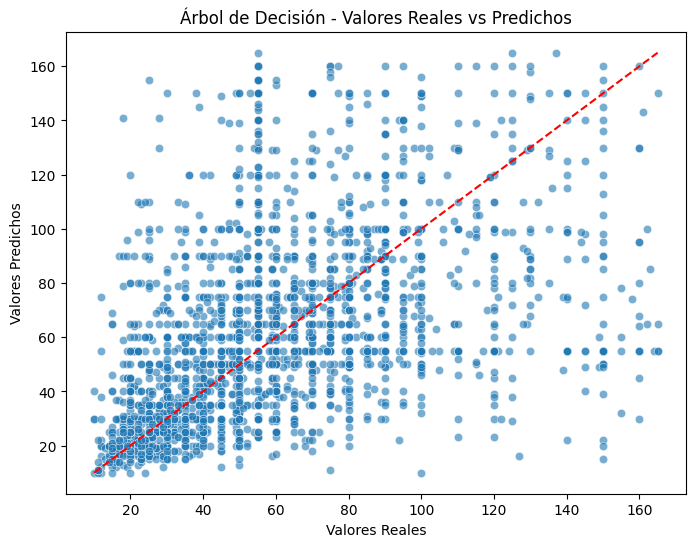

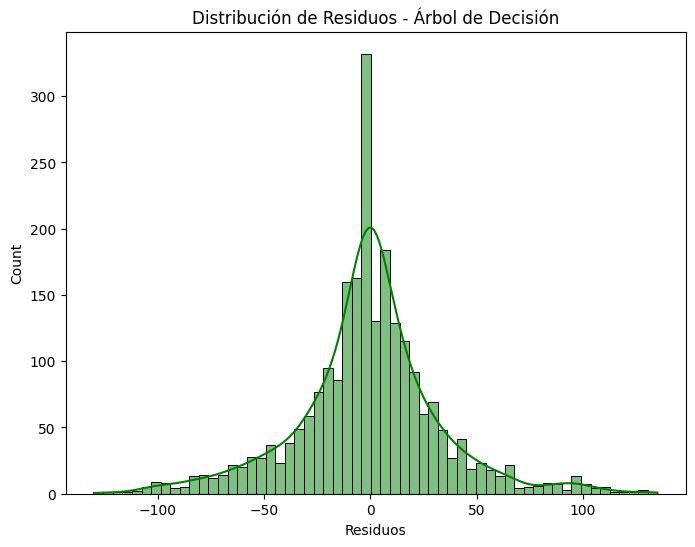

In [88]:
# Visualización de Resultados
# Comparación entre valores reales y predichos
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_tree, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.title("Árbol de Decisión - Valores Reales vs Predichos")
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.show()

# Histograma de residuos
residuos_tree = y_test - y_pred_tree
plt.figure(figsize=(8, 6))
sns.histplot(residuos_tree, kde=True, color='green')
plt.title("Distribución de Residuos - Árbol de Decisión")
plt.xlabel("Residuos")
plt.show()

In [89]:
# Modelo Random Forest
# Selección de características + Random Forest
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),  # Preprocesamiento
    ("feature_selection", SelectFromModel(LassoCV(cv=5, random_state=42))),  # Selección de características
    ("random_forest", RandomForestRegressor(random_state=42))  # Modelo Random Forest
])

In [90]:
# Definir GridSearchCV
# Configuración de la búsqueda de hiperparámetros
param_grid = [
    {'random_forest__n_estimators': [100, 200],
     'random_forest__max_features': [4, 6, 8],
     'random_forest__max_depth': [10, 15, None]},
    {'random_forest__n_estimators': [300],
     'random_forest__max_features': [6, 8, 10],
     'random_forest__max_depth': [20, None]}
]

# Configuración de GridSearchCV
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=2)

In [91]:
# Entrenamiento
# Entrenar GridSearchCV
print("Realizando búsqueda de hiperparámetros para Random Forest...")
grid_search.fit(X_train, y_train)

# Mostrar mejores parámetros
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

Realizando búsqueda de hiperparámetros para Random Forest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Mejores parámetros encontrados:
{'random_forest__max_depth': None, 'random_forest__max_features': 4, 'random_forest__n_estimators': 200}


In [92]:
# Evaluación del Mejor Modelo
# Evaluar el modelo optimizado
best_model = grid_search.best_estimator_

# Predicción en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Métricas de rendimiento
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("\nResultados del modelo optimizado en el conjunto de prueba:")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


Resultados del modelo optimizado en el conjunto de prueba:
RMSE: 23.46
R²: 0.50


Random Forest
#####Optimización: Ajuste de hiperparámetros con GridSearchCV.
Mejores parámetros:
#####n_estimators: 200
#####max_features: 4
#####max_depth: None
Resultados:
#####RMSE (test): 23.46
#####R²: 0.50
Importancia de Características:
#####Availability_365: 0.24
#####Minimum_Nights: 0.18
#####Longitude: 0.12
#####Bedrooms: 0.10


In [98]:
#Analizar los mejores modelos y sus errores
results = pd.DataFrame(grid_search.cv_results_)
# Obtener el mejor modelo ajustado con GridSearchCV
final_model = grid_search.best_estimator_ # Changed rnd_search to grid_search

# Extraer las importancias de características del modelo Random Forest
feature_importances = final_model.named_steps["random_forest"].feature_importances_

# Obtener los nombres de las características procesadas por el pipeline de preprocesamiento
feature_names = final_model.named_steps["preprocessing"].get_feature_names_out()

# Combinar nombres de características con sus importancias
importances_sorted = sorted(
    zip(feature_importances.round(2), feature_names),
    reverse=True  # Ordenar de mayor a menor importancia
)

# Mostrar las importancias ordenadas
print("Importancia de las características seleccionadas (ordenadas):")
for importance, feature in importances_sorted:
    print(f"{feature}: {importance}")

Importancia de las características seleccionadas (ordenadas):
num__Latitude: 0.24
num__Longitude: 0.11
num__Accommodates: 0.11
num__Availability 90: 0.1
num__Availability 365: 0.09
num__Cleaning Fee: 0.07
num__Reviews per Month: 0.06
num__Number of Reviews: 0.05
num__Extra People: 0.05
num__Review Scores Rating: 0.04
num__Review Scores Location: 0.04
num__Minimum Nights: 0.03
num__Host ID: 0.02


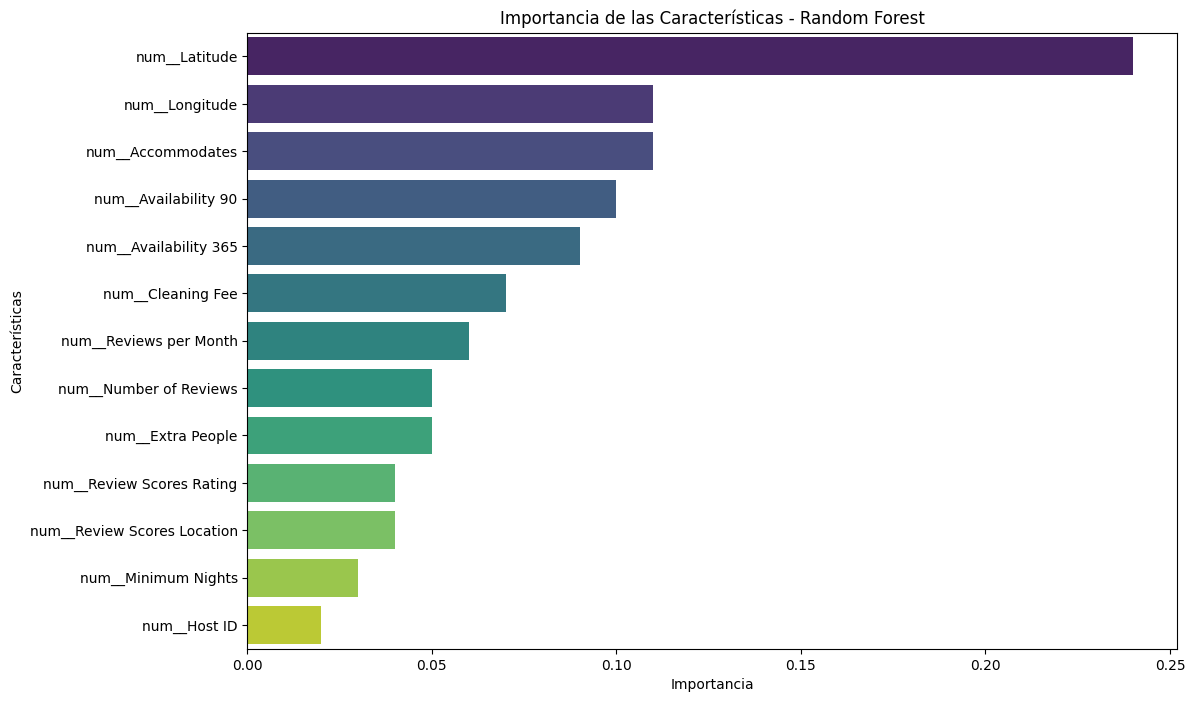

In [99]:
# Crear un DataFrame con las importancias y nombres
importances_df = pd.DataFrame(importances_sorted, columns=["Importance", "Feature"])

# Visualización con Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=importances_df, palette="viridis")
plt.title("Importancia de las Características - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.show()

In [101]:
# Modelo XGBoost
xgb_pipeline = Pipeline([
    ("preprocessing", preprocessing),  # Preprocesamiento definido anteriormente
    ("feature_selection", SelectFromModel(LassoCV(cv=5, random_state=42))),  # Selección de características
    ("xgboost", XGBRegressor(random_state=42))  # Modelo XGBoost
])

In [105]:
# Configuración de Hiperparámetros
param_distribs = {
    'xgboost__n_estimators': [100, 200, 300],
    'xgboost__max_depth': [3, 5, 7],
    'xgboost__learning_rate': [0.01, 0.1, 0.2],
    'xgboost__subsample': [0.7, 0.8, 1.0]
}

# Búsqueda aleatoria de hiperparámetros con RandomizedSearchCV
rnd_search_xgb = RandomizedSearchCV(xgb_pipeline, param_distributions=param_distribs,
                                    n_iter=20, scoring='neg_root_mean_squared_error',
                                    cv=3, random_state=42, verbose=2, n_jobs=-1)

In [106]:
# ======= Entrenamiento del Modelo ========
print("Entrenando XGBoost con RandomizedSearchCV...")
rnd_search_xgb.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("\nMejores parámetros encontrados para XGBoost:")
print(rnd_search_xgb.best_params_)

Entrenando XGBoost con RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Mejores parámetros encontrados para XGBoost:
{'xgboost__subsample': 0.8, 'xgboost__n_estimators': 200, 'xgboost__max_depth': 5, 'xgboost__learning_rate': 0.1}


In [107]:
# Evaluación en el Conjunto de Prueba
# Seleccionar el mejor modelo optimizado
final_xgb_model = rnd_search_xgb.best_estimator_

# Predicciones en el conjunto de prueba
final_predictions_xgb = final_xgb_model.predict(X_test)

# Calcular RMSE y R²
final_rmse_xgb = mean_squared_error(y_test, final_predictions_xgb, squared=False)
final_r2_xgb = r2_score(y_test, final_predictions_xgb)

print("\nResultados del modelo XGBoost optimizado en el conjunto de prueba:")
print(f"RMSE Final: {final_rmse_xgb:.2f}")
print(f"R² Final: {final_r2_xgb:.2f}")



Resultados del modelo XGBoost optimizado en el conjunto de prueba:
RMSE Final: 23.51
R² Final: 0.50


XGBoost
Optimización: Hiperparámetros ajustados con RandomizedSearchCV.
Mejores parámetros:
#####n_estimators: 200
#####max_depth: 5
#####learning_rate: 0.1
#####ubsample: 0.8
Resultados:
#####RMSE (test): 23.51
#####R²: 0.50
Conclusión: XGBoost mostró un rendimiento similar a Random Forest, siendo más eficiente en la optimización.

El modelo XGBoost hace un mejor trabajo al predecir los precios ya que captura un parte significativa de las variables de los datos.
El R² en 0.50 nos indica que aún hay un 50% que no se explica.
Lo que sugiere que pueden haber otras variables o interacciones entre variables que no se están tomando en cuenta.

Comparación de Modelos
#####Modelo	          RMSE (Test)	R² (Test)	Comentarios
#####Regresión Lineal	25.50	      0.47	    Rendimiento aceptable, modelo simple.
#####Árbol de Decisión33.88	     -0.04	    Sobreajuste, no adecuado para este caso.
#####Random Forest	  23.46	      0.50	    Buen rendimiento, modelo robusto.
#####XGBoost	        23.51	      0.50	    Buen rendimiento, más eficiente.

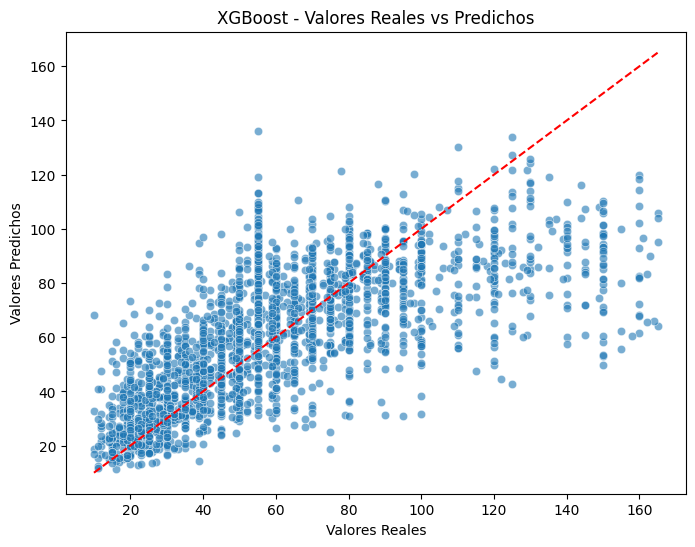

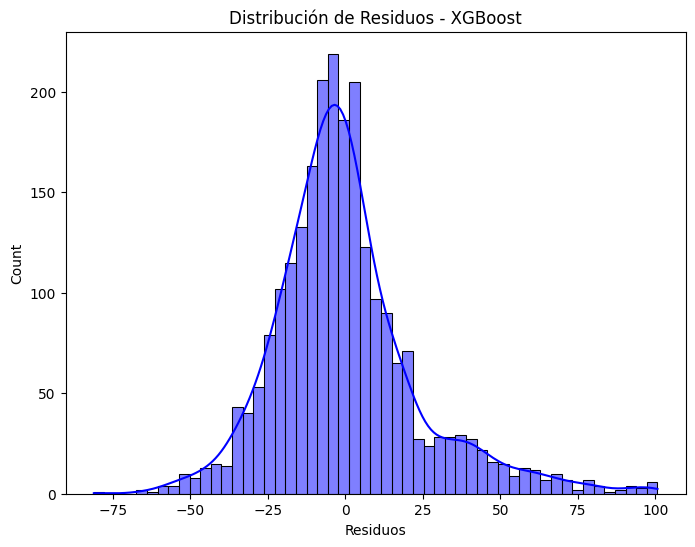

In [108]:
# Visualización de Resultados
# Comparación entre valores reales y predichos
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=final_predictions_xgb, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.title("XGBoost - Valores Reales vs Predichos")
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.show()

# Histograma de residuos
residuos_xgb = y_test - final_predictions_xgb
plt.figure(figsize=(8, 6))
sns.histplot(residuos_xgb, kde=True, color="blue")
plt.title("Distribución de Residuos - XGBoost")
plt.xlabel("Residuos")
plt.show()

In [109]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluación del sistema en el conjunto de prueba
# X_test: conjunto de características del test
# y_test: variable objetivo del test

# El pipeline final ya incluye el preprocesamiento
final_predictions = final_model.predict(X_test)

# Calcular RMSE (Raíz del Error Cuadrático Medio)
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
final_r2 = r2_score(y_test, final_predictions)

# Mostrar los resultados
print("Resultados en el conjunto de prueba:")
print(f"RMSE Final: {final_rmse:.2f}")
print(f"R² Final: {final_r2:.2f}")


Resultados en el conjunto de prueba:
RMSE Final: 23.46
R² Final: 0.50


Conclusión

Numericamente los resultados indican que los mejores resultados se obtuvieron con Random Forest y XGBoost con un RMSE de aproximadamente 23.5.
El modelo explica alrededor del 50% de la variabilidad del precio (R² = 0.50)


En términos generales los resultados obtenidos creo que son un buen punto de partida, ya que el proceso de tomar datos completamente desconocidos, analizarlos en profundidad, realizar ajustes al modelo me han brindado la oportunidad de poner en practica lo visto en la clase.

Al finalizar el proyecto entiendo que éstos resultados no son optimos, que pueden mejorar teniendo en cuenta el contexto desarrollado.
Por ejemplo hay características que pueden ser decisivas en la determinación del precio: la ubicación, las características del alojamiento, los servicios adicionales, las calificaciones y reseñas.Tendría que mejorar en la ingeniería de características y ajustar los hiperparámetros.